# Suffolk Data Science Case Study
This project aims to develop a predictive model to address the rising cancellation rates for a hotel chain. The model predicts the likelihood of a reservation being canceled using the "Hotel Booking Demand" dataset, which includes reservation details for City and Resort hotels. The model is trained on data from 2015-2016 and tested on 2017 data

# 1. Import Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as ss

import math 
import numpy as np
from scipy import stats

import os
import re
import timeit

import country_converter as coco
from geopy.exc import GeocoderTimedOut 
from geopy.geocoders import Nominatim 

from datetime import datetime, timedelta


import warnings
warnings.filterwarnings(action='ignore')
%matplotlib inline

import pickle

fig_size = plt.rcParams["figure.figsize"]

pd.options.display.float_format = '{:.2f}'.format


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# 2. Functions

In [2]:
def fix_col_names(df):
    '''
    takes a df and converts column names to lowercase underscore seperated
    '''
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    return df

In [3]:
## Quick Check for the summary stats for different data types
def summary(df,data_type='numeric'):
    '''
    Calcualte the descriptive stats for different type of data
        Args:
            df: DataFrame.
            data_type=['numeric','categorical']
        Returns:
            this function returns a data frame containing summary stats for different types of data
                

    '''
    if data_type=='numeric':
        df_column=df.columns
        df_describe = df[df_column]
        stats = {
            "Variable": list(x.title() for x in df_column),
            "Min": list(df_describe.apply(np.min,axis=0).values),
            "Median": list(df_describe.apply(np.median,axis=0).values),
            "Mean": list(df_describe.apply(np.mean,axis=0).values),
#             "Variance": list(df_describe.apply(np.var,axis=0).values),
            "Max": list(df_describe.apply(np.max,axis=0).values),
            "Std": list(df_describe.apply(np.std,axis=0).values),
#             "Kurtosis": df_describe.apply(lambda x:x.kurt(),axis=0).values.tolist(),
#             "Skewness": df_describe.apply(lambda x:x.skew(),axis=0).values.tolist(),
#             "Sum": list(df_describe.apply(np.sum,axis=0).values),
#             "Mad": df_describe.apply(lambda x:x.mad(),axis=0).values.tolist(),
            "N_Zeros": df_describe.apply(lambda x:len(x)-np.count_nonzero(x),axis=0).values.tolist(),
            "N_Nulls": df_describe.apply(lambda x:np.count_nonzero(np.isnan(x)),axis=0).values.tolist(),
            'Count': df_describe.apply(lambda x:len(x),axis=0).values
        }
        print ("Numeric Variables Dataset Shape: "+ str(df_describe.shape))
        return pd.DataFrame(stats)
    
    elif data_type=='categorical':
        df_column=df.columns
#         df_column=df.select_dtypes(include=['object','bool']).columns
        df_describe = df[df_column]
        stats = {
            "Variable": list(x.title() for x in df_column),
#             "Count":list(df_describe.apply(lambda x: x.count(),axis=0)),
            'Unique':list(df_describe.apply(lambda x:x.nunique(),axis=0)),
            "Top": list(df_describe.apply(lambda x: x.value_counts().index[0],axis=0)),
            "Freq": list(df_describe.apply(lambda x: x.value_counts().iloc[0],axis=0)),
            "N_Nulls": df_describe.apply(lambda x: x.isna().sum(),axis=0 ),
            'N_Blanks': df_describe.applymap(lambda x: x == '').sum(),
            'Count': df_describe.apply(lambda x: len(x),axis=0).values,
        }
        print ("Categorical Variables Dataset Shape: "+ str(df_describe.shape))
        return pd.DataFrame(stats).sort_values('Unique',ascending=False)

In [4]:
def dbl_density_plot(df_in, hue_ax, xaxis_1, xaxis_2, dist_type='kde', chz_palette='tab10'):
    
    """
    Creates 2 side by side plots grouped together by hue_ax feature parameter.  Plot 1 is of original raw data
    and plot 2 is normalized using the normalize_numeric_data function. 
    
    Ultimate goal is to redistribute data where outliers or high skew make it difficult to draw comparisons
    and conclusions between each group. The normalized density plot takes the axis labels of the raw plot
    to convert the normalized scale values back to corresponding raw values. 

    There are 2 options for display, either a density plot using kdeplot, or histogram using histplot. 
    Histplot option is about 5 to 10 times slower to produce plots.

    df_in: Dataframe from normalize_numeric_data function where each feature has a raw data version and 
        normalized version (except when the normalizer errors out on nulls, errors, or the data is 
        already normal)
    hue_ax: This field is used for segmenting the data (seasonyear, customersegment, target etc.)
    xaxis_1: The original raw feature
    xaxis_2: the normalized version of the feature
    dist_type: 'kde' - produces an overlayed density plot, 'hist' - produces overlayed histograms with 
        density lines. kde is quite a bit after than the hist option.  Density plots provide a smoothed
        view of the distribution, while adding histograms will provide a bit more detail.
    chz_palette:  choose pallete option for changing the color palette depending on the type of data being worked with.  
        Default is 'tab10' which is categorical. If working with ordinal data, use an ordered hue here.

    output: displays plots
    """
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12, 3))

    #raw plots
    if dist_type == 'kde':
        sns.kdeplot(data=df_in, x=xaxis_1, hue=hue_ax, fill=True, ax=ax1, palette=chz_palette) #'tab10'

        
    elif dist_type == 'hist':
        sns.histplot(data=df_in[[xaxis_1,hue_ax]], x=xaxis_1, hue=hue_ax, kde=True, ax=ax1, palette=chz_palette) #'tab10'

    #normalized plots
    try:
        if dist_type == 'kde':
            sns.kdeplot(data=df_in, x=xaxis_2, hue=hue_ax, fill=True,ax=ax2, palette=chz_palette) #'tab10''

        elif dist_type == 'hist':
            sns.histplot(data=df_in[[xaxis_2,hue_ax]], x=xaxis_2, hue=hue_ax, kde=True, ax=ax2, palette=chz_palette) #'tab10'

        #set figure, but do not show, to get axis details for adjustments below
        fig.canvas.draw()

        fig_ax2 = fig.get_axes()[1] #2nd plot axis

        # Get index labels, clean and set to float
        ax2_ticks = [t.get_text() for t in fig_ax2.get_xticklabels()]
        ax2_ticks = [float(x[1:])*-1 if x[0]=='−' else float(x) for x in ax2_ticks]

        
        #pair up labels with closest raw labels and create new list of ticks
        ax2_match_ticks = []
        for val in ax2_ticks:
            df_raw_val = df_in.iloc[(df_in[xaxis_2]-val).abs().argsort()[:2]]
            ax2_match_ticks += [str(df_raw_val[xaxis_1].mean().round(4))]
        
        #replace norm axis labels with retrieved original raw labels
        fig_ax2.set_xticklabels(ax2_match_ticks, rotation=45)

        #if the order is increasing, leave as-is, else flip the xaxis to match the order of the original raw axis
        if ax2_match_ticks[0] > ax2_match_ticks[-1]:
            fig_ax2.invert_xaxis()

    except Exception as e: 
        print(e)
        
    plt.show()

In [5]:


def display_nullsZeros_tables(df_in, checktype='zeros', timevar=None, modelsortyears=[], sortby='', nfeats_per_group = 15, get_table=False):
    """
    TODO - FUNCTION COMMENT
    
    """
        
    def horizontal(dfs):
        from IPython.display import HTML
        
        html = '<div style="display:flex">'
        for df in dfs:
            html += '<div style="margin-right: 32px">'
            html += df.to_html()
            html += '</div>'
        html += '</div>'
        display(HTML(html))
    
        loop_cnt = range(int(np.ceil(len(col_ls)/nfeats_per_group)))
        print('loop cnt: ',loop_cnt)
        print('feature count per table: ',nfeats_per_group)
    
    
    # get years and obs counts
    timevar_ls = list(set(df_in[timevar]))
    timevar_cnts = df_in[timevar].value_counts().sort_index(ascending=True)

    df_bins = df_in.copy()

    #create binaries
    #zeros 
    if checktype == 'zeros':
        df_bins.set_index(timevar,drop=True, inplace=True)
        df_bins = df_bins == 0
        print('DISPLAYING ZERO ANALYSIS')
        print(30*'_')
    #nulls
    if checktype == 'nulls':
        null_cols = df_bins.isnull().sum()[df_bins.isnull().sum() !=0].sort_values(ascending=False)
        
        df_bins.set_index(timevar,drop=True, inplace=True)
        df_bins = df_bins[null_cols.index]
        df_bins = df_bins.isnull() 
        print('DISPLAYING NULLS ANALYSIS')
        print(30*'_')
         
    print(len(list(df_bins)))
    
    # # zeros count and props aggregaated across whole dataset
    df_bins_summary = pd.concat((df_bins.sum(), df_bins.sum()/df_bins.count()),axis=1).rename(columns={0:'count_all', 1:'props_all'})
    df_bins_summary['obs_all'] = len(df_bins)
        
    # get and combine grouped stats via timevar in index
    df_grp_bins = df_bins.groupby(df_bins.index).sum() # binary matrix
    df_grp_bins = df_grp_bins.apply(lambda x:  x / timevar_cnts) #proportion
    
    # #combine aggregate of years and groupby years
    df_bins_summary = pd.merge(df_bins_summary, df_grp_bins.T, left_index=True, right_index=True, how='outer')
    
    if modelsortyears == []:
        #sort on modelingyears for zeros, years below likely features didn't exist, year above is likely partial year.
        df_bins_summary['avgprop_modelingyears'] = np.nan # still need for column drop later 
        if sortby != 'index':
            df_bins_summary.sort_values('props_all', ascending=False, inplace=True)
    else:
        df_bins_summary['avgprop_modelingyears'] = df_bins_summary[modelsortyears].mean(axis=1)
        if sortby != 'index':
            df_bins_summary.sort_values('avgprop_modelingyears', ascending=False, inplace=True)
    
    # create separate dataframes for different displays
    df_bins_cnt = pd.DataFrame(df_bins_summary[['obs_all','count_all']].copy())
    df_bins_props = df_bins_summary.drop(['obs_all','count_all','avgprop_modelingyears'], axis=1)
    
    # columns lists for display loop
    col_ls = list(df_bins_props.index)
    loop_cnt = range(int(np.ceil(len(col_ls)/nfeats_per_group)))
    print('loop cnt: ',loop_cnt)
    print('feature count per table: ',nfeats_per_group)
     
    n=0
    for i in loop_cnt:
        
        tbl_cols = col_ls[n:n+nfeats_per_group]
        
        horizontal(
           [df_bins_cnt[df_bins_cnt.index.isin(tbl_cols)].style.format(precision=2,thousands=','),
            df_bins_props[df_bins_props.index.isin(tbl_cols)].style.format(precision=2,thousands=',').hide(axis="index").background_gradient(cmap='PuBu', vmin=0, vmax=1), #,axis=1),
            pd.DataFrame(timevar_cnts).T.style.format(precision=2,thousands=',').hide(axis="index").background_gradient(cmap='BuGn', axis=1)
           ]
        )
    
        n+=nfeats_per_group
    
    if get_table:
        return df_bins_summary


In [6]:

def constant_value_check(df,count_NaN=False,dropcols=False):
    '''
    Return a list of columns that have constant value: options to count NaN as unique value in the column. 
    Additional option to drop columns from dataframe.
    
    '''
    if count_NaN == False:
        constant_value_columns=df.columns[df.nunique()==1].tolist()
    elif count_NaN == True:
        ### count NaN as unique value in this method
        constant_value_columns=[col for col in df.columns if len(df[col].unique())==1]
    if dropcols:
        df = df.drop(constant_value_columns,axis=1)
    return df, constant_value_columns

In [7]:
## correlation numeric value and return a column list filtered by threshhold
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def correlations_threshhold(df, threshhold=0.8,less_than=False,absolute=True,pair_list=False):
    '''
    Get correlations between numeric varibales and filter correlations on input threshold or absolute value or both.
    '''
    if pair_list == True:
        if absolute:
            au_corr = df.corr().abs().unstack()
            labels_to_drop = get_redundant_pairs(df)
            au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
            if less_than:
                au_corr_threshhold=au_corr[au_corr < threshhold]
                High_correlation_list = au_corr_threshhold.reset_index()[['level_0','level_1']].values.tolist()
                return High_correlation_list

            else:
                au_corr_threshhold=au_corr[au_corr > threshhold]
                High_correlation_list = au_corr_threshhold.reset_index()[['level_0','level_1']].values.tolist()
                return High_correlation_list
        else:        
            au_corr = df.corr().unstack()
            labels_to_drop = get_redundant_pairs(df)
            au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
            au_corr_threshhold=au_corr[(au_corr < -threshhold)|(au_corr >threshhold)]
            High_correlation_list = au_corr_threshhold.reset_index()[['level_0','level_1']].values.tolist()
            return High_correlation_list
            
    if pair_list == False:
        if absolute:
            au_corr = df.corr().abs().unstack()
            labels_to_drop = get_redundant_pairs(df)
            au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
            if less_than:
                au_corr_threshhold=au_corr[au_corr < threshhold]
                return au_corr_threshhold

            else:
                au_corr_threshhold=au_corr[au_corr > threshhold]
                return au_corr_threshhold
        else:        
            au_corr = df.corr().unstack()
            labels_to_drop = get_redundant_pairs(df)
            au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
            au_corr_threshhold=au_corr[(au_corr < -threshhold)|(au_corr >threshhold)]
            return au_corr_threshhold

In [8]:
def ordered_display(table_in, idx_map):
    table_in.index = table_in.index.map(idx_map)
    display(table_in.sort_index(ascending=False))

# 3. Import Data

In [9]:
# change the path to your local directory folder path where the csv is stored
dat = fix_col_names(pd.read_csv('~/Documents/suffolk_case_study/hotel_bookings.csv'))
print(dat.shape)

(119390, 32)


In [10]:
dat.head()

hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  arrival_date_week_number  arrival_date_day_of_month  stays_in_weekend_nights  stays_in_week_nights  adults  children  babies meal country market_segment distribution_channel  is_repeated_guest  previous_cancellations  previous_bookings_not_canceled reserved_room_type assigned_room_type  booking_changes deposit_type  agent  company  days_in_waiting_list customer_type   adr  required_car_parking_spaces  total_of_special_requests reservation_status reservation_status_date
0  Resort Hotel            0        342               2015               July                        27                          1                        0                     0       2      0.00       0   BB     PRT         Direct               Direct                  0                       0                               0                  C                  C                3   No Deposit    NaN      NaN                     0     Transient  0.00                            0                          0          Check-Out              2015-07-01
1  Resort Hotel            0        737               2015               July                        27                          1                        0                     0       2      0.00       0   BB     PRT         Direct               Direct                  0                       0                               0                  C                  C                4   No Deposit    NaN      NaN                     0     Transient  0.00                            0                          0          Check-Out              2015-07-01
2  Resort Hotel            0          7               2015               July                        27                          1                        0                     1       1      0.00       0   BB     GBR         Direct               Direct                  0                       0                               0                  A                  C                0   No Deposit    NaN      NaN                     0     Transient 75.00                            0                          0          Check-Out              2015-07-02
3  Resort Hotel            0         13               2015               July                        27                          1                        0                     1       1      0.00       0   BB     GBR      Corporate            Corporate                  0                       0                               0                  A                  A                0   No Deposit 304.00      NaN                     0     Transient 75.00                            0                          0          Check-Out              2015-07-02
4  Resort Hotel            0         14               2015               July                        27                          1                        0                     2       2      0.00       0   BB     GBR      Online TA                TA/TO                  0                       0                               0                  A                  A                0   No Deposit 240.00      NaN                     0     Transient 98.00                            0                          1          Check-Out              2015-07-03

In [11]:
dat.arrival_date_year.value_counts()

arrival_date_year
2016    56707
2017    40687
2015    21996
Name: count, dtype: int64

In [12]:
df = dat.copy()

## 1. Sort columns by data type
**INSTRUCTION**  
* This section is to search through and identify the features by type (numeric, boolean, categorical, ordinal)

In [13]:
# get original ordered feature list
all_origsort_ls = list(df)
all_origsort_ls

['hotel',
 'is_canceled',
 'lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'reserved_room_type',
 'assigned_room_type',
 'booking_changes',
 'deposit_type',
 'agent',
 'company',
 'days_in_waiting_list',
 'customer_type',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'reservation_status',
 'reservation_status_date']

In [14]:
df.info(verbose=1,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [15]:

#all
qk_chk = pd.concat((df.nunique(), df.isnull().sum(),df.dtypes),axis=1)
qk_chk.columns = ['unique','isnull','dtypes']
qk_chk.sort_values(by='unique',inplace=True)
qk_chk

unique  isnull   dtypes
hotel                                2       0   object
is_canceled                          2       0    int64
is_repeated_guest                    2       0    int64
arrival_date_year                    3       0    int64
deposit_type                         3       0   object
reservation_status                   3       0   object
customer_type                        4       0   object
required_car_parking_spaces          5       0    int64
meal                                 5       0   object
babies                               5       0    int64
distribution_channel                 5       0   object
children                             5       4  float64
total_of_special_requests            6       0    int64
market_segment                       8       0   object
reserved_room_type                  10       0   object
arrival_date_month                  12       0   object
assigned_room_type                  12       0   object
adults                              14       0    int64
previous_cancellations              15       0    int64
stays_in_weekend_nights             17       0    int64
booking_changes                     21       0    int64
arrival_date_day_of_month           31       0    int64
stays_in_week_nights                35       0    int64
arrival_date_week_number            53       0    int64
previous_bookings_not_canceled      73       0    int64
days_in_waiting_list               128       0    int64
country                            177     488   object
agent                              333   16340  float64
company                            352  112593  float64
lead_time                          479       0    int64
reservation_status_date            926       0   object
adr                               8879       0  float64

In [16]:
#object and <= 2. Convert to bool
logic = qk_chk[(qk_chk['dtypes'] == 'object') & (qk_chk['unique'] <= 2)]
display(logic, list(logic.index))

unique  isnull  dtypes
hotel       2       0  object

['hotel']

In [17]:
# NOT object and <= 2 ~ bool
logic = qk_chk[(qk_chk['dtypes'] != 'object') & (qk_chk['unique'] <= 2)]
display(logic, list(logic.index))

unique  isnull dtypes
is_canceled             2       0  int64
is_repeated_guest       2       0  int64

['is_canceled', 'is_repeated_guest']

In [18]:
# object and > 2 ~ categorical
#RD Why assigned room type has more unique than reserved room type
#Which ones are they?
## Difference between market_segment and distribution_channel is not clear

logic = qk_chk[(qk_chk['dtypes'] == 'object') & (qk_chk['unique'] > 2)]
display(logic, list(logic.index))

unique  isnull  dtypes
deposit_type                  3       0  object
reservation_status            3       0  object
customer_type                 4       0  object
meal                          5       0  object
distribution_channel          5       0  object
market_segment                8       0  object
reserved_room_type           10       0  object
arrival_date_month           12       0  object
assigned_room_type           12       0  object
country                     177     488  object
reservation_status_date     926       0  object

['deposit_type',
 'reservation_status',
 'customer_type',
 'meal',
 'distribution_channel',
 'market_segment',
 'reserved_room_type',
 'arrival_date_month',
 'assigned_room_type',
 'country',
 'reservation_status_date']

In [19]:
# numeric and check 3 to 11 for possible cat 
# children and babies can be merged
logic = qk_chk[(qk_chk['dtypes'] != 'object') & (qk_chk['unique'] >= 3) &  (qk_chk['unique'] <= 11)]
display(logic, list(logic.index))

unique  isnull   dtypes
arrival_date_year                 3       0    int64
required_car_parking_spaces       5       0    int64
babies                            5       0    int64
children                          5       4  float64
total_of_special_requests         6       0    int64

['arrival_date_year',
 'required_car_parking_spaces',
 'babies',
 'children',
 'total_of_special_requests']

In [20]:
# agent and company have lots of nulls
logic = qk_chk[(qk_chk['dtypes'] != 'object') & (qk_chk['unique'] > 11)]
display(logic,list(logic.index))

unique  isnull   dtypes
adults                              14       0    int64
previous_cancellations              15       0    int64
stays_in_weekend_nights             17       0    int64
booking_changes                     21       0    int64
arrival_date_day_of_month           31       0    int64
stays_in_week_nights                35       0    int64
arrival_date_week_number            53       0    int64
previous_bookings_not_canceled      73       0    int64
days_in_waiting_list               128       0    int64
agent                              333   16340  float64
company                            352  112593  float64
lead_time                          479       0    int64
adr                               8879       0  float64

['adults',
 'previous_cancellations',
 'stays_in_weekend_nights',
 'booking_changes',
 'arrival_date_day_of_month',
 'stays_in_week_nights',
 'arrival_date_week_number',
 'previous_bookings_not_canceled',
 'days_in_waiting_list',
 'agent',
 'company',
 'lead_time',
 'adr']

# 4. Data Type lists

In [21]:
target='is_canceled'
timevar='arrival_date_year'

In [22]:
id_ls = [
'is_canceled',
'arrival_date_year',
        ]

In [23]:
chk_cat_ls = [
# Categorical
'deposit_type',
'reservation_status', #only for EDA
'customer_type',
'meal',
'distribution_channel',
'market_segment',
'reserved_room_type',
'arrival_date_month', #Only for EDA
'assigned_room_type', #Only for EDA
'company'

]

chk_bool_ls = [
#bool
'is_repeated_guest'
]

In [24]:
chk_num_ls = [
'required_car_parking_spaces',
'total_of_special_requests',
'adults',
'children',
'babies',
'previous_cancellations',
'stays_in_weekend_nights',
'booking_changes',
'stays_in_week_nights',
'previous_bookings_not_canceled',
'days_in_waiting_list',
'company',
'lead_time',
'adr',
'agent'

]

In [25]:
cat_ls = []
bool_ls = []
num_ls = []

for a in all_origsort_ls:
    print(a)
    if a in chk_cat_ls:
        cat_ls += [a]
    elif a in chk_bool_ls:
        bool_ls += [a]
    elif a in chk_num_ls:
        num_ls += [a]
    else: print('=======col is not any ls:  ', a)  

hotel
=======col is not any ls:   hotel
is_canceled
=======col is not any ls:   is_canceled
lead_time
arrival_date_year
=======col is not any ls:   arrival_date_year
arrival_date_month
arrival_date_week_number
=======col is not any ls:   arrival_date_week_number
arrival_date_day_of_month
=======col is not any ls:   arrival_date_day_of_month
stays_in_weekend_nights
stays_in_week_nights
adults
children
babies
meal
country
=======col is not any ls:   country
market_segment
distribution_channel
is_repeated_guest
previous_cancellations
previous_bookings_not_canceled
reserved_room_type
assigned_room_type
booking_changes
deposit_type
agent
company
days_in_waiting_list
customer_type
adr
required_car_parking_spaces
total_of_special_requests
reservation_status
reservation_status_date
=======col is not any ls:   reservation_status_date


In [26]:
set(df)-set(id_ls)-set(num_ls)-set(cat_ls)-set(bool_ls)

{'arrival_date_day_of_month',
 'arrival_date_week_number',
 'country',
 'hotel',
 'reservation_status_date'}

In [27]:
set(id_ls+num_ls+cat_ls+bool_ls) - set(df)

set()

In [28]:
display(
      id_ls
    , num_ls
    , bool_ls
    , cat_ls
)

['is_canceled', 'arrival_date_year']

['lead_time',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests']

['is_repeated_guest']

['arrival_date_month',
 'meal',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'company',
 'customer_type',
 'reservation_status']

# 5. EDA

## 1. Encode Features

### Encode country to lat/lon

In [29]:
countries = df.country.unique()

standard_names = coco.convert(names=countries, to='name_short', not_found= 'not there')


nan not found in ISO3
TMP not found in ISO3


In [30]:
df_country = pd.DataFrame(standard_names, countries)
df_country = df_country.reset_index()
df_country = df_country.rename(columns = {'index': 'country', 0 : 'full_country'})
df_country.head()

country    full_country
0     PRT        Portugal
1     GBR  United Kingdom
2     USA   United States
3     ESP           Spain
4     IRL         Ireland

In [31]:
longitude = [] 
latitude = [] 

def findGeocode(city): 
       
    # try and catch is used to overcome 
    # the exception thrown by geolocator 
    # using geocodertimedout   
    try: 
          
        # Specify the user_agent as your 
        # app name it should not be none 
        geolocator = Nominatim(user_agent="Geo locater") 
          
        return geolocator.geocode(city) 
      
    except GeocoderTimedOut: 
          
        return findGeocode(city)     
  
# each value from city column 
# will be fetched and sent to 
# function find_geocode    
for i in standard_names: 
      
    if findGeocode(i) != None: 
           
        loc = findGeocode(i) 
          
        # coordinates returned from  
        # function is stored into 
        # two separate list 
        latitude.append(loc.latitude) 
        longitude.append(loc.longitude) 
       
    # if coordinate for a city not 
    # found, insert "NaN" indicating  
    # missing value  
    else: 
        latitude.append(np.nan) 
        longitude.append(np.nan)

In [32]:
df_country["Longitude"] = longitude 
df_country["Latitude"] = latitude 
  
df_country 

country                          full_country  Longitude  Latitude
0       PRT                              Portugal      -8.14     39.66
1       GBR                        United Kingdom      -3.28     54.70
2       USA                         United States    -100.45     39.78
3       ESP                                 Spain      -4.84     39.33
4       IRL                               Ireland      -7.98     52.87
5       FRA                                France       1.89     46.60
6       NaN                             not there      97.32     19.55
7       ROU                               Romania      24.69     45.99
8       NOR                                Norway      11.53     64.57
9       OMN                                  Oman      57.00     21.00
10      ARG                             Argentina     -64.97    -35.00
11      POL                                Poland      19.13     52.22
12      DEU                               Germany      10.45     51.16
13      BEL                               Belgium       4.67     50.64
14      CHE                           Switzerland       8.23     46.80
15       CN                                 China     105.00     35.00
16      GRC                                Greece      21.99     39.00
17      ITA                                 Italy      12.67     42.64
18      NLD                           Netherlands       5.63     52.24
19      DNK                               Denmark      10.33     55.67
20      RUS                                Russia      97.75     64.69
21      SWE                                Sweden      14.52     59.67
22      AUS                             Australia     134.75    -24.78
23      EST                               Estonia      25.33     58.75
24      CZE                               Czechia      15.34     49.74
25      BRA                                Brazil     -53.20    -10.33
26      FIN                               Finland      25.92     63.25
27      MOZ                            Mozambique      34.91    -19.30
28      BWA                              Botswana      24.59    -23.17
29      LUX                            Luxembourg       6.13     49.61
30      SVN                              Slovenia      14.82     46.12
31      ALB                               Albania     -72.52     11.24
32      IND                                 India      78.67     22.35
33      CHN                                 China     105.00     35.00
34      MEX                                Mexico     -99.13     19.43
35      MAR                               Morocco     -10.37     28.33
36      UKR                               Ukraine      31.27     49.49
37      SMR                            San Marino      12.46     43.95
38      LVA                                Latvia      24.75     56.84
39      PRI                           Puerto Rico     -66.49     18.22
40      SRB                                Serbia      21.08     44.02
41      CHL                                 Chile     -71.32    -31.76
42      AUT                               Austria      14.12     47.59
43      BLR                               Belarus      27.70     53.43
44      LTU                             Lithuania      23.75     55.35
45      TUR                               Türkiye      34.92     38.96
46      ZAF                          South Africa      24.99    -28.82
47      AGO                                Angola      17.57    -11.88
48      ISR                                Israel      34.86     30.81
49      CYM                        Cayman Islands     -79.92     19.70
50      ZMB                                Zambia      27.56    -14.52
51      CPV                            Cabo Verde     -24.01     16.00
52      ZWE                              Zimbabwe      29.75    -18.46
53      DZA                               Algeria       3.00     28.00
54      KOR                           South Korea     127.70     36.64
55      CRI                 

In [33]:
df = df.merge(df_country, how = 'left', on = 'country')

### Get reservation date

In [34]:
df['arrival_date_month'] = df['arrival_date_month'].map({'January': 1,
                                                         'February': 2,
                                                         'March': 3,
                                                         'April': 4,
                                                         'May': 5,
                                                         'June': 6,
                                                         'July': 7,
                                                         'August': 8,
                                                         'September': 9,
                                                         'October': 10,
                                                         'November': 11,
                                                         'December': 12
                                })

In [35]:
# lead_time and arrival date difference will give the reservation date. When compared to reservation_status_date can give
#approximate time between booking and cancellation
df['arrival_date'] = pd.to_datetime(dict(year=df.arrival_date_year, month=df.arrival_date_month, day=df.arrival_date_day_of_month))

In [36]:
df['reservation_date'] = df['arrival_date'] -  pd.to_timedelta(df['lead_time'], unit='d')

In [37]:
#to check whether there is a time frame where people change the status
df['diff_reservation_status_change'] = (pd.to_datetime(df['reservation_status_date']) - df['reservation_date']).dt.days

In [38]:
df['days_arr_reservation'] = (pd.to_datetime(df['arrival_date']) - pd.to_datetime(df['reservation_status_date'])).dt.days

<Axes: >

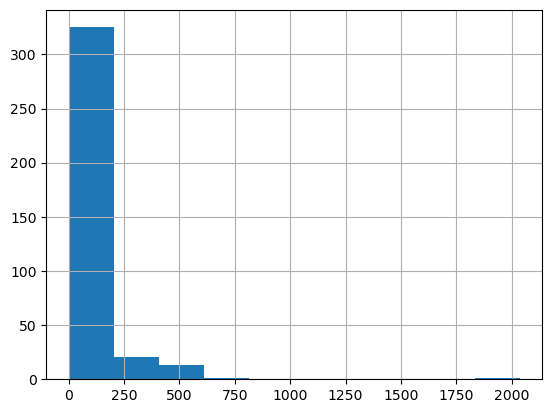

In [39]:
df[(df[target] == 1) & (df.deposit_type == 'No Deposit')]['days_arr_reservation'].value_counts().hist()

The above chart shows the distribution of days for all reservations that are between arrival date and the reservation status change date. This graph can make us understand when the reservations get cancelled and how many days in advance of the arrival the reservation is cancelled. 
It is evident that reservations are cancelled 0-100 days in advance of the arrival when there is no deposit involved

<Axes: >

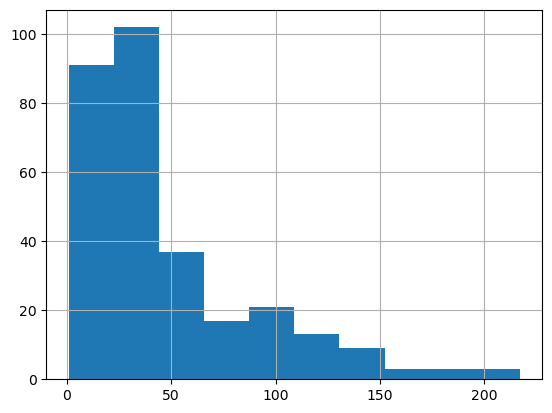

In [40]:
df[(df[target] == 1) & (df.deposit_type == 'Non Refund')]['days_arr_reservation'].value_counts().hist()

Similar to the above chart, the above distribution is for the reservations with non refundable deposit type. All reservations are cancelled on or 40-45 days before arrival

In [41]:
#all cancelled/no show reservations happen within the first few days of booking confirmation
df[df[target] == 1]['diff_reservation_status_change'].value_counts()

diff_reservation_status_change
0      7170
1      2223
2      1412
3      1168
4       872
5       854
103     846
76      827
6       696
105     658
7       657
8       616
20      615
28      607
9       578
26      540
262     521
10      510
23      478
12      440
13      439
258     433
39      429
14      426
11      383
60      359
31      323
15      317
22      315
35      298
17      297
40      279
21      277
38      273
19      272
18      270
44      268
27      264
50      259
16      257
33      252
41      244
49      239
46      232
24      229
32      222
55      208
53      203
47      199
25      193
34      189
71      189
45      187
69      187
98      178
65      176
30      175
29      166
116     164
62      163
91      158
57      156
63      155
42      155
54      146
117     140
77      139
52      138
37      135
70      133
139     131
64      130
134     123
80      123
43      121
36      121
68      120
93      119
84      117
160     117
279     1

In [44]:
# 67% are no deposit transactions and 33% are refundable transactions. Still a lot of non refundable cancellations
#which is logically surprising
df[(df[target] == 1) & (df['diff_reservation_status_change'].isin([0,1]))]['deposit_type'].value_counts()

deposit_type
No Deposit    6311
Non Refund    3078
Refundable       4
Name: count, dtype: int64

In [43]:
num_ls.append('Latitude')
num_ls.append('Longitude')
num_ls.append('diff_reservation_status_change')

In [45]:
## Encode categorical features
## Assigned room type vs reserved room type, Assigned room type from 1-12, Meal
df['got_desired_room'] = np.where(df.reserved_room_type != df.assigned_room_type, 0, 1)

In [46]:
bool_ls.append('got_desired_room')

In [48]:
df['meal'] = df['meal'].map({'BB': 1,
                             'HB': 2,
                             'FB': 3,
                             'SC': 0,
                             'Undefined': 0
                             })

In [49]:
df['is_city_hotel'] = np.where(df['hotel'] == 'City Hotel', 1, 0)

In [50]:
bool_ls.append('is_city_hotel')

## 2. Encode Target

In [51]:
#for display axis
target_labels = list(set(df[target].unique()))

#check for missing labels from above
total_target_nulls = df[target].isnull().sum()

#results
print(f'total_target_nulls = {total_target_nulls}')
print(target_labels)
display(pd.concat((df[target].value_counts(),df[target].value_counts(normalize=True)), axis=1).sort_index(ascending=True))

total_target_nulls = 0
[0, 1]


count  proportion
is_canceled                   
0            75166        0.63
1            44224        0.37

In [52]:
df[timevar] = df[timevar].astype(int)

#stats
timevar_labels = list(set(df[timevar].unique()))
print('timevar_labels:', timevar_labels)
print('timevar nulls:',df[timevar].isnull().sum())

# counts and props
display(pd.concat((df[timevar].value_counts(),df[timevar].value_counts(normalize=True)), axis=1).sort_index(ascending=True))

timevar_labels: [2016, 2017, 2015]
timevar nulls: 0


count  proportion
arrival_date_year                   
2015               21996        0.18
2016               56707        0.47
2017               40687        0.34

## 3. Nulls

In [53]:
all_typesort_ls = num_ls+bool_ls+cat_ls
all_typesort_ls.append(timevar)
df_nulls_summary = display_nullsZeros_tables(df[all_typesort_ls], checktype='nulls', timevar=timevar, modelsortyears=[2015,2016,2017], get_table=True)

DISPLAYING NULLS ANALYSIS
______________________________
3
loop cnt:  range(0, 1)
feature count per table:  15


loop cnt:  range(0, 1)
feature count per table:  15


In [54]:
null_col_rmv_ls = [
   'company'
]
print('num ',len(num_ls),'cat ', len(cat_ls),'bool ', len(bool_ls) )
print(30*'_')

for c in null_col_rmv_ls:
    try:
        num_ls.remove(c)
        print('num_ls - removed: ',c)
    except:
        try:  
            cat_ls.remove(c)
            print('cat_ls - removed: ',c)
        except:
            try:  
                bool_ls.remove(c)
                print('bool_ls - removed: ',c)
            except:
                print('NotInLists: ',c)
                continue
print(30*'_')
print('num ',len(num_ls),'cat ', len(cat_ls),'bool ', len(bool_ls) )

num  17 cat  10 bool  3
______________________________
cat_ls - removed:  company
______________________________
num  17 cat  9 bool  3


company is removed because of high frequency nulls

## 4. Constant Columns

In [56]:

def check_scalars(df):
    """
    TODO - FUNCTION COMMENTS
    """
    
    def constant_value_check(df,count_NaN=False):
        if count_NaN == False:
            constant_value_columns=df.columns[df.nunique()==1].tolist()
            return constant_value_columns
        elif count_NaN == True:
            ### count NaN as unique value in this method
            constant_value_columns=[col for col in df.columns if len(df[col].unique())==1]
            return constant_value_columns

    print(df.shape)
    print('===================================')
    const_cols = constant_value_check(df)
    print(list(const_cols))
    
    return const_cols

const_cols = check_scalars(df[all_typesort_ls])


(119390, 31)
[]


## 5. High Frequency Zeroes

In [57]:
#babies, days_in_waiting_list, is_repeated_guest, previous_bookings_not_canceled, previous_cancellations, 
df_zeros_summary = display_nullsZeros_tables(df, checktype='zeros', timevar=timevar, modelsortyears=[2015,2016,2017], sortby='',nfeats_per_group = 15, get_table=True)


DISPLAYING ZERO ANALYSIS
______________________________
40
loop cnt:  range(0, 3)
feature count per table:  15


loop cnt:  range(0, 3)
feature count per table:  15


loop cnt:  range(0, 3)
feature count per table:  15


loop cnt:  range(0, 3)
feature count per table:  15


In [58]:
HFZ_LIMIT = .97

hfzeros_ls = list(df_zeros_summary[df_zeros_summary['avgprop_modelingyears'] >= HFZ_LIMIT].index)
display(
    len(hfzeros_ls),
    hfzeros_ls
)

3

['babies', 'previous_bookings_not_canceled', 'days_in_waiting_list']

In [59]:
print('num ',len(num_ls),'cat ', len(cat_ls),'bool ', len(bool_ls) )
print(30*'_')

for c in hfzeros_ls:
    try:
        num_ls.remove(c)
        print('num_ls - removed: ',c)
    except:
        try:  
            cat_ls.remove(c)
            print('cat_ls - removed: ',c)
        except:
            try:  
                bool_ls.remove(c)
                print('bool_ls - removed: ',c)
            except:
                print('NotInLists: ',c)
                continue
print(30*'_')
print('num ',len(num_ls),'cat ', len(cat_ls),'bool ', len(bool_ls) )

num  17 cat  9 bool  3
______________________________
num_ls - removed:  babies
num_ls - removed:  previous_bookings_not_canceled
num_ls - removed:  days_in_waiting_list
______________________________
num  14 cat  9 bool  3


babies, previous_bookings_not_canceled, days_in_waiting_list removed because of high frequency zeroes. These columns will not provide high variance to the model

In [60]:
#is_repeated_guest
print('num ',len(num_ls),'cat ', len(cat_ls),'bool ', len(bool_ls) )
print(30*'_')

MANUAL_hfzeros_ls = [
    'is_repeated_guest',
    'previous_cancellations'
]

for c in MANUAL_hfzeros_ls:
    try:
        num_ls.remove(c)
        print('num_ls - removed: ',c)
    except:
        try:  
            cat_ls.remove(c)
            print('cat_ls - removed: ',c)
        except:
            try:  
                bool_ls.remove(c)
                print('bool_ls - removed: ',c)
            except:
                print('NotInLists: ',c)
                continue
print(30*'_')
print('num ',len(num_ls),'cat ', len(cat_ls),'bool ', len(bool_ls) )

num  14 cat  9 bool  3
______________________________
bool_ls - removed:  is_repeated_guest
num_ls - removed:  previous_cancellations
______________________________
num  13 cat  9 bool  2


The above columns also had high frequency zeroes in the column in one or all the three years

## 6. Target

In [61]:
cross_segprop_seasyear = pd.crosstab(df[timevar], df[df[timevar] <= 2017][target]).apply(lambda r: r/r.sum(), axis=1).T
cross_segprop_seasyear

arrival_date_year  2015  2016  2017
is_canceled                        
0                  0.63  0.64  0.61
1                  0.37  0.36  0.39

## 7. Numeric

### 1. Descriptive Stats

**Watch out for:** investigate numeric features from a descriptive statistics standpoint.  
* Do the minimum values make sense? Are any of them unusual?
* Do maximum values seem reasonable?  Are any of them unusual?
* Do the 2 central tendencies (median, mean) make sense relative to each other?
* High frequency zeros are common, however, do the counts of N_zeros make sense?
* Do any of the null counts tip off a pattern regarding either an issue. or an opportunity to fill them smartly?

In [62]:
print(len(num_ls))

13


In [63]:

def display_descriptive_stats(df_in, col_ls):
    """
    TODO - ADD FUNCTION COMMENT
    """
    print('cols cnt for analysis:  ', len(col_ls))
    
    def horizontal(dfs):
        from IPython.display import HTML
        
        html = '<div style="display:flex">'
        for df in dfs:
            html += '<div style="margin-right: 32px">'
            html += df.to_html()
            html += '</div>'
        html += '</div>'
        display(HTML(html))
    
    loop_cnt = range(int(np.ceil(len(col_ls))))
    print('loop cnt: ',loop_cnt)
        
    tbl_cols = col_ls

    df_column=df[num_ls].columns
    df_describe = df[df_column]
    stats = {
    "Variable": list(x.title() for x in df_column),
    "Min": list(df_describe.apply(np.min,axis=0).values),
    "Median": list(df_describe.apply(np.median,axis=0).values),
    "Mean": list(df_describe.apply(np.mean,axis=0).values),
    "Max": list(df_describe.apply(np.max,axis=0).values),
    "Std": list(df_describe.apply(np.std,axis=0).values),
    
    "N_Zeros": df_describe.apply(lambda x:len(x)-np.count_nonzero(x),axis=0).values.tolist(),
    "N_Nulls": df_describe.apply(lambda x:np.count_nonzero(np.isnan(x)),axis=0).values.tolist(),
    'Count': df_describe.apply(lambda x:len(x),axis=0).values
    }
    print ("Numeric Variables Dataset Shape: "+ str(df_describe.shape))   
    df_num_stats = pd.DataFrame(stats)
    

    df_stat_points = df_num_stats[['Variable','Min', 'Median', 'Mean', 'Max']]
    # df_stat_points.index = df_num_stats['Variable']
    df_stat_std = df_num_stats[['Std']]
    df_stat_cnts = df_num_stats[['N_Zeros',	'N_Nulls', 'Count']]
    

    horizontal(

        # https://stackoverflow.com/questions/38931566/pandas-style-background-gradient-both-rows-and-columns
        # df_stat_points - might benefit from all on the same scale, but there's no direct option, this link gives a possible solution
        # other option is to have coloring follow a log scale to remove influence of outliers
        
       [df_stat_points.style.format(precision=2,thousands=',').background_gradient(cmap='PuBu',axis=1),
        df_stat_std.style.format(precision=2,thousands=',').hide(axis="index").background_gradient(cmap='inferno',axis=1),
        df_stat_cnts.style.format(precision=2,thousands=',').hide(axis="index").background_gradient(cmap='BuGn',axis=1)]
        # raw=True
    )


display_descriptive_stats(df[df[timevar].isin([2015,2016,2017])], num_ls)

cols cnt for analysis:   13
loop cnt:  range(0, 13)
Numeric Variables Dataset Shape: (119390, 13)


### 2. Correlations

In [64]:
high_corr = correlations_threshhold(df[num_ls],threshhold=0.8,less_than=False,absolute=True)

In [65]:
high_corr

Series([], dtype: float64)

### 3. Descriptive Stats: Num x Time
**Questions to Ask for Analysis:**
* Are there trends increasing or decreasing over years for either median or mean values?
* Are any of the years means showing a siginificant while the median is consistent, indicating potential outliers?
* Is there any pattern down a year that makes the year seeem questionable in ways relative to the other years?
* Does the first year in the dataset show values incosistent with the rest, indicating it is a partial year of data?

In [66]:
numtime_ls = num_ls
print(len(numtime_ls))

13


In [67]:

def display_num_by_time_stats(df, col_ls, timevar, nfeats_per_group=25):
    """
    TODO - ADD FUNCTION COMMENT
    """
    
    
    
    def horizontal(dfs):
        from IPython.display import HTML
        
        html = '<div style="display:flex">'
        for df in dfs:
            html += '<div style="margin-right: 32px">'
            html += df.to_html()
            html += '</div>'
        html += '</div>'
        display(HTML(html))
    
    loop_cnt = range(int(np.ceil(len(col_ls)/nfeats_per_group)))
    print('loop cnt: ',loop_cnt)
    print('feature count per table: ',nfeats_per_group)

    
    n=0
    for i in loop_cnt:

        tbl_cols = col_ls[n:n+nfeats_per_group]

        #display(tbl_cols)
    
        df_time_pivot = df.pivot_table(columns=[timevar], values=tbl_cols, aggfunc=['median', 'mean'])
        
        df_time_med = df_time_pivot.loc[tbl_cols, pd.IndexSlice['median',:]]
        df_time_mean = df_time_pivot.loc[tbl_cols, pd.IndexSlice['mean',:]]
        
        horizontal(
           [df_time_med.style.format(precision=2,thousands=',').background_gradient(cmap='PuBu',axis=1),
            df_time_mean.style.format(precision=2,thousands=',').hide(axis="index").background_gradient(cmap='BuGn',axis=1)]
            # raw=True
        )

        n+=nfeats_per_group


In [68]:
display_num_by_time_stats(df, numtime_ls, timevar, nfeats_per_group=20)

loop cnt:  range(0, 1)
feature count per table:  20


ADR and lead_time all increase in 2017

In [69]:
(df[df[target] == 1].agent.value_counts().sort_values(ascending = False)/df.agent.value_counts().sort_values(ascending = False)).sort_values(ascending = False)

agent
170.00   1.00
162.00   1.00
235.00   1.00
236.00   1.00
41.00    1.00
93.00    1.00
257.00   1.00
276.00   1.00
286.00   1.00
287.00   1.00
291.00   1.00
107.00   1.00
323.00   1.00
60.00    1.00
403.00   1.00
472.00   1.00
483.00   1.00
492.00   1.00
55.00    1.00
326.00   0.98
64.00    0.96
31.00    0.95
252.00   0.90
58.00    0.88
495.00   0.88
192.00   0.83
33.00    0.81
310.00   0.80
29.00    0.80
44.00    0.79
78.00    0.78
68.00    0.78
53.00    0.78
182.00   0.75
378.00   0.75
332.00   0.75
19.00    0.74
1.00     0.73
154.00   0.70
245.00   0.70
119.00   0.69
56.00    0.68
133.00   0.68
440.00   0.68
531.00   0.68
20.00    0.66
4.00     0.66
281.00   0.65
248.00   0.63
134.00   0.62
229.00   0.62
34.00    0.61
249.00   0.61
214.00   0.60
67.00    0.60
35.00    0.60
37.00    0.58
86.00    0.58
21.00    0.58
305.00   0.58
3.00     0.58
296.00   0.57
155.00   0.55
208.00   0.55
71.00    0.55
82.00    0.55
12.00    0.53
191.00   0.52
47.00    0.52
151.00   0.52
38.00    0.50


 some agents have 100% of their reservations cancelled. Watch out for reservations from these agents

In [70]:
df[df['deposit_type'] == 'Non Refund']['reserved_room_type'].value_counts()

reserved_room_type
A    14260
D      216
E       97
B        9
H        2
G        1
C        1
F        1
Name: count, dtype: int64

A room type is the highly booked room type and hence it has the highest cancellations too

### 4. Normalize Data
The numerical univariate plots display both the raw data and a normalized view of the data.  The goal of showing a normalized
version of the data is for sitiuation where either high frequecy zeros occur, and/or a couple outliers make the distibution hard to 
visualize.  The printout from the normalizer below is more of an fyi on the stats and nulls present.  

2 datasets are produced:  
* df_norm_stats - stats on the transformations and nulls
* df_norm - the normalized version of the feature data to be used in plots

In [71]:

def normalize_numeric_data(df_in, cols_ls, other_identifiers = ['timevar','target']):
    """
    To normalize features of data, and provide statistics from normalization process.

    This function is to provide normalized version of features to improve interpretations of data across 
    different segments. normalization attempts to match as close as possible to a normal distribution using
    power transformations. Boxcox automatically searches for the best power (lambda) to raise to.
    Once normalized, the feature can be segmented to expand plots to improve interpretation of relationships.
    Features that are highly skewed, have many zeros, or outliers that throw of display benefit from plotting
    normalized versions of the feature. The function takes in a dataframe and produces 2 dataframes, 1 of stats
    produced from the normalization process, the other a dataframe of features pairing of the raw data, and the
    normalized data.  Nulls are not allowed, so any feature containing nulls will have 'nulls' printed in the 
    stats dataframe in the normalized column.   

    df_in: Dataframe containing only data to be put through normalization

    output: 
        df_norm_stats - a dataframe containing the original feature name and the normalized feature name.
            The raw skew value and the skew value after normalization is included (lower is less skewed),
            and the optimal lambda found to normalize with.  Rows with 'nulls' in the feature_norm column
            means no normalization was applied.
        df_out - a dataframe containing the original feature column, and the normalized feature column 
            with suffix '_norm'. Any columns that couldn't be normalized will not have a paired '_norm' column.
    """

    from sklearn import preprocessing
    from scipy.stats import skew, boxcox

    df_out = df_in[other_identifiers+cols_ls].copy()

    min_max_scaler = preprocessing.MinMaxScaler()

    #save before and after feature names
    feature_norm_ls = []
    for feature in cols_ls:    

        print('_'*30)
        print(feature)

        #if nulls exist then do not perform any calc (nulls not allowed)
        if df_out[feature].isnull().sum() > 0:

            print('NULLS PRESENT')
            feature_norm_ls += [[feature,'nulls','','','']]

            continue

        #naming for normalized feature name
        feature_norm = feature+'_norm'

        #create copy of feature, set min and max between 1 and 2 to apply boxcox
        normalized = min_max_scaler.fit_transform(pd.DataFrame(df_out[feature]))
        df_out[feature_norm] = normalized + 1
        
        #calculate skew to determine if boxcox needs to be applied
        skew_value = np.round(skew(df_out[feature]),2)
        print('Skew_Val - Raw:  ',skew_value)

        if abs(skew_value) > 0.3: #less than .3 is already normally distributed

            #Normalize feature
            _, fitted_lambda = boxcox(df_out[feature_norm])
            df_out[feature_norm] = df_out[feature_norm] ** fitted_lambda

            #get and print Norm stats
            skew_value_norm = np.round(skew(df_out[feature_norm]),2)
            fitted_lambda = np.round(fitted_lambda,2)
            print('Skew_Val - Norm:  ',skew_value_norm)
            print('Fitted Lambda:  ',fitted_lambda)

            feature_norm_ls += [[feature, feature_norm, skew_value, skew_value_norm, fitted_lambda]]

        else:
            print('NORMALIZER NOT NEEDED')

            feature_norm_ls += [[feature, feature_norm, skew_value,'','']]

    df_norm_stats = pd.DataFrame(feature_norm_ls, columns=['feature','feature_norm','raw_skew','norm_skew','lambda'])
    return df_out, df_norm_stats

In [72]:
df_norm, df_norm_stats = normalize_numeric_data(df, num_ls, other_identifiers = [timevar,target])

______________________________
lead_time
Skew_Val - Raw:   1.35
Skew_Val - Norm:   -0.24
Fitted Lambda:   -4.63
______________________________
stays_in_weekend_nights
Skew_Val - Raw:   1.38
Skew_Val - Norm:   -0.18
Fitted Lambda:   -8.02
______________________________
stays_in_week_nights
Skew_Val - Raw:   2.86
Skew_Val - Norm:   -0.06
Fitted Lambda:   -12.23
______________________________
adults
Skew_Val - Raw:   18.32
Skew_Val - Norm:   0.3
Fitted Lambda:   -6.43
______________________________
children
NULLS PRESENT
______________________________
booking_changes
Skew_Val - Raw:   6.0
Skew_Val - Norm:   -1.95
Fitted Lambda:   -95.87
______________________________
agent
NULLS PRESENT
______________________________
adr
Skew_Val - Raw:   10.53
Skew_Val - Norm:   0.03
Fitted Lambda:   -29.81
______________________________
required_car_parking_spaces
Skew_Val - Raw:   4.16
Skew_Val - Norm:   -3.63
Fitted Lambda:   -135.95
______________________________
total_of_special_requests
Skew_Val - 

In [73]:
df_norm_stats

feature                         feature_norm raw_skew norm_skew  lambda
0                        lead_time                       lead_time_norm     1.35     -0.24   -4.63
1          stays_in_weekend_nights         stays_in_weekend_nights_norm     1.38     -0.18   -8.02
2             stays_in_week_nights            stays_in_week_nights_norm     2.86     -0.06  -12.23
3                           adults                          adults_norm    18.32      0.30   -6.43
4                         children                                nulls                           
5                  booking_changes                 booking_changes_norm     6.00     -1.95  -95.87
6                            agent                                nulls                           
7                              adr                             adr_norm    10.53      0.03  -29.81
8      required_car_parking_spaces     required_car_parking_spaces_norm     4.16     -3.63 -135.95
9        total_of_special_requests       total_of_special_requests_norm     1.35     -0.47   -5.81
10                        Latitude                        Latitude_norm    -2.98      0.17    9.47
11                       Longitude                       Longitude_norm     1.36      0.13   -0.79
12  diff_reservation_status_change  diff_reservation_status_change_norm     1.72     -0.37   -7.28

In [74]:
null_feats = list(df_norm_stats[df_norm_stats.feature_norm == 'nulls']['feature'])
norm_feats = list(df_norm_stats[df_norm_stats.feature_norm != 'nulls']['feature'])

### 5. Graph - Dist by Seasonyear

These graphs are univariate distribution plots, 1 raw and 1 normalized, with arrival year overlayed as the hue.  
Questions to ask while checking these:  
* Does the distribution of the feature make sense, regardless of year?
* Are the distributions consistent with each other year over year?
* Are the distribution increasing in size, but still consistent year of year? - suggesting increased volume, or changes in null value
* Is there drift from year to year in the distribution suggesting it will continue? - Do we have to account for this?
* Are there major difference between one year to the next suggesting incomplete data?

  The right graph is just the feature distribution expanded in a way to make the distribution more visible.  Not that the scale on the left
  is linear from min to max on the x-axis, while the graph on the right is nonlinear, expanding the distribution. For the most part the scale
  will go left to right from min to max, however, some of the axis have flipped to max to min, just to be aware. 

In [75]:
df_norm

arrival_date_year  is_canceled  lead_time  stays_in_weekend_nights  stays_in_week_nights  adults  children  booking_changes  agent    adr  required_car_parking_spaces  total_of_special_requests  Latitude  Longitude  diff_reservation_status_change  lead_time_norm  stays_in_weekend_nights_norm  stays_in_week_nights_norm  adults_norm  booking_changes_norm  adr_norm  required_car_parking_spaces_norm  total_of_special_requests_norm  Latitude_norm  Longitude_norm  diff_reservation_status_change_norm
0                    2015            0        342                        0                     0       2      0.00                3    NaN   0.00                            0                          0     39.66      -8.14                             342            0.17                          1.00                       1.00         0.79                  0.00      0.97                              1.00                            1.00         284.34            0.74                                 0.06
1                    2015            0        737                        0                     0       2      0.00                4    NaN   0.00                            0                          0     39.66      -8.14                             737            0.04                          1.00                       1.00         0.79                  0.00      0.97                              1.00                            1.00         284.34            0.74                                 0.01
2                    2015            0          7                        0                     1       1      0.00                0    NaN  75.00                            0                          0     54.70      -3.28                               8            0.96                          1.00                       0.78         0.89                  1.00      0.64                              1.00                            1.00         494.01            0.73                                 0.92
3                    2015            0         13                        0                     1       1      0.00                0 304.00  75.00                            0                          0     54.70      -3.28                              14            0.92                          1.00                       0.78         0.89                  1.00      0.64                              1.00                            1.00         494.01            0.73                                 0.87
4                    2015            0         14                        0                     2       2      0.00                0 240.00  98.00                            0                          1     54.70      -3.28                              16            0.92                          1.00                       0.62         0.79                  1.00      0.57                              1.00                            0.35         494.01            0.73                                 0.86
...                   ...          ...        ...                      ...                   ...     ...       ...              ...    ...    ...                          ...                        ...       ...        ...                             ...             ...                           ...                        ...          ...                   ...       ...                               ...                             ...            ...             ...                                  ...
119385               2017            0         23                        2                     5       2      0.00                0 394.00  96.14                            0                          0     50.64       4.67                              30            0.87                          0.45                       0.31         0.79                  1.00      0.57                              1.00                            1.00         426.88      

______________________________
lead_time


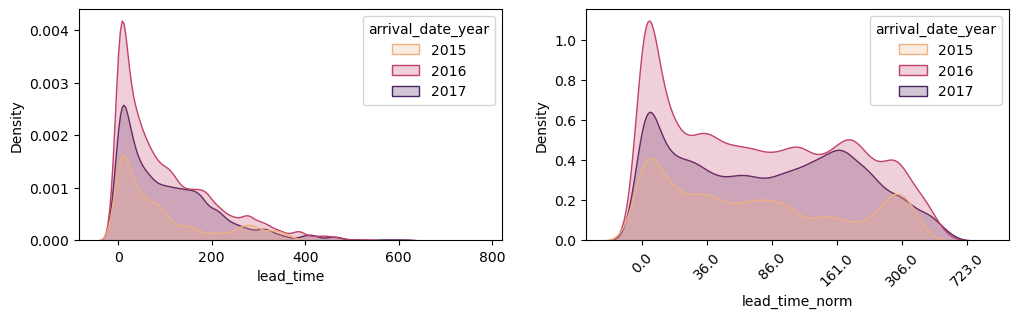

______________________________
stays_in_weekend_nights


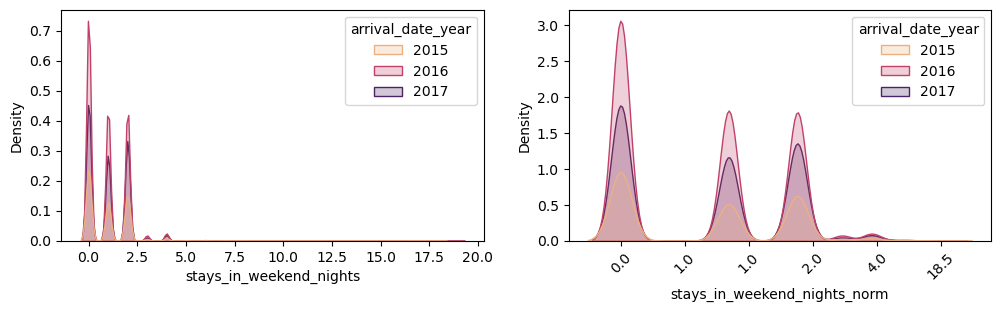

______________________________
stays_in_week_nights


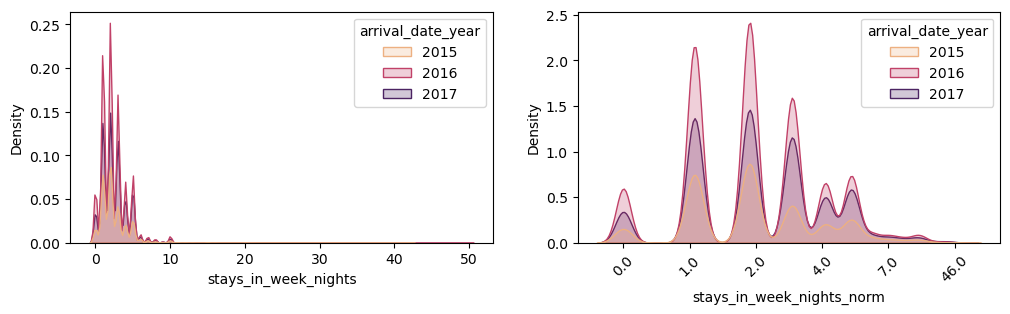

______________________________
adults


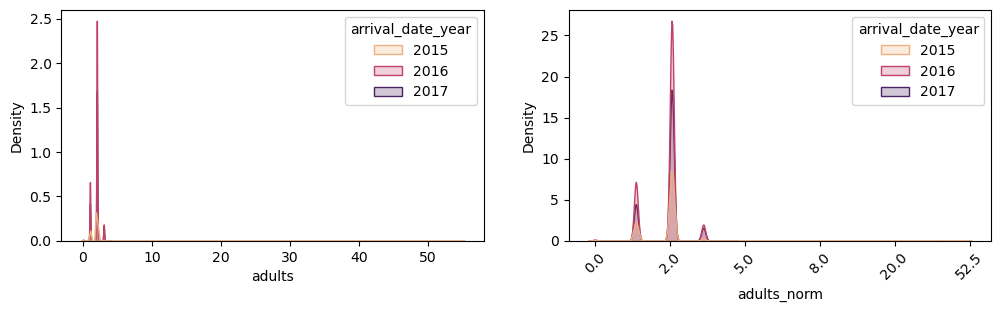

______________________________
booking_changes


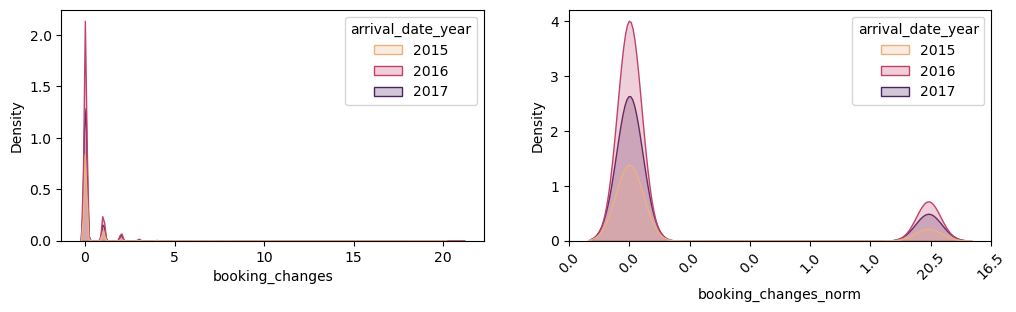

______________________________
adr


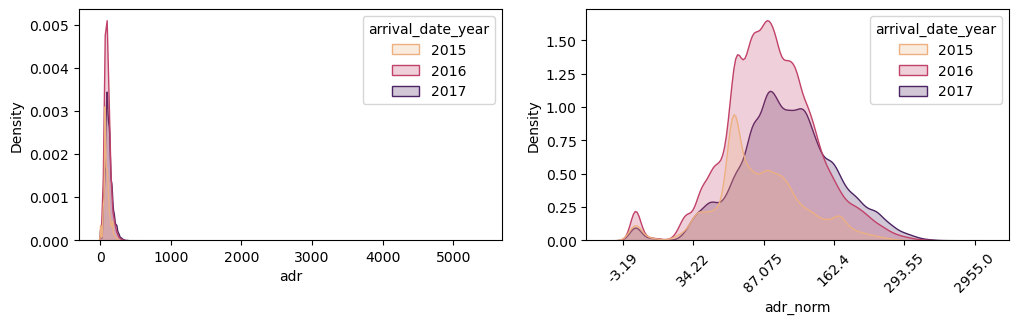

______________________________
required_car_parking_spaces


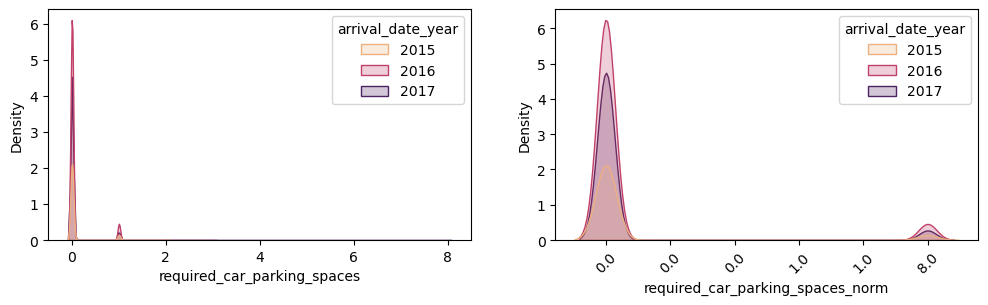

______________________________
total_of_special_requests


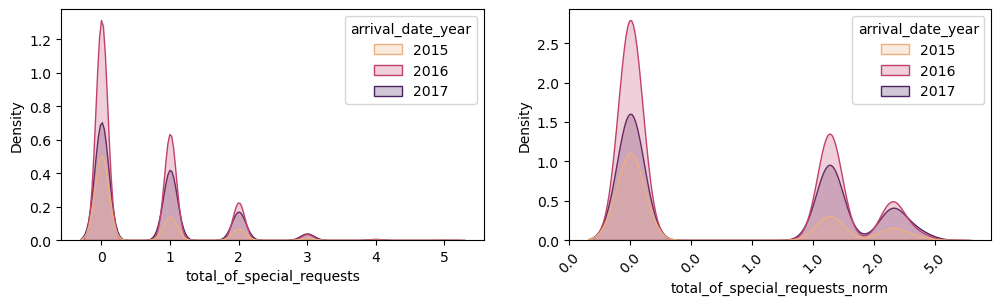

______________________________
Latitude


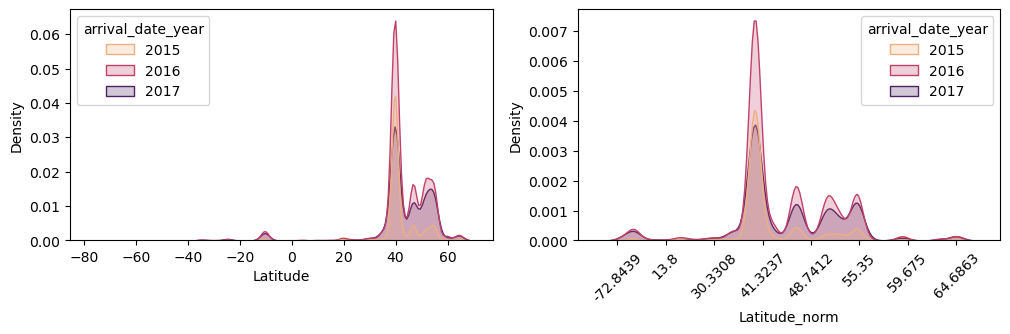

______________________________
Longitude


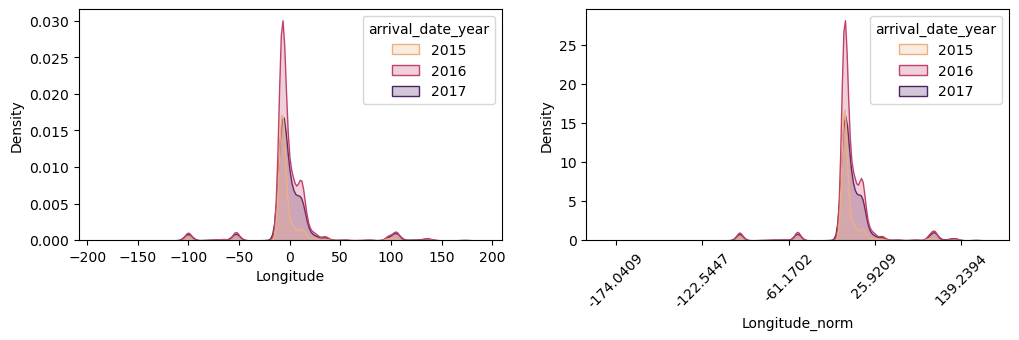

______________________________
diff_reservation_status_change


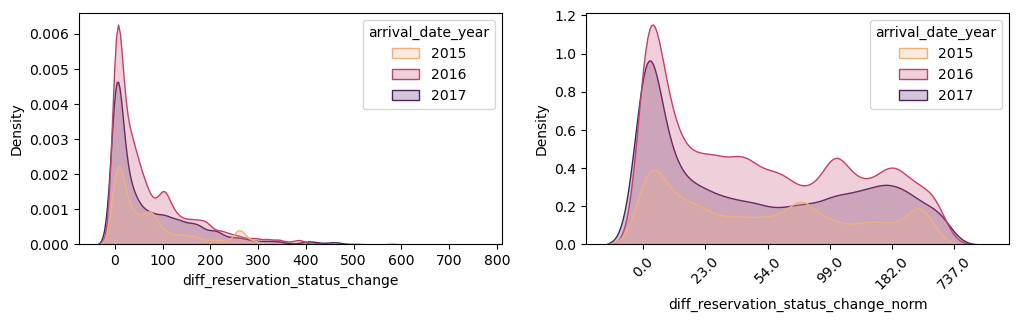

In [76]:
#sort norm_feats to match the typesort_ls order
sorted_norm_feats = sorted(norm_feats, key=all_typesort_ls.index)

#run analysis on allowed features
for i in range(len(sorted_norm_feats)):
    
    #get feature inputs
    feature = sorted_norm_feats[i]
    print("_"*30)
    print(feature)
    feature_norm = feature+"_norm"
    if feature_norm == 'nulls':
        print('NULLS-', feature)
        continue
    
    #create plots for each pair
    dbl_density_plot(df_norm, hue_ax= timevar, xaxis_1=feature, xaxis_2=feature_norm, dist_type='kde',chz_palette='flare')

ADR movement is clearly visible on comparing it over the years

#### 1. Version-For Features w Nulls
normalizer can't handle nulls, so each of these features containing nulls have the null rows dropped in order to show the distributions.

In [77]:
df_nulls_summary

count_all  props_all  obs_all  2015  2016  2017  avgprop_modelingyears
company      112593       0.94   119390  0.94  0.94  0.94                   0.94
agent         16340       0.14   119390  0.14  0.13  0.14                   0.14
children          4       0.00   119390  0.00  0.00  0.00                   0.00

In [78]:
null_feats_w_props = df_nulls_summary[df_nulls_summary['props_all'] != 1.0]
null_feats_w_props

count_all  props_all  obs_all  2015  2016  2017  avgprop_modelingyears
company      112593       0.94   119390  0.94  0.94  0.94                   0.94
agent         16340       0.14   119390  0.14  0.13  0.14                   0.14
children          4       0.00   119390  0.00  0.00  0.00                   0.00

______________________________
children
Null prop:  0.0
______________________________
children
Skew_Val - Raw:   4.11
Skew_Val - Norm:   -3.31
Fitted Lambda:   -103.8


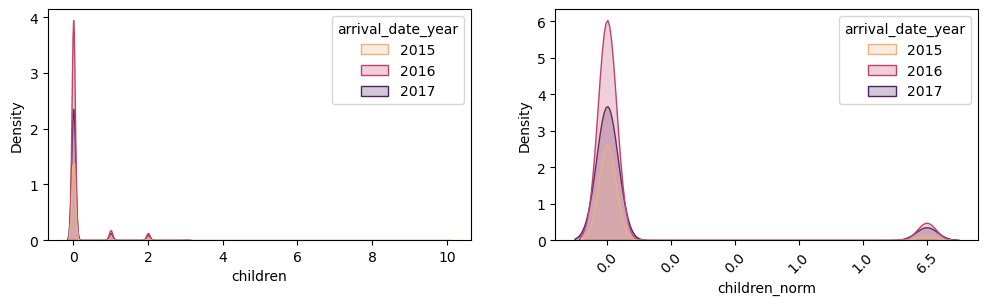

______________________________
agent
Null prop:  0.14
______________________________
agent
Skew_Val - Raw:   1.09
Skew_Val - Norm:   -0.6
Fitted Lambda:   -5.63


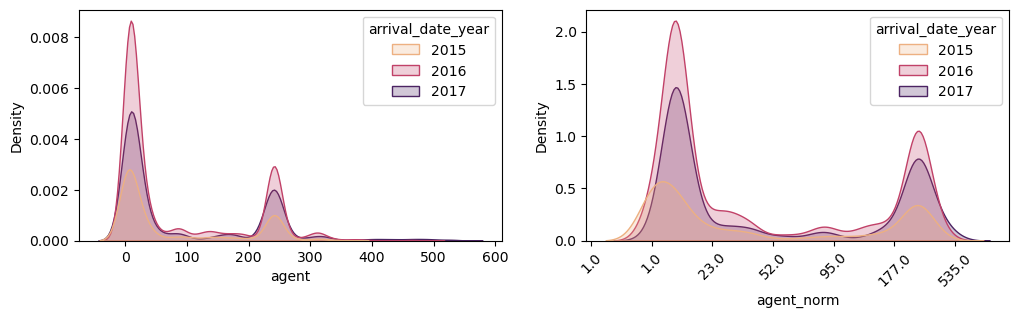

In [79]:
sorted_null_feats = sorted(null_feats, key=all_typesort_ls.index)

for feature in sorted_null_feats: #graph_null_features.index:
    print("_"*30)
    print(feature)
    feature_norm = feature+"_norm"
    print('Null prop: ',round(null_feats_w_props.loc[feature,'props_all'],2))

    df_nulls_del = df[df[feature].notnull()].copy()
    
    df_norm_nulls, _ = normalize_numeric_data(df_nulls_del, [feature], other_identifiers = [timevar, target])
    
    dbl_density_plot(df_norm_nulls, hue_ax=timevar, xaxis_1=feature, xaxis_2=feature_norm, dist_type='kde',chz_palette='flare')

### 6. Graph - Dist Grouped BoxPlot
These graphs are bivariate distribution plots comparing the feature with target.  Same as above, 1 raw and 1 normalized, with arrival year overlayed as the hue. Questions to ask while checking these:
* Does the distribution of the feature over the target make sense, regardless of seasonyear?
* Is there drift from year to year in the in the relationship of the feature to the target suggesting it will continue?
* Are there major difference between one year to the next suggesting incomplete data or some business decision might have changed?

In [80]:
def dbl_multibox_plot(df_in, hue_axis, grp_axis, yaxis_1, yaxis_2):
    from scipy.stats import skew
    '''
    Creates multiple boxplots grouped together by gaxis parameter.  Also includes summary table of
        mean and median of feature. 
        
    Tails are removed from the data (0.5,0.95) to help boxplots show patterns easier.  The exception to this
    is when the majority of the data is a single value which seaborn's boxplot will error out trying to 
    show a constant value after outliers are removed.  When this occurs, the outliers are left in and an
    error will print indicating the outliers left in. 

    df_in: full dataframe
    haxis: this what to be used for the hue and for the sub-boxplots - can either be the target or time
    gaxis: this is for the separate groupings along the x axis - can either be the target or time
    yaxis: these are continuous/count variables for yaxis

    TODO:
    - name of hue (haxis) is added to print statement
    - name of numerical feature on yaxis and of summary table is also in print statement

    '''

    #create index of time with h_axis
    df_in["haxis"] = (df_in[grp_axis].astype(str) + "." + df_in[hue_axis].astype(str)).astype(float)

    print('hue_axis: ',hue_axis)
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12, 6))

        #choose axis vs hue

    sns.boxenplot(x=grp_axis, y=yaxis_1,
            hue=hue_axis, palette='viridis', #ordinal coloring
            data=df_in, ax=ax1)
    
    # sns.boxplot(x=grp_axis, y=yaxis_1,
    #         hue=hue_axis, palette='viridis', #ordinal coloring
    #         data=df_in, ax=ax1)

    try:
        sns.boxenplot(x=grp_axis, y=yaxis_2,
            hue=hue_axis, palette='viridis', #ordinal coloring
            data=df_in, ax=ax2)
        
        # sns.boxplot(x=grp_axis, y=yaxis_2,
        #         hue=hue_axis, palette='viridis', #ordinal coloring
        #         data=df_in, ax=ax2)

        fig.canvas.draw()

        fig_ax2 = fig.get_axes()[1] #2nd plot axis

        # Get index labels, clean and set to float
        ax2_yticks = [t.get_text() for t in fig_ax2.get_yticklabels()]
        ax2_yticks = [float(y[1:])*-1 if y[0]=='−' else float(y) for y in ax2_yticks]

        #pair up labels with closest raw labels and create new list of ticks
        ax2_match_yticks = []
        for val in ax2_yticks:
            df_raw_val = df_in.iloc[(df_in[yaxis_2]-val).abs().argsort()[:2]]
            ax2_match_yticks += [str(df_raw_val[yaxis_1].mean().round(4))]

        #replace norm axis labels with retrieved original raw labels
#         fig_ax2.set_yticklabels(ax2_match_yticks)
        fig_ax2.set_yticklabels(ax2_match_yticks, rotation=45)

        #if the order is increasing, leave as-is, else flip the xaxis to match the order of the original raw axis
        if ax2_match_yticks[0] > ax2_match_yticks[-1]:
            fig_ax2.invert_yaxis()

    except Exception as e: 
        print(e)
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.show()

lead_time
hue_axis:  is_canceled


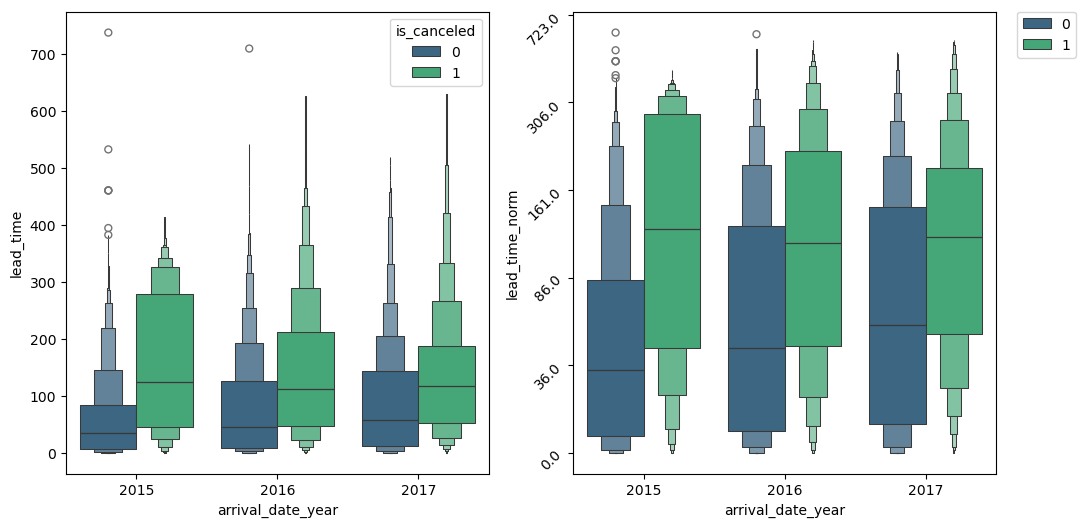

stays_in_weekend_nights
hue_axis:  is_canceled


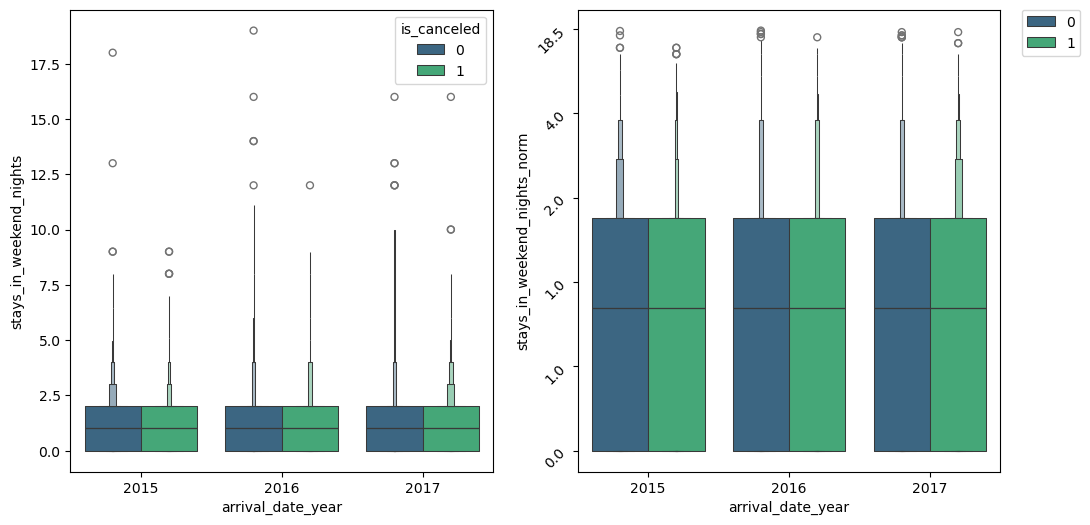

stays_in_week_nights
hue_axis:  is_canceled


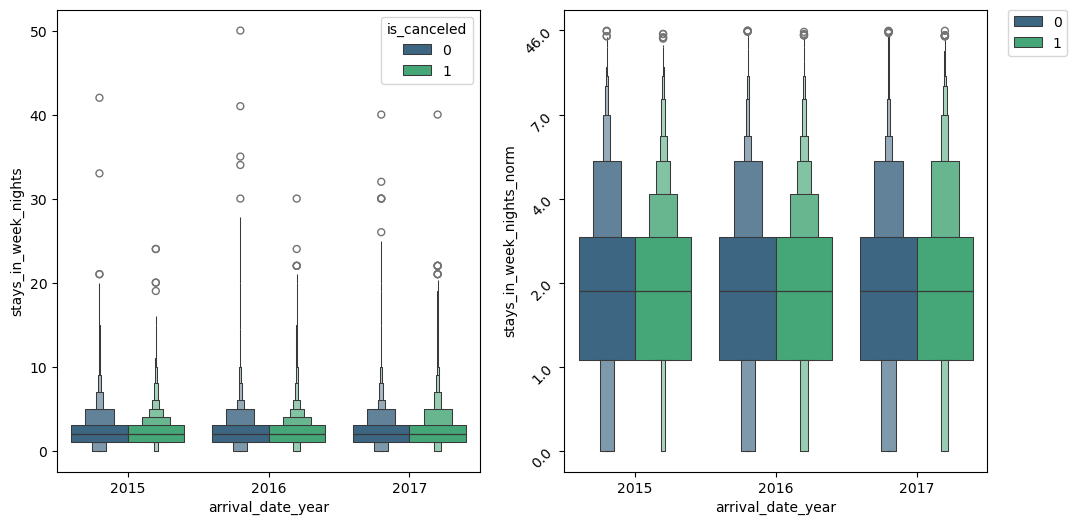

adults
hue_axis:  is_canceled


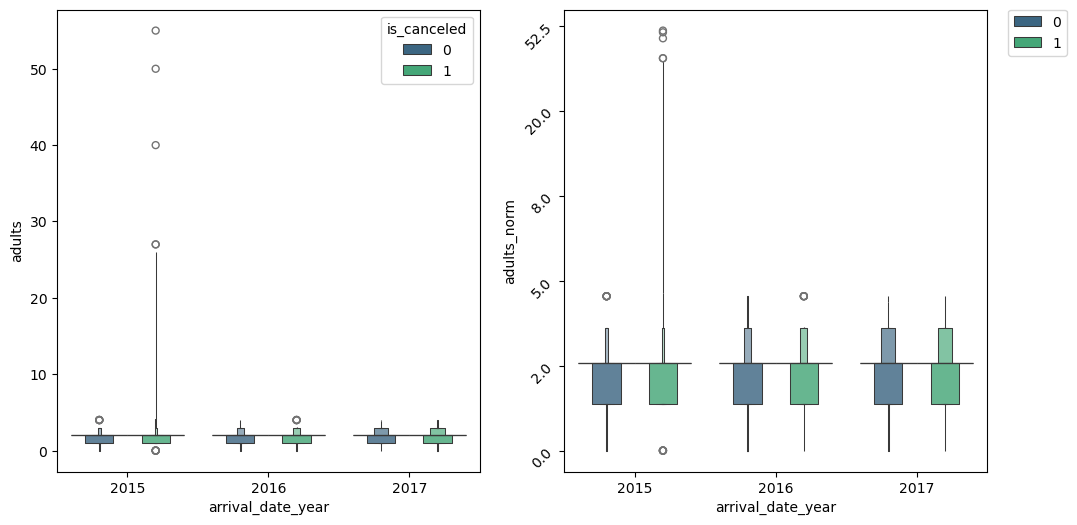

booking_changes
hue_axis:  is_canceled


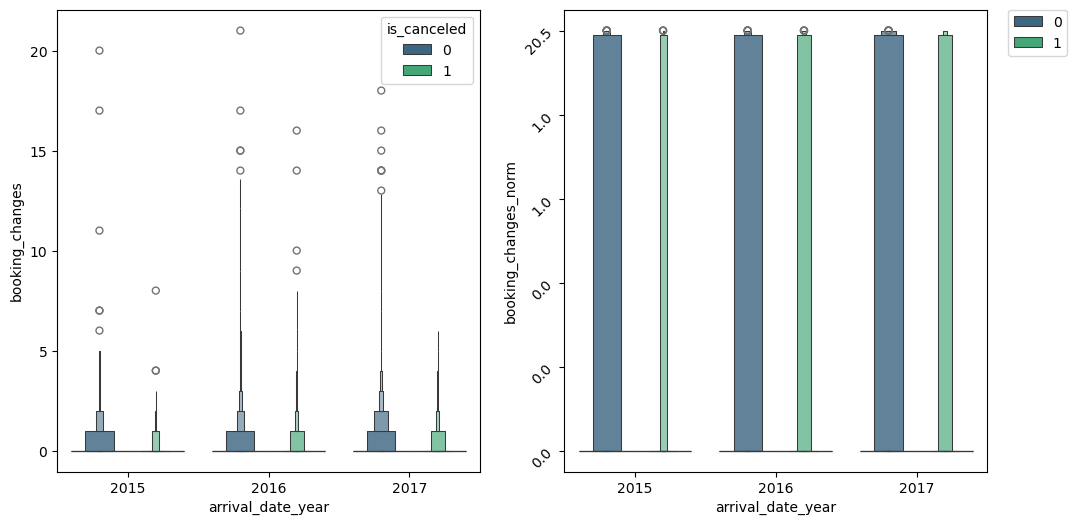

adr
hue_axis:  is_canceled


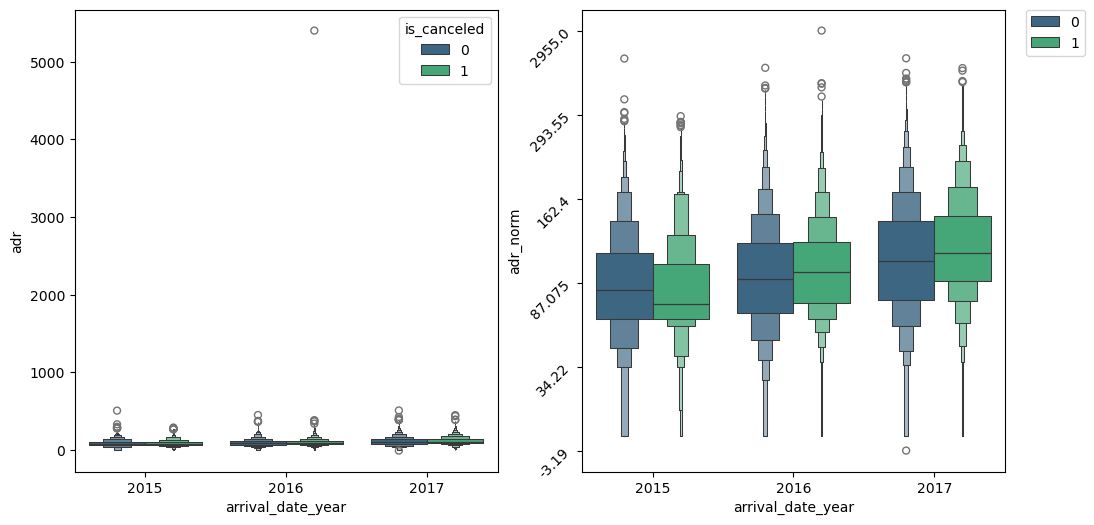

required_car_parking_spaces
hue_axis:  is_canceled


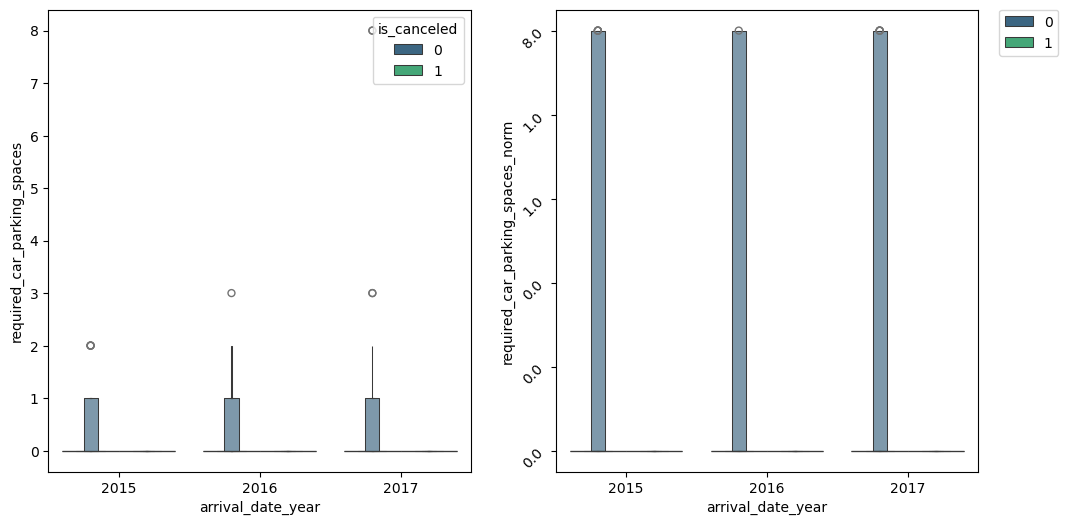

total_of_special_requests
hue_axis:  is_canceled


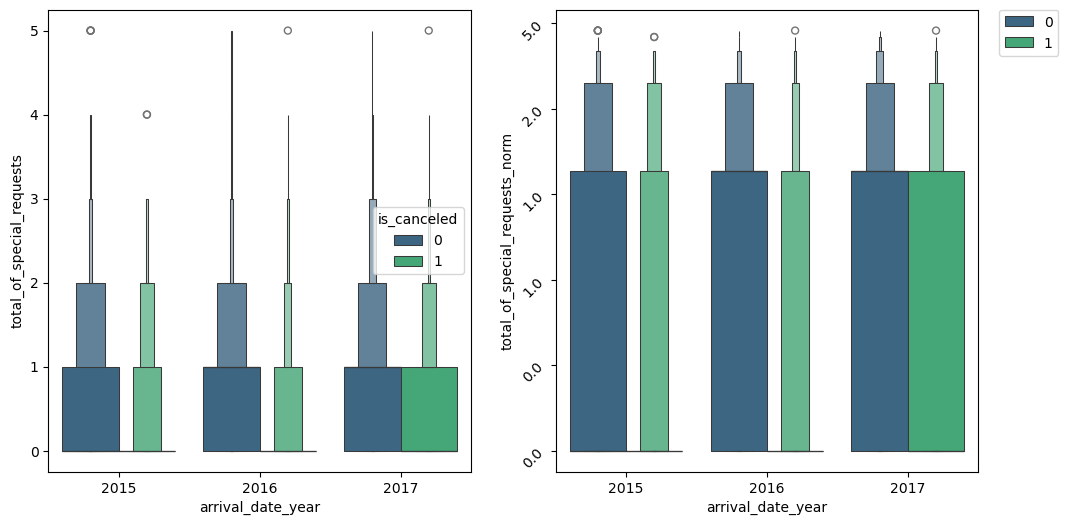

Latitude
hue_axis:  is_canceled


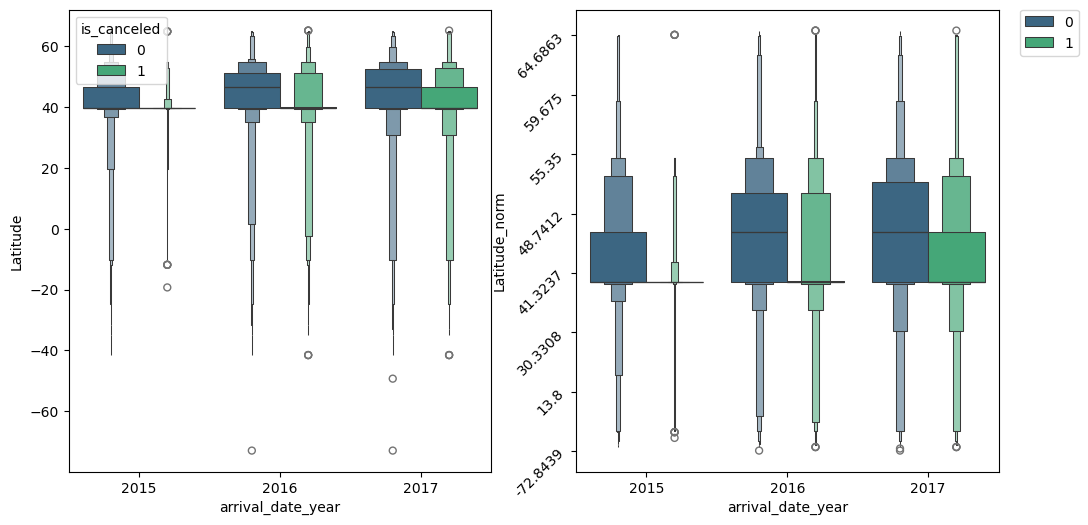

Longitude
hue_axis:  is_canceled


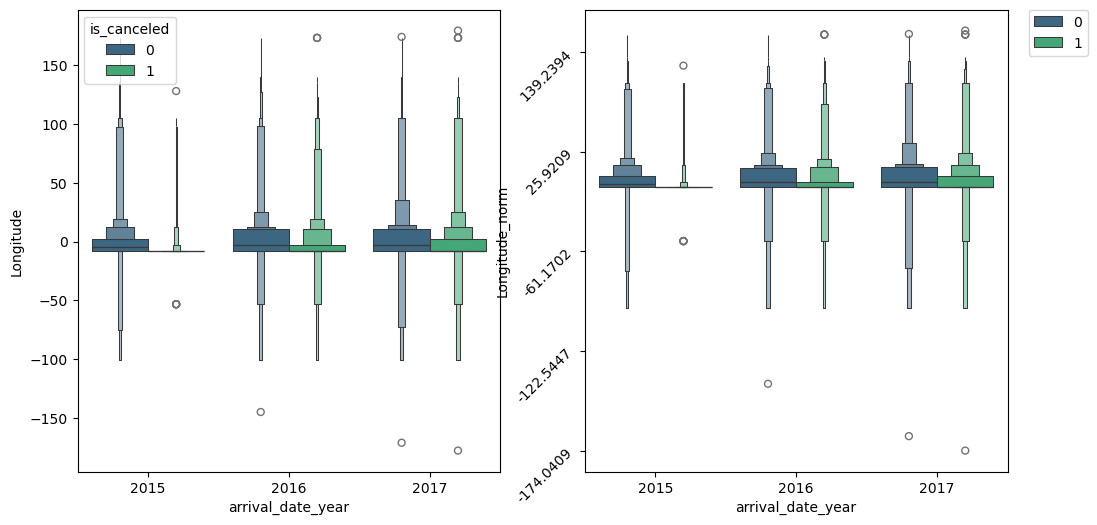

diff_reservation_status_change
hue_axis:  is_canceled


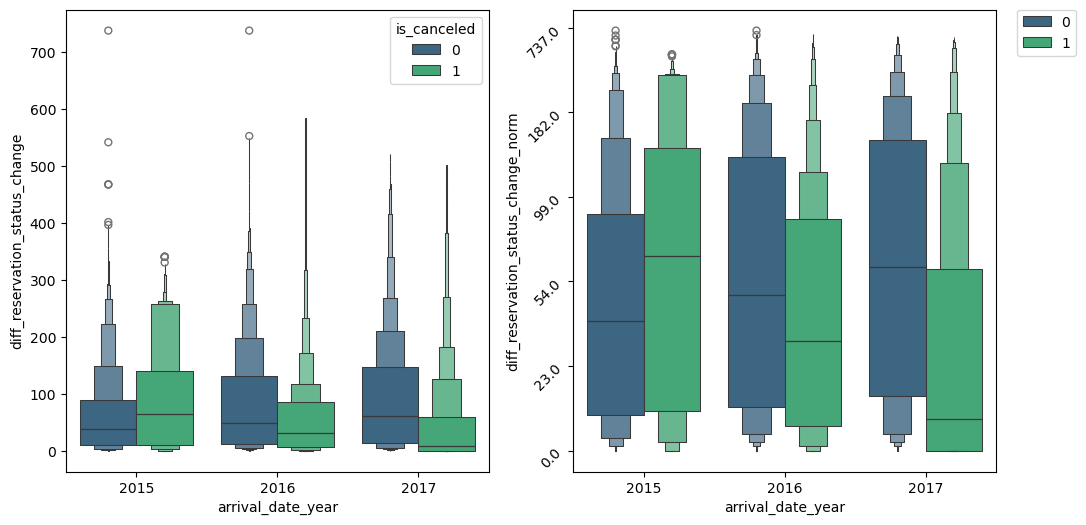

In [81]:
sorted_norm_feats = sorted(norm_feats, key=all_typesort_ls.index)

for i in range(len(sorted_norm_feats)):
    
    #get feature inputs
    feature = sorted_norm_feats[i]
    feature_norm = feature+"_norm"
    print(feature)
    if feature_norm == 'nulls':
        print('NULLS-', feature)
        continue
    
    #create plot
    dbl_multibox_plot(df_norm, hue_axis=target, grp_axis=timevar, yaxis_1=feature, yaxis_2=feature_norm)

High lead time has a positive affect on reservations. Reservations having a higher lead time are less likely to cancel. 
For ADR, in 2015 reservations with higher ADR are more likely to cancel. This effect is reversed for arrival year 2016 and 2017

______________________________
______________________________
children
Skew_Val - Raw:   4.11
Skew_Val - Norm:   -3.31
Fitted Lambda:   -103.8
hue_axis:  is_canceled


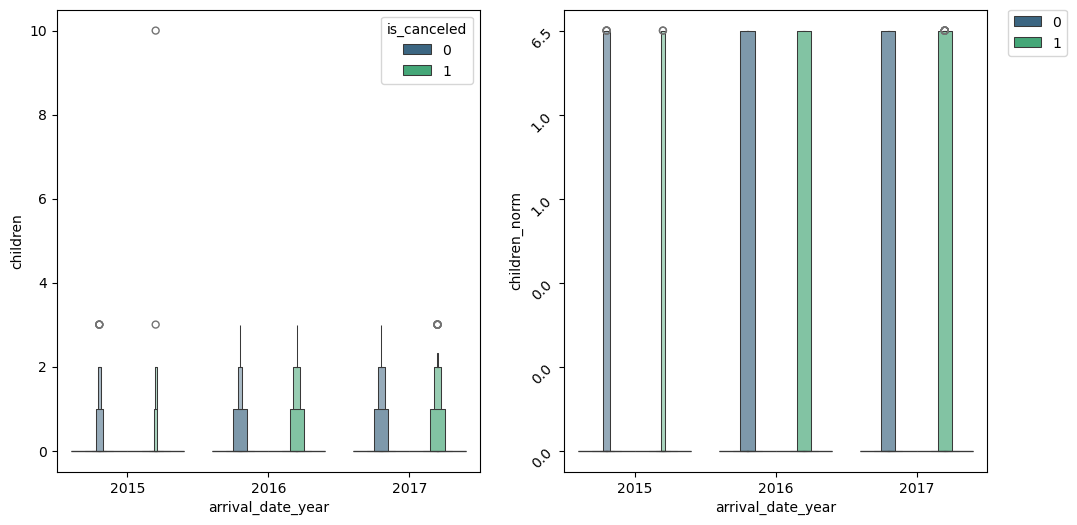

______________________________
______________________________
agent
Skew_Val - Raw:   1.09
Skew_Val - Norm:   -0.6
Fitted Lambda:   -5.63
hue_axis:  is_canceled


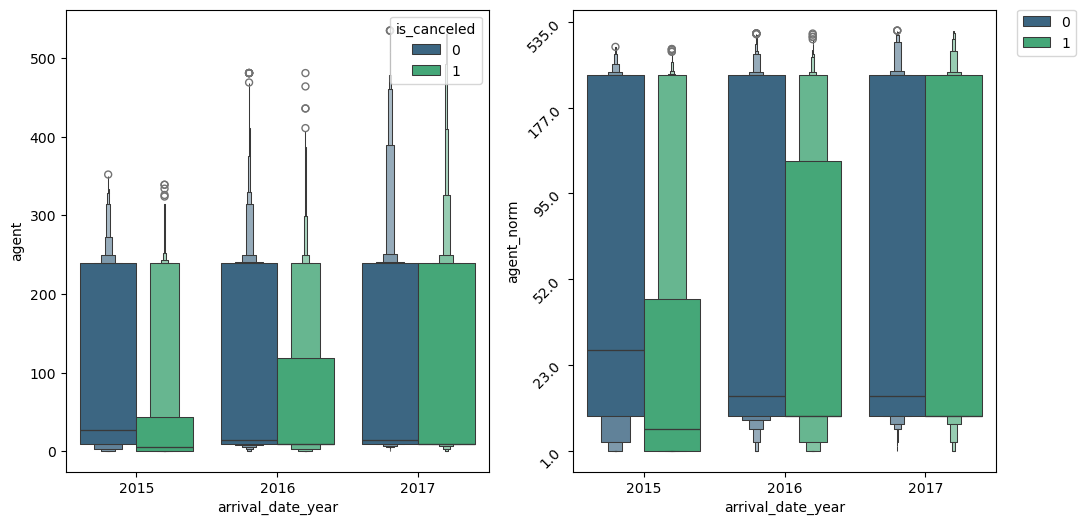

______________________________
______________________________
company
Skew_Val - Raw:   0.6
Skew_Val - Norm:   -0.07
Fitted Lambda:   -1.04
hue_axis:  is_canceled


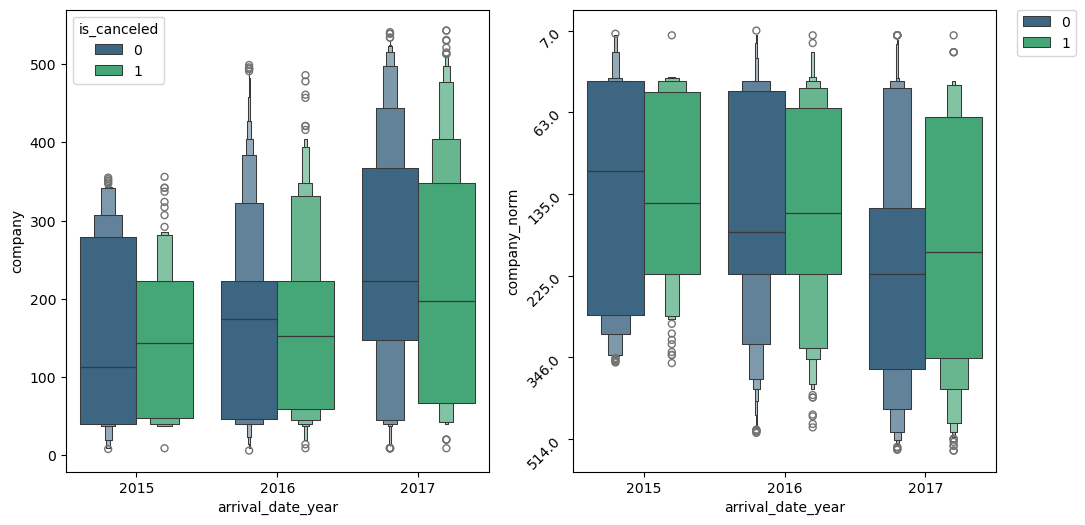

In [82]:
sorted_null_feats_w_props = sorted(list(null_feats_w_props.index), key=all_typesort_ls.index)
#null boxy plots
for feature in sorted_null_feats_w_props:
    print("_"*30)
    feature_norm = feature+"_norm"

    df_nulls_del = df[df[feature].notnull()].copy()
    
    df_norm_nulls, _ = normalize_numeric_data(df_nulls_del, [feature], other_identifiers = [timevar, target])
    
    #create plot
    dbl_multibox_plot(df_norm_nulls, hue_axis=target, grp_axis=timevar, yaxis_1=feature, yaxis_2=feature_norm)

## 8. Categorical

In [83]:
print(len(bool_ls), len(cat_ls))

2 9


In [84]:
df[cat_ls].nunique().sort_values()

deposit_type             3
reservation_status       3
meal                     4
customer_type            4
distribution_channel     5
market_segment           8
reserved_room_type      10
arrival_date_month      12
assigned_room_type      12
dtype: int64

In [85]:

for c in cat_ls:
    print(30*'_')
    display(df[c].value_counts().sort_index(ascending=True))

______________________________


arrival_date_month
1      5929
2      8068
3      9794
4     11089
5     11791
6     10939
7     12661
8     13877
9     10508
10    11160
11     6794
12     6780
Name: count, dtype: int64

______________________________


meal
0    11819
1    92310
2    14463
3      798
Name: count, dtype: int64

______________________________


market_segment
Aviation           237
Complementary      743
Corporate         5295
Direct           12606
Groups           19811
Offline TA/TO    24219
Online TA        56477
Undefined            2
Name: count, dtype: int64

______________________________


distribution_channel
Corporate     6677
Direct       14645
GDS            193
TA/TO        97870
Undefined        5
Name: count, dtype: int64

______________________________


reserved_room_type
A    85994
B     1118
C      932
D    19201
E     6535
F     2897
G     2094
H      601
L        6
P       12
Name: count, dtype: int64

______________________________


assigned_room_type
A    74053
B     2163
C     2375
D    25322
E     7806
F     3751
G     2553
H      712
I      363
K      279
L        1
P       12
Name: count, dtype: int64

______________________________


deposit_type
No Deposit    104641
Non Refund     14587
Refundable       162
Name: count, dtype: int64

______________________________


customer_type
Contract            4076
Group                577
Transient          89613
Transient-Party    25124
Name: count, dtype: int64

______________________________


reservation_status
Canceled     43017
Check-Out    75166
No-Show       1207
Name: count, dtype: int64

In [86]:

#check value counts by seasonyear

for c in cat_ls:
    print(30*'_')
    print(c)
    display(
        pd.crosstab(df[c],df[timevar]) \
            .style.format(precision=2,thousands=',') \
            .background_gradient(cmap='BuGn', axis=None),
       '*null cnts:', 
       pd.DataFrame(df[c].isnull().groupby(df[timevar]).sum()).T \
        .style.format(precision=2,thousands=',') \
        .background_gradient(cmap='PuBu', axis=None)
    )



______________________________
arrival_date_month


'*null cnts:'

______________________________
meal


'*null cnts:'

______________________________
market_segment


'*null cnts:'

______________________________
distribution_channel


'*null cnts:'

______________________________
reserved_room_type


'*null cnts:'

______________________________
assigned_room_type


'*null cnts:'

______________________________
deposit_type


'*null cnts:'

______________________________
customer_type


'*null cnts:'

______________________________
reservation_status


'*null cnts:'

In [87]:

#check value counts by seasonyear

for c in cat_ls:
    print(30*'_')
    print(c)
    display(
        pd.crosstab(df[c],df[target]) \
            .style.format(precision=2,thousands=',') \
            .background_gradient(cmap='BuGn', axis=None),
       '*null cnts:', 
       pd.DataFrame(df[c].isnull().groupby(df[target]).sum()).T \
        .style.format(precision=2,thousands=',') \
        .background_gradient(cmap='PuBu', axis=None)
    )



______________________________
arrival_date_month


'*null cnts:'

______________________________
meal


'*null cnts:'

______________________________
market_segment


'*null cnts:'

______________________________
distribution_channel


'*null cnts:'

______________________________
reserved_room_type


'*null cnts:'

______________________________
assigned_room_type


'*null cnts:'

______________________________
deposit_type


'*null cnts:'

______________________________
customer_type


'*null cnts:'

______________________________
reservation_status


'*null cnts:'

Higher cancellations on Group type bookings. This should be further investigated
Non refundable reservations have a higher chance of cancllations

In [88]:
for b in bool_ls:
    print("_"*30)
    print(b)
    display(
        pd.crosstab(df[b],df[timevar]) \
            .style.format(precision=2,thousands=',') \
            .background_gradient(cmap='BuGn', axis=None),
        '*null cnts:', 
       pd.DataFrame(df[b].isnull().groupby(df[timevar]).sum()).T \
        .style.format(precision=2,thousands=',') \
        .background_gradient(cmap='PuBu', axis=None)
    )

______________________________
got_desired_room


'*null cnts:'

______________________________
is_city_hotel


'*null cnts:'

In [89]:
for b in bool_ls:
    print("_"*30)
    print(b)
    display(
        pd.crosstab(df[b],df[target]) \
            .style.format(precision=2,thousands=',') \
            .background_gradient(cmap='BuGn', axis=None),
        '*null cnts:', 
       pd.DataFrame(df[b].isnull().groupby(df[target]).sum()).T \
        .style.format(precision=2,thousands=',') \
        .background_gradient(cmap='PuBu', axis=None)
    )



______________________________
got_desired_room


'*null cnts:'

______________________________
is_city_hotel


'*null cnts:'

People are more likely to cancel a city hotel than a resort hotel

In [90]:
final_removal_ls = [
'reservation_status',
'arrival_date_month',
'assigned_room_type',
'booking_changes'
]

print('num ',len(num_ls),'cat ', len(cat_ls),'bool ', len(bool_ls) )
# print('hfz ', len(hfzeros_ls))

for c in final_removal_ls:
    try:
        num_ls.remove(c)
        print('num_ls - removed: ',c)
    except:
        try:  
            cat_ls.remove(c)
            print('cat_ls - removed: ',c)
        except:
            try:  
                bool_ls.remove(c)
                print('bool_ls - removed: ',c)
            except:
                print('NotInLists: ',c)
                continue
print('num ',len(num_ls),'cat ', len(cat_ls),'bool ', len(bool_ls) )

num  13 cat  9 bool  2
cat_ls - removed:  reservation_status
cat_ls - removed:  arrival_date_month
cat_ls - removed:  assigned_room_type
num_ls - removed:  booking_changes
num  12 cat  6 bool  2


Columns are removed to avoid data leakage

In [91]:
display(
    id_ls,
    num_ls,
    cat_ls,
    bool_ls
)

['is_canceled', 'arrival_date_year']

['lead_time',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'agent',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'Latitude',
 'Longitude',
 'diff_reservation_status_change']

['meal',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'deposit_type',
 'customer_type']

['got_desired_room', 'is_city_hotel']

In [92]:
# removed features
display(
    '_'*30,
    r'Null Cols Removed:  ',
    '',
    null_col_rmv_ls,
    '_'*30,
    'const cols Removed:  ',
    '',
    const_cols,
    '_'*30,
    'HFZ Cols Removed:  ',
    '',
    hfzeros_ls,
    '_'*30,
    r'Final Removal Cols Removed:  ',
    '',
    final_removal_ls
    
)

'______________________________'

'Null Cols Removed:  '

''

['company']

'______________________________'

'const cols Removed:  '

''

[]

'______________________________'

'HFZ Cols Removed:  '

''

['babies', 'previous_bookings_not_canceled', 'days_in_waiting_list']

'______________________________'

'Final Removal Cols Removed:  '

''

['reservation_status',
 'arrival_date_month',
 'assigned_room_type',
 'booking_changes']

# 6. Model Prep

In [93]:
import os
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import time

import lightgbm as lgb

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_validate
from sklearn.model_selection import learning_curve, validation_curve, cross_val_score, ShuffleSplit
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_selector,make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, brier_score_loss, roc_auc_score, f1_score
from sklearn.metrics import make_scorer, recall_score, matthews_corrcoef, fbeta_score
from sklearn import metrics

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

from sklearn.calibration import calibration_curve, CalibratedClassifierCV

import category_encoders as ce

from functools import partial
# import plotly
import optuna
import shap

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from sklearn.feature_selection import RFECV
from sklearn.ensemble import ExtraTreesRegressor

#for pipeline viz
from sklearn import set_config                      # to change the display
from sklearn.utils import estimator_html_repr       # to save the diagram into HTML format
from IPython.display import display, HTML           # to visualize pipeline

from copy import deepcopy

import pickle

from datetime import datetime
import time
set_config(display='diagram')


%matplotlib inline

## Model Prep Functions

In [94]:
def fix_col_names(df):
    '''
    takes a df and converts column names to lowercase underscore seperated, modifies the dataframe directly.
    '''
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    return df



def plot_validation_curve(estimator, param_name, param_range, X, y, cv=None, n_jobs=1, ylim=None, scorer=""):
    from sklearn.model_selection import validation_curve
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    """ Generate a simple plot of the test and training diagnostic curve. 
    Parameters- 
    estimator : object type that implements the "fit" and "predict" methods An object of that type 
        which is cloned for each validation.  
    X : array-like, shape (n_samples, n_features) Training vector, where n_samples is the number 
        of samples and n_features is the number of features. 
    y : array-like, shape (n_samples) or (n_samples, n_features), optional Target relative to X for classification or regression; None for unsupervised learning. 
    ylim : tuple, shape (ymin, ymax), optional Defines minimum and maximum yvalues plotted. 
    cv : integer, cross-validation generator, optional If an integer is passed, it is the number of folds (defaults to 3). 
    Specific cross-validation objects can be passed, see sklearn.cross_validation module for the list of possible objects 
    n_jobs : integer, optional Number of jobs to run in parallel (default 1). 
    
    Output- automatically printed 
    """ 
#This works pretty well, but small samples are volatile shown be repeated runs.  
# Future development, bootstrap the runs 100 times get an average performance. 
    
    if scorer == "":
        train_scores, test_scores = validation_curve(estimator, 
                                                     X, 
                                                     y, 
                                                     param_name="n_estimators", 
                                                     param_range=param_range,
                                                     cv=cv, 
                                                     n_jobs=n_jobs)
    else:
        train_scores, test_scores = validation_curve(estimator, 
                                                     X, 
                                                     y, 
                                                     param_name="n_estimators", 
                                                     param_range=param_range,
                                                     cv=cv, 
                                                     scoring=scorer,
                                                     n_jobs=n_jobs)

    # Calculate mean and standard deviation for training set scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for test set scores
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
 
    plt.grid()

    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color="darkorange")  
    plt.plot(param_range, train_scores_mean, 'o-', color="darkorange", label="Training score") 
    
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="b")
    plt.plot(param_range, test_scores_mean, 'o-', color="b", label="Cross-validation score")
   
    # Create plot
    plt.title("Validation Curve:  "+param_name)
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.tight_layout()
    plt.legend(loc="best")
    plt.show()


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5),scorer=""):
    
    from sklearn.model_selection import learning_curve
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt 
    
    """ Generate a simple plot of the test and traning learning curve. 
    Parameters ---------- estimator : 
    object type that implements the "fit" and "predict" methods An object of that type which is cloned for each validation. 
    title : string Title for the chart. 
    X : array-like, shape (n_samples, n_features) Training vector, where n_samples is the number of samples and n_features is the number of features. 
    y : array-like, shape (n_samples) or (n_samples, n_features), optional Target relative to X for classification or regression; None for unsupervised learning. 
    ylim : tuple, shape (ymin, ymax), optional Defines minimum and maximum yvalues plotted. 
    cv : integer, cross-validation generator, optional If an integer is passed, it is the number of folds (defaults to 3). 
    Specific cross-validation objects can be passed, see sklearn.cross_validation module for the list of possible objects 
    n_jobs : integer, optional Number of jobs to run in parallel (default 1). 
    
    Returns- plot object, no assignment produces plot 
    """ 
#     t_start = timer()
    
    plt.figure() 
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim) 
    plt.xlabel("Training examples") 
    plt.ylabel("Score")
    if scorer == "":
        train_sizes, train_scores, test_scores = learning_curve(
            estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    else:
        train_sizes, train_scores, test_scores = learning_curve(
            estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = scorer) 
    train_scores_mean = np.mean(train_scores, axis=1) 
    train_scores_std = np.std(train_scores, axis=1) 
    test_scores_mean = np.mean(test_scores, axis=1) 
    test_scores_std = np.std(test_scores, axis=1) 
    plt.grid() 
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                     train_scores_mean + train_scores_std, alpha=0.1, color="r") 
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, 
                     test_scores_mean + test_scores_std, alpha=0.1, color="g") 
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score") 
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score") 
    plt.legend(loc="best")
    
#     print('runtime(secs):\t', round(timer() - t_start))
    
    return plt 
title = ""

def plot_confusion_matrix(y_true, y_pred, classes, cm=None, normalize=False, title=None, cmap=plt.cm.Blues):
    from sklearn.metrics import confusion_matrix
    import pandas as pd
    import numpy as np

    import matplotlib.pyplot as plt

    """ This function prints a plot of a confusion matrix Plot is an NxN matrix of predictions versus actuals,
        the darker the blue, the higher the agreement between actuals and predictions. Normalization can be
        applied by setting `normalize=True`.
    parameters -
    y_true : array of actual labels to compare to
    y_pred : array of predicted labels for comparison
    classes : actual list of classes available in y_true. Must be set ordinally
    normalize : predictions are divided horizontail by actuals when True
    title : add title for predicting if needed
    cmap : color set for graph, default is blue
    returs- 
    ax, fig : to be used in displaying graph.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    if cm is None:
        # Compute confusion matrix if not provided
        cm = confusion_matrix(y_true, y_pred)
        
    # Only use the labels that appear in the data
    #     classes = classes[unique_labels(y_true, y_pred)]

    if normalize: 
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    #plot setup
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    if normalize:
        fmt = '.2f'  # Floating point format
    else:
        fmt = '.0f' if cm.dtype == 'float' else 'd'  # Use integer format if not float, else force to zero decimal float

    # fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax, fig

def create_plot_conf_matrix(y_test, yp_test, target_labels,cm):
    """ This function calls plot_confusion_matrix twice, once for raw and another for normalize
        to regularly display the two plots in a standardized way.
    Args: 
        y_true : array of actual labels to compare to
        y_pred : array of predicted labels for comparison
        classes : actual list of classes available in y_true. Must be set ordinally
    returns: no return, automatically displays when run
    """
    
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 5
    fig_size[1] = 4
    plt.rcParams["figure.figsize"] = fig_size
    # np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plot_confusion_matrix(y_test, yp_test, classes=target_labels, cm=cm,
                          title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plot_confusion_matrix(y_test, yp_test, classes=target_labels, cm=cm, normalize=True,
                          title='Normalized confusion matrix')
    plt.show()


def plot_featimp_w_nullfill(feature_importances, feature_names, null_cols=pd.Series(float), display_cols=40):
    """
    Plots the feature importance as a bar graph from most important to least important.  If a column has nulls
    it will be colored darker shades the more nulls there are. 
    Args:
        feature_importances : feature importance scores output from sklearn
        feature_names : the original feature names read into sklearn
        null_cols : a pandas series with features as index and data as % missing values for each feature
    display_cols : the number of top rank columns to display in the bar graph.
    returns - none, plot automatically displays
    """
    
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 8
    plt.rcParams["figure.figsize"] = fig_size
    #get feature importance and format

    #order the columns from high to low
    sorted_importances = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)
    sorted_importances.rename("feat_imps",inplace=True)
    
    
    if len(null_cols) > 0:
        #combine the % nulls for columns missing values
        feature_nullimp = pd.merge(null_cols,sorted_importances,left_index=True,right_index=True,how='outer')
        feature_nullimp = feature_nullimp.dropna(subset=['feat_imps'])
        feature_nullimp = feature_nullimp.sort_values('feat_imps', ascending=False).head(display_cols)

        #TODO - COLORBAR BROKE - NEED TO FIX AT SOME POINT
        # hack used with plot to steal continuous scale for feature importance plot
        # plot = plt.scatter(feature_nullimp.index,feature_nullimp['null_perc'], c=feature_nullimp['null_perc'], cmap='Reds')
        # plt.clf()
        # plt.colorbar(plot)

        #feature importance plot with null highlight
        ax = sns.barplot(y=feature_nullimp.index, x=feature_nullimp['feat_imps'], hue=feature_nullimp['null_perc'], palette='Reds',
                         data=feature_nullimp, dodge=False)
        ax.legend_.remove()
    
    else:
        sorted_importances = pd.DataFrame(sorted_importances).head(display_cols)
        ax = sns.barplot(y=sorted_importances.index, x=sorted_importances['feat_imps'], palette='Reds_d',
                         data=sorted_importances, dodge=False)
        
    print('NOTE-plot only shows top 40 features. change display_cols if needed')
    plt.show()
    
    
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop


def correlations_threshhold(df, threshhold=0.8,less_than=False,absolute=True,pair_list=False):
    '''
    Get correlations between numeric varibales and filter correlations on input threshold or absolute value or both.
    '''
    if pair_list == True:
        if absolute:
            au_corr = df.corr().abs().unstack()
            labels_to_drop = get_redundant_pairs(df)
            au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
            if less_than:
                au_corr_threshhold=au_corr[au_corr < threshhold]
                High_correlation_list = au_corr_threshhold.reset_index()[['level_0','level_1']].values.tolist()
                return High_correlation_list

            else:
                au_corr_threshhold=au_corr[au_corr > threshhold]
                High_correlation_list = au_corr_threshhold.reset_index()[['level_0','level_1']].values.tolist()
                return High_correlation_list
        else:        
            au_corr = df.corr().unstack()
            labels_to_drop = get_redundant_pairs(df)
            au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
            au_corr_threshhold=au_corr[(au_corr < -threshhold)|(au_corr >threshhold)]
            High_correlation_list = au_corr_threshhold.reset_index()[['level_0','level_1']].values.tolist()
            return High_correlation_list
            
    if pair_list == False:
        if absolute:
            au_corr = df.corr().abs().unstack()
            labels_to_drop = get_redundant_pairs(df)
            au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
            if less_than:
                au_corr_threshhold=au_corr[au_corr < threshhold]
                return au_corr_threshhold

            else:
                au_corr_threshhold=au_corr[au_corr > threshhold]
                return au_corr_threshhold
        else:        
            au_corr = df.corr().unstack()
            labels_to_drop = get_redundant_pairs(df)
            au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
            au_corr_threshhold=au_corr[(au_corr < -threshhold)|(au_corr >threshhold)]
            return au_corr_threshhold


In [95]:
#training years for the model
FITYEARS = [2015,2016]

In [96]:
#shuffling the data set
df = df.sample(frac=1,random_state=222).reset_index(drop=True).copy()

## SPLITS - Model/Future Years

In [97]:
#split out fit year to fit, save all years for diagnostics

SEASONYEAR = timevar
print(df.shape)

df_allYear = df.copy()
df = df[df[SEASONYEAR].isin(FITYEARS)].copy()
print(df.shape, df_allYear.shape)

df[SEASONYEAR].value_counts()

(119390, 41)
(78703, 41) (119390, 41)


arrival_date_year
2016    56707
2015    21996
Name: count, dtype: int64

In [98]:
#id columns to match fit
df_id = df[id_ls]
print(df_id.shape)


num_attribs = num_ls
bool_attribs = bool_ls
cat_attribs = cat_ls

display(id_ls,num_attribs, bool_attribs, cat_attribs)

(78703, 2)


['is_canceled', 'arrival_date_year']

['lead_time',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'agent',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'Latitude',
 'Longitude',
 'diff_reservation_status_change']

['got_desired_room', 'is_city_hotel']

['meal',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'deposit_type',
 'customer_type']

In [99]:
## Remove these for model prep to avoid data leakage
num_attribs.remove('diff_reservation_status_change')
bool_attribs.remove('got_desired_room')

## SPLITS - TrainValidTest

In [100]:

MAKE_VAL_SET = True 
TEST_SIZE = .3
TUNE_SIZE = 3000 

dfX, dfy = df.drop(target,axis=1), df[target]
print(dfX.shape)

print('num_attribs: ',len(num_attribs))
print('bool_attribs: ',len(bool_attribs))
print('cat_attribs: ',len(cat_attribs))

#reorder cats to the back
dfX = dfX[num_attribs+bool_attribs+cat_attribs+[SEASONYEAR]]

#======== train test split ===========
dfX_train, dfX_test, dfy_train, dfy_test, dfid_train, dfid_test = train_test_split(dfX, dfy, df_id, test_size=TEST_SIZE, stratify=dfy, random_state=123)

print('_____________________________')
print('train / valid+test')
print(dfX_train.shape,'/',dfX_test.shape)
print('\ntrain target class counts:')
print(dfy_train.value_counts())

#========= test valid split ===========
if MAKE_VAL_SET:
   
    dfX_valid, dfX_test, dfy_valid, dfy_test, dfid_valid, dfid_test = train_test_split(dfX_test, dfy_test, dfid_test, test_size=.4, stratify=dfy_test, random_state=123)
    print('_____________________________')
    print('valid / test')
    print(dfX_valid.shape,dfX_test.shape)
    print('\nvalid target class counts:')
    print(dfy_valid.value_counts())
    
print('\ntest target class counts:')
print(dfy_test.value_counts())

#========= tune set ============
if TUNE_SIZE >= dfX_train.shape[0]: #set to train if greater than or equal to
    dfX_tune, dfy_tune, dfid_tune = dfX_train, dfy_train, dfid_train
else:
    _, dfX_tune, _, dfy_tune, _, dfid_tune = train_test_split(dfX_train, dfy_train, dfid_train, test_size=TUNE_SIZE, stratify=dfy_train, random_state=123)

print('_____________________________')
print('train / -tune')

print(dfX_train.shape,dfX_tune.shape)
print('\ntune target class counts')
print(dfy_tune.value_counts())



(78703, 40)
num_attribs:  11
bool_attribs:  1
cat_attribs:  6
_____________________________
train / valid+test
(55092, 19) / (23611, 19)

train target class counts:
is_canceled
0    35157
1    19935
Name: count, dtype: int64
_____________________________
valid / test
(14166, 19) (9445, 19)

valid target class counts:
is_canceled
0    9040
1    5126
Name: count, dtype: int64

test target class counts:
is_canceled
0    6027
1    3418
Name: count, dtype: int64
_____________________________
train / -tune
(55092, 19) (3000, 19)

tune target class counts
is_canceled
0    1914
1    1086
Name: count, dtype: int64


In [101]:
#calculate class weights
from collections import Counter

def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: round(float(majority)/float(count), 2) for cls, count in counter.items()}

class_weights = get_class_weights(dfy_train)
class_weights

{1: 1.76, 0: 1.0}

## Features for ohot encode

In [102]:
#selecting features for one hot encoding
def select_oHot_highCard_features(df, cat_attribs):

    ohot_attribs = df[cat_attribs]\
            .apply(lambda col: col.nunique())\
            .loc[lambda x: (x <= 30) & (x>2)]\
            .index\
            .tolist()
    print('_______________________________________')
    print('cat_attribs count:',len(cat_attribs))
    print(cat_attribs)

    print('_______________________________________')

    print('ohot_attribs count:',len(ohot_attribs))
    print(ohot_attribs)

    
    
    return ohot_attribs

ohot_attribs = select_oHot_highCard_features(dfX_train,cat_attribs)

_______________________________________
cat_attribs count: 6
['meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type']
_______________________________________
ohot_attribs count: 6
['meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type']


## Diagnostics Setup
Setting up functions to create pipelines for training and validating the model

In [103]:

def get_pipeline_features(model_obj,transformer_pipelines):
    '''
    Pairs pipeline input and output attributes correctly
    
    This function manages the features names in and out of the pipelines so that they are paired correctly to the actual
    feature after a model is fit. Each pipeline setup has a different configuration of where the actual input list is, and
    where the output attribute is after fitting. The lists are combined into a list of tuples pairing input names with
    output names. For num_attribs, ohot_attribs, and hcard_attribs the setups are already added here to be used. 
    If you plan on using something new that doesn't fit here (e.g. a pipe that pairs highly correlated features together
    into 1 feature use pca), you will need to fit the pipeline and then locate where the list and attribs are. See 
    below for possible inspiration.
    
    args:
        model_obj: takes 1 of 2 options which dictate where in the pipeline the feature info is
            1) model_pipeline - this is the full model pipeline that is fitted on dfX_train by preprocesses and 
            fitting the model.
            2) (model, preprocess_pipeline) - a tuple of the separate model and preprocessing components.This for 
            when you run the preprocess separately to output a numpy array (dfX_train -> X_train) and then fit
            model on the numpy array. 
       transformer_pipelines: These feed into the preprocessing pipeline and are the components needed to get the 
           feature info
            
    '''
   
    pipe_featorder_dct = {}
    feature_tuple_ls = []
   
    #check type of model_obj to determine which input is occuring
    if type(model_obj) is tuple:
    # if model_pipeline is separated (as a tuple) then manage:
        print('pipe-type: tuple')
        
        #grab each of the components
        preprocess_pipeline = model_obj[1]
        model = model_obj[0]

    #    # get the order of the columntransformer pipenames in order
        for i in range(0,len(preprocess_pipeline.transformers_)):
        # for i in range(0,len(transformer_pipelines)):
            pipe_featorder_dct[i] = preprocess_pipeline.transformers_[i][0]
        print('ordered pipes:',pipe_featorder_dct)

        #reverse key, value so key is the order and then replace transformer labels with final feature names
        pipe_tuple_dct = {v: k for k, v in pipe_featorder_dct.items()}

        #extract feature names differently depending on applied function:
        if "num" in pipe_tuple_dct:
            num_attribs = [i for i in transformer_pipelines if i[0] == 'num'][0][2]
            pipe_tuple_dct['num']  = list(zip(num_attribs,preprocess_pipeline.transformers_[pipe_tuple_dct['num']][2]))

        if "bool" in pipe_tuple_dct:
            num_attribs = [i for i in transformer_pipelines if i[0] == 'bool'][0][2]
            pipe_tuple_dct['bool']  = list(zip(num_attribs,preprocess_pipeline.transformers_[pipe_tuple_dct['bool']][2]))

        if "cat" in pipe_tuple_dct:
            cat_attribs = [i for i in transformer_pipelines if i[0] == 'cat'][0][2]
            cat_labels = list(preprocess_pipeline.named_transformers_['cat']['cat_encoder'].get_feature_names_out(cat_attribs))
            cat_prefix = [i.split('_')[0] for i in cat_labels if any(i for j in cat_attribs if str(j) in i)]
            pipe_tuple_dct['cat']  = list(zip(cat_prefix,cat_labels))

        if "hcard" in pipe_tuple_dct:
            hcard_attribs = [i for i in transformer_pipelines if i[0] == 'hcard'][0][2]
            pipe_tuple_dct['hcard']  = list(zip(hcard_attribs,preprocess_pipeline.transformers_[pipe_tuple_dct['hcard']][2]))

        if "ohot" in pipe_tuple_dct:
            ohot_attribs = [i for i in transformer_pipelines if i[0] == 'ohot'][0][2]
            ohot_labels = list(preprocess_pipeline.named_transformers_['ohot']['ohot_encoder'].get_feature_names_out(ohot_attribs))
            ohot_prefix = [i.split('_')[0] for i in ohot_labels if any(i for j in ohot_attribs if str(j) in i)]
            pipe_tuple_dct['ohot']  = list(zip(ohot_prefix,ohot_labels))

        if "remainder" in pipe_tuple_dct:
            pass # Do nothing - any columns not passed through via lists show up here - so features removed from lists above, but the column is still present.
   
    else:
    # if model_obj is full model_pipeline then manage as:
        print('pipe-type: fullpipe')
        model = model_obj

        # get columntransformer pipenames and order
        for i in range(0,len(model.named_steps['preprocess_pipeline'].transformers_)):
            pipe_featorder_dct[i] = model.named_steps['preprocess_pipeline'].transformers_[i][0]
        print('ordered pipes:',pipe_featorder_dct)

        #reverse key, value so key is the order and then replace transformer labels with final feature names
        pipe_tuple_dct = {v: k for k, v in pipe_featorder_dct.items()}

        #extract feature names differently depending on applied function:
        if "num" in pipe_tuple_dct:
            num_attribs = [i for i in transformer_pipelines if i[0] == 'num'][0][2]
            pipe_tuple_dct['num'] = list(zip(num_attribs, model.named_steps['preprocess_pipeline'].transformers_[pipe_tuple_dct['num']][2]))

        if "bool" in pipe_tuple_dct:
            num_attribs = [i for i in transformer_pipelines if i[0] == 'bool'][0][2]
            pipe_tuple_dct['bool'] = list(zip(num_attribs, model.named_steps['preprocess_pipeline'].transformers_[pipe_tuple_dct['bool']][2]))
        
        if "cat" in pipe_tuple_dct:
            cat_attribs = [i for i in transformer_pipelines if i[0] == 'cat'][0][2]
            cat_labels = list(model.named_steps['preprocess_pipeline'].named_transformers_['cat']['cat_encoder'].get_feature_names_out(cat_attribs))
            cat_prefix = [i.split('_')[0] for i in cat_labels if any(i for j in cat_attribs if str(j) in i)]
            pipe_tuple_dct['cat']  = list(zip(cat_prefix, cat_labels))

        if "hcard" in pipe_tuple_dct:
            hcard_attribs = [i for i in transformer_pipelines if i[0] == 'hcard'][0][2]
            pipe_tuple_dct['hcard']  = list(zip(hcard_attribs, model.named_steps['preprocess_pipeline'].transformers_[pipe_tuple_dct['hcard']][2]))

        if "ohot" in pipe_tuple_dct:
            ohot_attribs = [i for i in transformer_pipelines if i[0] == 'ohot'][0][2]
            ohot_labels = list(model.named_steps['preprocess_pipeline'].named_transformers_['ohot']['ohot_encoder'].get_feature_names_out(ohot_attribs))
            ohot_prefix = [i.split('_')[0] for i in ohot_labels if any(i for j in ohot_attribs if str(j) in i)]
            pipe_tuple_dct['ohot']  = list(zip(ohot_prefix, ohot_labels))

        if "remainder" in pipe_tuple_dct:
            pass # Do nothing - any columns not passed through via lists show up here - so features removed from lists above, but the column is still present.
   
    # compile feature name list to output
    for k,v in pipe_featorder_dct.items():
    #         print(k,v)
        if v != 'remainder':
            feature_tuple_ls += pipe_tuple_dct[v]

    return feature_tuple_ls

In [104]:

def fit_model_diagnostics(LABEL, model_obj, transformer_pipelines, X_train, y_train, X_test, y_test, max_dat_size,
                            null_cols, skf, results_dct, learning_curve_scorer, target_labels, fit_params={}):
    """
    Produces all currently used diagnostics for checking appropriate model fit.

    This function takes in datasets, models, pipelines with the option of 2 configuration, fits the model, then produces
    diagnostics on crossval, scoring on crossval,confusion matrices (regular and normalized), learning curves,
    and feature importance. if the model_obj is the full model_pipeline then the datasets need to be dataframes. if model_obj
    is a tuple, then the datasets must be numpy arrays.
    
    Args:
        LABEL: the label created for modeling run
        model_obj: takes 1 of 2 options which dictate where in the pipeline the feature info is
            1) model_pipeline - this is the full model pipeline that is fitted on dfX_train by preprocesses and 
            fitting the model.
            2) (model, preprocess_pipeline) - a tuple of the separate model and preprocessing components.This for 
            when you run the preprocess separately to output a numpy array (dfX_train -> X_train) and then fit
            model on the numpy array. 
        transformer_pipelines: the combined pipeline for the different types of columns (numeric, cat, etc.) that are
            fed into the preprocessing pipeline.
        X_train: The train data.  Depending on model_obj, if model_obj is the full model_pipeline, then this must be 
            a pandas dataframe (usually as dfX_train.  otherwise its a numpy array (usualy as X_train)
        y_train: the target column for training and type follows same logic as above
        X_test: the testing data and type follows same logic as above
        y_test: the target column for testing and type follows same logic as above
        max_dat_size: this parameters controls the size of the data for crossvalscore and the learning curve. if the train set
            is large then this will conserve time at the expense of possibly not showing the best results.  Judgment call.

        skf: number of stratified crossvals to perform
        results_dct: The dictionary of results, already established outside calls of this function, where previous results
            are concatenated with the results form this function.
        learning_curve_scorer: This is the scoring metric or function to be used with the learning_curve function.
        target_labels: This is the ordinal list or target classes, in order, to properly display the confusion matrix.
        fit_params: This is an option dictionary for adding fit parameters, if needed, since the model is fit inside this 
            function.  The default is an empty dictionary. 

    Returns:
        results_dct: dictionary of appended results from dictionary in args.
        features_inout_tupls: list of paired feature tuples containing both the raw input feature and the output feature 
        name from the get_pipeline_features function. see the function get_pipeline_features for example.
    """
    
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 5
    fig_size[1] = 4
    plt.rcParams["figure.figsize"] = fig_size

    # check if model_pipeline is full model_pipeline or separated (as a tuple) and manage:
    if type(model_obj) is tuple:
        pipe_type = 'tuple'
        
        #grab components
        preprocess_pipeline = model_obj[1]
        model = model_obj[0]
        
    else:
        pipe_type = 'fullpipe'
        
        #so no preprocessing_pipeline since its in the full model_pipeline
        model = model_obj
        
    print('pipe_type:', pipe_type)

    print('__________________________________________________\n')
    print('model fit...')

    #Note - Model is fit on full dataset obj (X_train), diagnostics applied to subset obj further done (X_train_sub)
    print(fit_params)

    #if no optional fit parameters then fit as normal, else use those parameters
    if fit_params == {}:
        model.fit(X_train, y_train)
    else:
        model.fit(X_train, y_train,**fit_params)

    yp_train = model.predict(X_train)
    yp_test = model.predict(X_test)
    
    print('__________________________________________________\n')
    print('classification report...')

    print('Train Set:')
    print(classification_report(y_train, yp_train))
    
    print('Test Set:')
    print(classification_report(y_test, yp_test))

    
    print('__________________________________________________\n')
    print('feature importance...')

    #get list of feature tuples
    features_inout_tupls = get_pipeline_features(model_obj,transformer_pipelines)

    #get output pipe lables from tuples
    feature_names = [i[1] for i in features_inout_tupls] 

    #depending on whether it was the full model_pipeline or the 2 separate components, grab the importance accordingly
    if pipe_type == 'tuple':
        feature_importances = model.feature_importances_

    if pipe_type == 'fullpipe':
        feature_importances = model.named_steps['clf'].feature_importances_

    #produce the plot
    plot_featimp_w_nullfill(feature_importances, feature_names, null_cols)

    
    print('__________________________________________________\n')
    print('Downsampling for crossval diagnostics...\n')

    #check which type the input data is and set 'dat_type'
    if isinstance(X_train, pd.DataFrame):
        dat_type = 'dframe'
    if isinstance(X_train, np.ndarray):
        dat_type = 'array'
    print(dat_type)

    # Below: X_train_sub is needed for crossvalscore and learning curve to reduce runtime if needed.
    #  If the max_dat_size is greater than X_train size, then set X_train_sub = X_train and move on.
    
    #if the input data is larger then the sample size:
    if len(X_train) > max_dat_size:
        print('True: downsample to max_dat_size')
        print('original size',len(X_train))

        #Sampling is performed using pandas, so as necessary convert arrays to df to perform sampling and then convert back
        if dat_type == 'array':
            X_train = pd.DataFrame(X_train)
            y_train = pd.DataFrame(y_train)
            
        sample = ShuffleSplit(n_splits=1, test_size=max_dat_size, random_state=0)

        #create copies of dfs
        X_train_sub = X_train.copy().reset_index(drop=True)
        y_train_sub = y_train.copy().reset_index(drop=True) 

        #take sample of dfs
        for train_index, test_index in sample.split(X_train):
            X_train_sub = X_train_sub.loc[test_index,:]
            y_train_sub = y_train_sub.loc[test_index]

        #convert back to arrays as necessary to retain original input type otherwise they are left as df matching input
        if dat_type == 'array':
            X_train = np.array(X_train)
            y_train = np.array(y_train)
            X_train_sub = np.array(X_train_sub)
            y_train_sub = np.array(y_train_sub)

        print('max_dat_size', max_dat_size)
        print('applied shufflesplit:  ', X_train_sub.shape, y_train_sub.shape)

    #else don't take a sample if max_dat_size is greater than X_train size
    else:
        print('False: NO downsample')
        print('dataset size',len(X_train))
        X_train_sub = X_train
        y_train_sub = y_train
        
    print('__________________________________________________\n')
    print('confusion matrix...')
    
    print('================')
    print('confusion matrix- CrossVal')
    
    # Cross-validation setup
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    cumulative_cm = np.zeros((len(target_labels), len(target_labels)))
    
    # Cross-validation loop
    for train_index_cv, test_index_cv in skf.split(X_train, y_train):
    
        X_train_cv, X_test_cv = X_train.iloc[train_index_cv], X_train.iloc[test_index_cv]
        y_train_cv, y_test_cv = y_train.iloc[train_index_cv], y_train.iloc[test_index_cv]
        
        # Fit your model on X_train, y_train here
        model_pipeline.fit(X_train_cv, y_train_cv)
        
        # Predict on X_test
        y_pred = model_pipeline.predict(X_test_cv)
        
        # Compute confusion matrix for this fold and add it to cumulative_cm
        cm = confusion_matrix(y_test_cv.values, y_pred, labels=target_labels)
        cumulative_cm += cm
    
    # Averaging the confusion matrix
    average_cm = cumulative_cm / n_splits
    
    # Plotting the average confusion matrix
    # For non-normalized confusion matrix
    # plot_confusion_matrix(y_true=None, y_pred=None, classes=target_labels, cm=average_cm, normalize=False, title='Confusion matrix, without normalization')
    # plt.show()
    
    # plot_confusion_matrix(y_true=None, y_pred=None, classes=target_labels, cm=average_cm, normalize=True, title='Normalized confusion matrix')
    # plt.show()
    
    #function from functions section at top
    create_plot_conf_matrix(y_test=None, yp_test=None, target_labels=target_labels, cm=average_cm)

    
    print('__________________________________________________\n')
    print('cross val scores...')

    # Precision - Appropriate when minimizing false positives is the focus
    # Recall - Appropriate when minimizing false negatives is the focus
    # F1 score - harmonic mean of the 2


    binary_scoring_dct = {'f1_score': 'f1',
                          'fp5_scorer':make_scorer(fbeta_score, beta=.5), # if false pos have higher cost
                            'f2_scorer': make_scorer(fbeta_score, beta=2), # if false negs have higher cost
                            'recall': 'recall',                             # how well pos class pred TP/(TP+FN)
                            'precision': 'precision',                         #fraction pred pos out of pos class TP/(TP+FP)
                            'kappa': make_scorer(metrics.cohen_kappa_score), #measures agreement beyond random chance
                            'MMC': make_scorer(metrics.matthews_corrcoef)} #correlation - en.wikipedia.org/wiki/Matthews_correlation_coefficient

    # https://datascience.stackexchange.com/questions/40900/whats-the-difference-between-sklearn-f1-score-micro-and-weighted-for-a-mult
    multiclass_scoring_dct = {'f1_macro': 'f1_macro',
               'f1_micro': 'f1_micro',  #micro-average is preferable if you suspect there might be class imbalance
               'f1_wgt': make_scorer(fbeta_score, average='weighted',beta=1),
               'rec_macro': 'recall_macro',
               'prec_macro': 'precision_macro',
               'kappa': make_scorer(metrics.cohen_kappa_score), #measures agreement beyond random chance
               'MMC': make_scorer(metrics.matthews_corrcoef)} #correlation - en.wikipedia.org/wiki/Matthews_correlation_coefficient

    #set score_dct based on the number of labels in target
    if len(target_labels) == 2:    
        score_dct = binary_scoring_dct
    if len(target_labels) > 2:
        score_dct = multiclass_scoring_dct

    #TODO - ADD BACK IN STANDARD DEVIATION OF METRIC
    #cross_validate provides more details like train times
    results_dct[LABEL] = cross_validate(model, X=X_train_sub, y=y_train_sub, cv=skf, n_jobs=-1,
                                scoring=score_dct,return_train_score=False)

    print('__________________________________________________\n')
    print('learning curve...')

    plot_learning_curve(model, title, X_train_sub, y_train_sub, ylim=None, cv = StratifiedKFold(n_splits=3), n_jobs=-1, 
                        train_sizes=np.linspace(.1, 1.0, 5),scorer=learning_curve_scorer)

    return results_dct, features_inout_tupls

In [105]:
#initiate results dictionary track model scores
results_dct = {}

## Kfold strategy

In [106]:
skf = StratifiedKFold(n_splits=5)

In [107]:
target_labels = list(set(dat[target].unique()))

In [108]:
null_cols = np.round((df.isnull().sum()/len(df))*100,1).sort_values(ascending=False)

null_cols.rename("null_perc",inplace=True).head(20)

company                          94.30
agent                            13.60
country                           0.50
hotel                             0.00
reservation_status                0.00
days_in_waiting_list              0.00
customer_type                     0.00
adr                               0.00
required_car_parking_spaces       0.00
total_of_special_requests         0.00
reservation_status_date           0.00
booking_changes                   0.00
full_country                      0.00
Longitude                         0.00
Latitude                          0.00
arrival_date                      0.00
reservation_date                  0.00
diff_reservation_status_change    0.00
days_arr_reservation              0.00
got_desired_room                  0.00
Name: null_perc, dtype: float64

## Random Forest

In [109]:

def make_pipeline(num_attribs, bool_attribs, ohot_attribs, imputer_strategy_num, imputer_strategy_bool, imputer_strategy_ohot, imputer_add_indicator):
    
    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy=imputer_strategy_num, add_indicator=imputer_add_indicator)),    
        ('robust_scaler', RobustScaler())
    ])
    bool_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy=imputer_strategy_bool, add_indicator=imputer_add_indicator)), 
        ])
    ohot_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy=imputer_strategy_ohot, add_indicator=imputer_add_indicator)),
        ('ohot_encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    
    transformer_pipelines = [
    ('num', num_pipeline, num_attribs) if num_attribs else None,
    ('bool', bool_pipeline, bool_attribs) if bool_attribs else None,
    ('ohot', ohot_pipeline, ohot_attribs) if ohot_attribs else None,
    ]
    # Filter out None values
    transformer_pipelines = [tp for tp in transformer_pipelines if tp is not None]
    
    return transformer_pipelines

def objective_rfc(X_opt, y_opt, num_attribs, bool_attribs, ohot_attribs, trial):
    
    # Add SimpleImputer parameters
    imputer_strategy_num = trial.suggest_categorical('imputer_strategy_num', ['mean', 'median', 'constant'])
    imputer_strategy_bool = trial.suggest_categorical('imputer_strategy_bool', ['most_frequent', 'constant'])
    imputer_strategy_ohot = trial.suggest_categorical('imputer_strategy_ohot', ['most_frequent', 'constant'])
    imputer_add_indicator = trial.suggest_categorical('imputer_add_indicator', [False])

    #model parameters
    n_estimators = trial.suggest_int('n_estimators',100,900)
    max_features = trial.suggest_categorical('max_features', ["sqrt", "log2"])
    max_depth = trial.suggest_int('max_depth',3,20)
    min_samples_split = trial.suggest_int('min_samples_split',2,100)
    min_samples_leaf = trial.suggest_int('min_samples_leaf',2,100)

    # Create and fit the model pipeline
    # ...
    clf = RandomForestClassifier(n_estimators=n_estimators,
                                  max_features=max_features,
                                  max_depth=max_depth,
                                  min_samples_split=min_samples_split,
                                  min_samples_leaf=min_samples_leaf,
                                  class_weight=BALANCE,
                                  n_jobs=-1,
                                  random_state = 123,
                                  verbose=1 #set to zero to turn off printing
                                )

    # Create pipeline with the suggested parameters
    transformer_pipelines = make_pipeline(num_attribs, bool_attribs, ohot_attribs, imputer_strategy_num,
                                          imputer_strategy_bool,
                                          imputer_strategy_ohot,
                                          imputer_add_indicator
                                         )
    preprocess_pipeline = ColumnTransformer(transformer_pipelines, n_jobs=-1)
    
    model_pipeline = Pipeline([
            ("preprocess_pipeline", preprocess_pipeline),
            ("clf",clf),
            ])
    
    model_pipeline.fit(X_opt, y_opt)

    # Return the cross-validation score
    # ...
    sskf = StratifiedKFold(n_splits=5,shuffle=True,random_state=123)
    #uses scorer
    scores = cross_validate(model_pipeline, X=X_opt, y=y_opt, cv=sskf, scoring=SCORER) #cross_validate provides more details like train times

    return scores['test_score'].mean()



In [110]:
# tuning
LABEL = 'rfc_tune_classweights_autonull-f1micro'
BALANCE = class_weights #class_weights, "balanced_subsample"
SCORER = make_scorer(fbeta_score, average='micro',  beta=1)

ohot_attribs = select_oHot_highCard_features(dfX_train,cat_attribs)

f = partial(objective_rfc, dfX_tune, dfy_tune, num_attribs, bool_attribs, ohot_attribs)
study = optuna.create_study(direction='maximize')
optuna.logging.disable_default_handler()
study.optimize(f, n_trials=10)

[I 2024-09-01 10:49:51,640] A new study created in memory with name: no-name-5b0a4ab7-fa68-41eb-bf81-aef860966b7e


_______________________________________
cat_attribs count: 6
['meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type']
_______________________________________
ohot_attribs count: 6
['meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type']


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 495 out of 495 | elapsed:    0.0s 

In [111]:
# best parms
opt_parameters = study.best_trial.params
print('Best trial: score {}, params {}'.format(study.best_trial.value, opt_parameters))

Best trial: score 0.844, params {'imputer_strategy_num': 'mean', 'imputer_strategy_bool': 'most_frequent', 'imputer_strategy_ohot': 'most_frequent', 'imputer_add_indicator': False, 'n_estimators': 157, 'max_features': 'log2', 'max_depth': 13, 'min_samples_split': 52, 'min_samples_leaf': 29}


pipe_type: fullpipe
__________________________________________________

model fit...
{}
__________________________________________________

classification report...
Train Set:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89     35157
           1       0.80      0.83      0.81     19935

    accuracy                           0.86     55092
   macro avg       0.85      0.85      0.85     55092
weighted avg       0.86      0.86      0.86     55092

Test Set:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      6027
           1       0.79      0.83      0.81      3418

    accuracy                           0.86      9445
   macro avg       0.84      0.85      0.85      9445
weighted avg       0.86      0.86      0.86      9445

__________________________________________________

feature importance...
pipe-type: fullpipe
ordered pipes: {0: 'num', 1: 'bool', 2: 'ohot', 3: 'remainder'}
NO

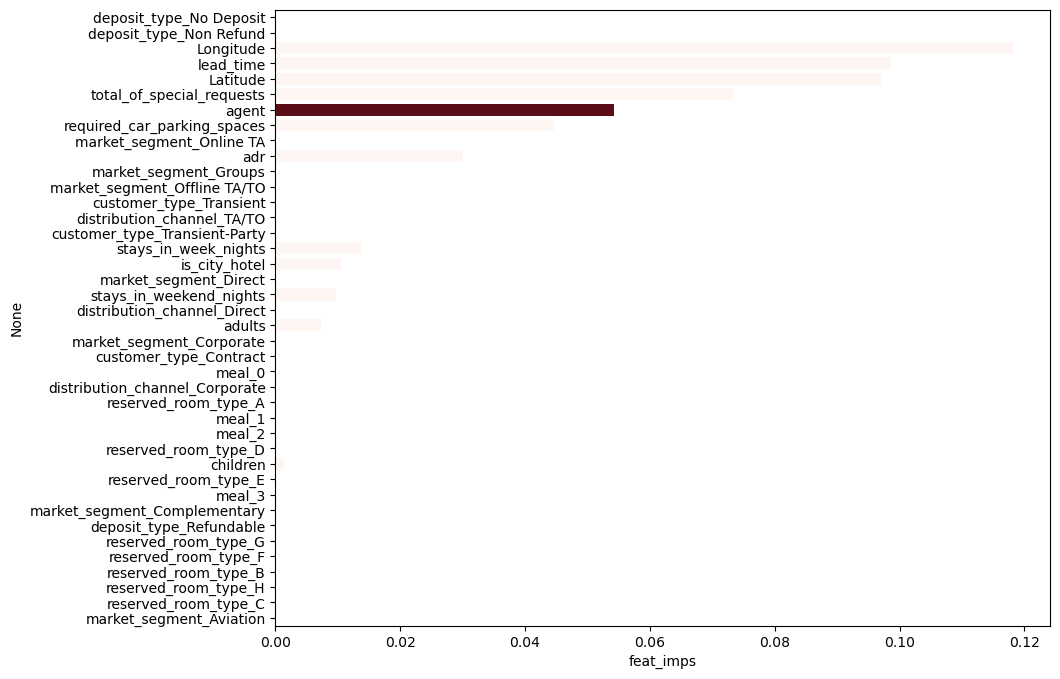

__________________________________________________

Downsampling for crossval diagnostics...

dframe
True: downsample to max_dat_size
original size 55092
max_dat_size 50000
applied shufflesplit:   (50000, 19) (50000,)
__________________________________________________

confusion matrix...
confusion matrix- CrossVal
Confusion matrix, without normalization
[[6176.   855.4]
 [ 746.4 3240.6]]


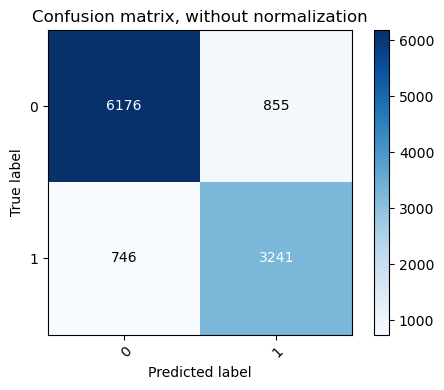

Normalized confusion matrix
[[0.87834571 0.12165429]
 [0.18720843 0.81279157]]


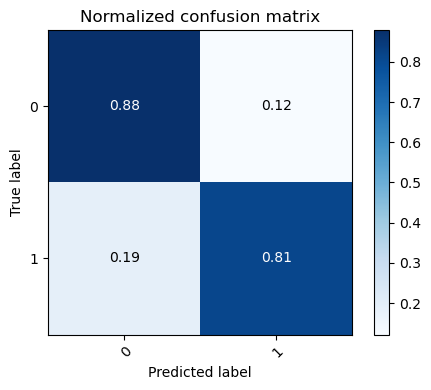

__________________________________________________

cross val scores...
__________________________________________________

learning curve...


fit_time  score_time  test_f1_score  test_fp5_scorer  test_f2_scorer  test_recall  test_precision  test_kappa  test_MMC
0      2.54        0.16           0.80             0.79            0.81         0.81            0.78        0.68      0.68
1      2.58        0.15           0.80             0.79            0.82         0.82            0.78        0.69      0.69
2      2.51        0.19           0.81             0.81            0.82         0.82            0.80        0.70      0.70
3      2.56        0.15           0.79             0.79            0.80         0.81            0.78        0.68      0.68
4      2.56        0.14           0.80             0.81            0.80         0.80            0.81        0.69      0.69

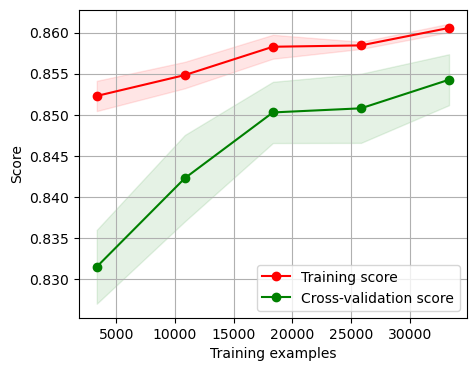

In [112]:
#analyze the results
transformer_pipelines = make_pipeline(num_attribs, bool_attribs, ohot_attribs, \
                                      opt_parameters['imputer_strategy_num'], \
                                      opt_parameters['imputer_strategy_bool'], \
                                      opt_parameters['imputer_strategy_ohot'], \
                                      opt_parameters['imputer_add_indicator'] \
                                     )
preprocess_pipeline = ColumnTransformer(transformer_pipelines, n_jobs=-1)

clf_opt_parameters = { x:y for x,y in opt_parameters.items() if 'imputer' not in x}

clf = RandomForestClassifier(random_state=123, class_weight=class_weights, n_jobs=-1)
clf.set_params(**clf_opt_parameters)

model_pipeline = Pipeline([
        ("preprocess_pipeline", preprocess_pipeline),
        ("clf",clf),
        ])

results_dct, feature_names = fit_model_diagnostics(LABEL, model_pipeline, transformer_pipelines, dfX_train, dfy_train, dfX_test, dfy_test, 50000,
                            null_cols, skf, results_dct, SCORER, target_labels, fit_params={})

pd.DataFrame(results_dct[LABEL])

The learning curve says the model is underfitting

In [113]:
pd.DataFrame(results_dct[LABEL]).mean()

fit_time          2.55
score_time        0.16
test_f1_score     0.80
test_fp5_scorer   0.80
test_f2_scorer    0.81
test_recall       0.81
test_precision    0.79
test_kappa        0.69
test_MMC          0.69
dtype: float64

## Feature Selection - Tuned RFECV

In [114]:
#pipeline setup for for RFE, similar to above.  You have balance and nullfill to decide on

BALANCE = class_weights #class_weights, "balanced_subsample"

ohot_attribs = select_oHot_highCard_features(dfX_train,cat_attribs)

transformer_pipelines = make_pipeline(num_attribs, bool_attribs, ohot_attribs, \
                                          imputer_strategy_num='median', \
                                          imputer_strategy_bool='constant', \
                                          imputer_strategy_ohot='constant', \
                                          imputer_add_indicator=False \
                                         )
preprocess_pipeline = ColumnTransformer(transformer_pipelines, n_jobs=-1)

clf = RandomForestClassifier(random_state=123, class_weight=BALANCE, n_jobs=-1)

display(HTML(estimator_html_repr(preprocess_pipeline)))


_______________________________________
cat_attribs count: 6
['meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type']
_______________________________________
ohot_attribs count: 6
['meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type']


In [115]:
#same opt parameters from the fitted model above
opt_parameters = {'imputer_strategy_num': 'mean', 'imputer_strategy_bool': 'constant', 'imputer_strategy_ohot': 'constant', 'imputer_add_indicator': False, 'n_estimators': 640, 'max_features': 'log2', 'max_depth': 18, 'min_samples_split': 51, 'min_samples_leaf': 12}
opt_parameters

{'imputer_strategy_num': 'mean',
 'imputer_strategy_bool': 'constant',
 'imputer_strategy_ohot': 'constant',
 'imputer_add_indicator': False,
 'n_estimators': 640,
 'max_features': 'log2',
 'max_depth': 18,
 'min_samples_split': 51,
 'min_samples_leaf': 12}

In [116]:
#analyze the results
transformer_pipelines = make_pipeline(num_attribs, bool_attribs, ohot_attribs, \
                                      opt_parameters['imputer_strategy_num'], \
                                      opt_parameters['imputer_strategy_bool'], \
                                      opt_parameters['imputer_strategy_ohot'], \
                                      opt_parameters['imputer_add_indicator'] \
                                     )
preprocess_pipeline = ColumnTransformer(transformer_pipelines, n_jobs=-1)

clf_opt_parameters = { x:y for x,y in opt_parameters.items() if 'imputer' not in x}

clf = RandomForestClassifier(random_state=123, class_weight=class_weights, n_jobs=-1)
clf.set_params(**clf_opt_parameters)


RandomForestClassifier(class_weight={0: 1.0, 1: 1.76}, max_depth=18,
                       max_features='log2', min_samples_leaf=12,
                       min_samples_split=51, n_estimators=640, n_jobs=-1,
                       random_state=123)

Optimal number of features: 19


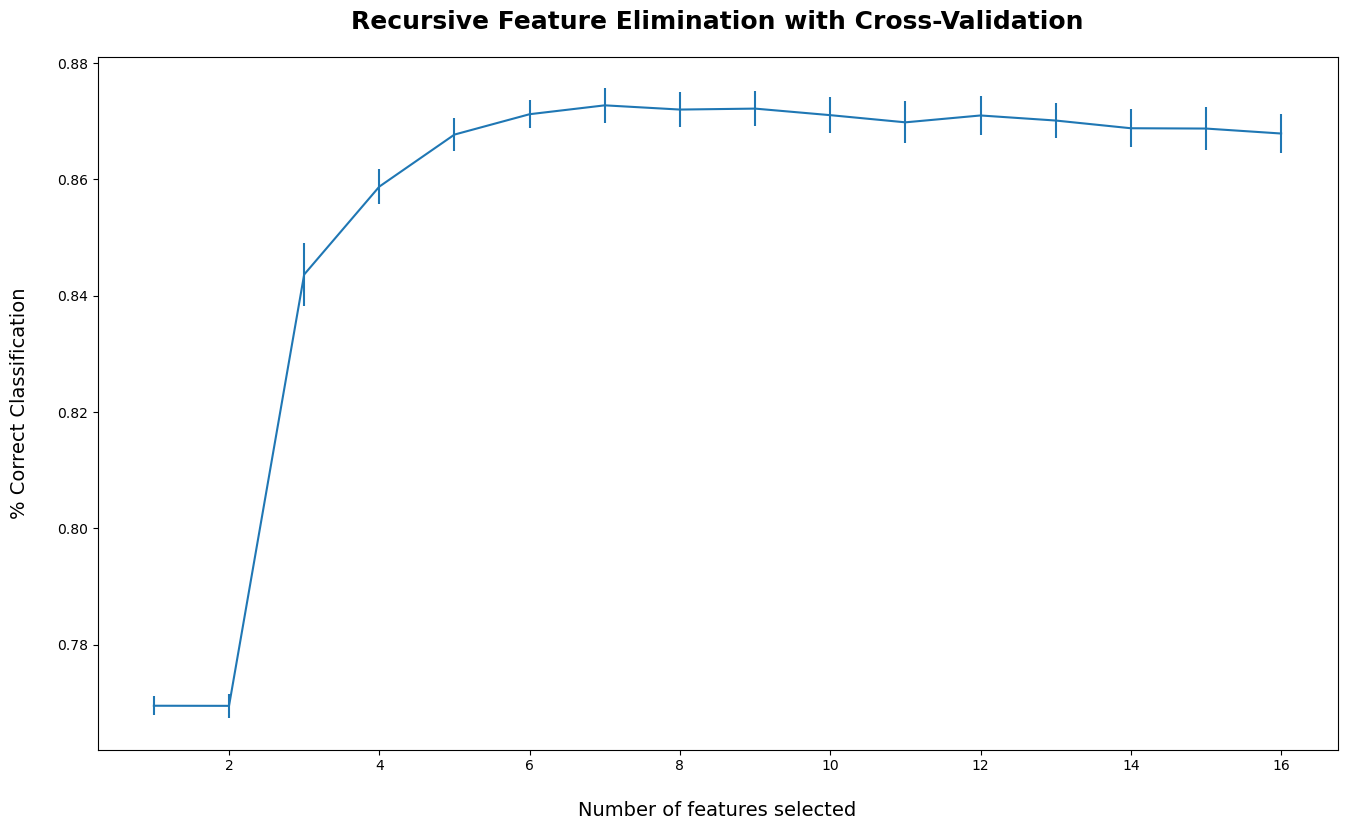

In [117]:
#F1 MICRO
min_features_to_select = 1  # Minimum number of features to consider
SCORER = make_scorer(fbeta_score, average='micro',  beta=1)

rfecv = RFECV(estimator=clf, step=3, cv=skf, scoring=SCORER, min_features_to_select=min_features_to_select, n_jobs = -1)
rfecv.fit(preprocess_pipeline.fit_transform(dfX_train,dfy_train), dfy_train)

print(f"Optimal number of features: {rfecv.n_features_}")

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure(figsize=(16, 9))
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
# plt.xlabel("Number of features selected")
# plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(1, n_scores + 1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)

plt.show()

In [118]:
#get feature names
features_inout_tupls = get_pipeline_features(('Puppies!!!',preprocess_pipeline),transformer_pipelines)

rfecvtune_df = pd.DataFrame()
rfecvtune_df['Feature_in'] = np.array([i[0] for i in features_inout_tupls])
rfecvtune_df['Feature_out'] = np.array([i[1] for i in features_inout_tupls])
rfecvtune_df['Rank'] = rfecv.ranking_

print(rfecvtune_df.shape)
rfecvtune_df = rfecvtune_df[rfecvtune_df['Rank'] == 1]
print(rfecvtune_df.shape)
rfecvtune_df['Importance'] = rfecv.estimator_.feature_importances_


pipe-type: tuple
ordered pipes: {0: 'num', 1: 'bool', 2: 'ohot', 3: 'remainder'}
(46, 3)
(19, 3)


In [119]:
rfetune_imp = rfecvtune_df.sort_values('Importance',ascending=False)
rfetune_imp

Feature_in                    Feature_out  Rank  Importance
0                     lead_time                      lead_time     1        0.13
40                      deposit        deposit_type_Non Refund     1        0.12
39                      deposit        deposit_type_No Deposit     1        0.12
10                    Longitude                      Longitude     1        0.11
9                      Latitude                       Latitude     1        0.09
8     total_of_special_requests      total_of_special_requests     1        0.08
5                         agent                          agent     1        0.08
7   required_car_parking_spaces    required_car_parking_spaces     1        0.05
6                           adr                            adr     1        0.05
22                       market       market_segment_Online TA     1        0.04
44                     customer        customer_type_Transient     1        0.02
2          stays_in_week_nights           stays_in_week_nights     1        0.02
21                       market   market_segment_Offline TA/TO     1        0.02
27                 distribution     distribution_channel_TA/TO     1        0.02
20                       market          market_segment_Groups     1        0.02
45                     customer  customer_type_Transient-Party     1        0.01
1       stays_in_weekend_nights        stays_in_weekend_nights     1        0.01
11                is_city_hotel                  is_city_hotel     1        0.01
3                        adults                         adults     1        0.01

## Subset RFC 

In [120]:

def make_pipeline(num_attribs, bool_attribs, ohot_attribs, imputer_strategy_num, imputer_strategy_bool, imputer_strategy_ohot, imputer_add_indicator):
    
    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy=imputer_strategy_num, add_indicator=imputer_add_indicator)),    
        ('robust_scaler', RobustScaler())
    ])
    bool_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy=imputer_strategy_bool, add_indicator=imputer_add_indicator)), 
        ])
    ohot_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy=imputer_strategy_ohot, add_indicator=imputer_add_indicator)),
        ('ohot_encoder', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    transformer_pipelines = [
    ('num', num_pipeline, num_attribs) if num_attribs else None,
    ('bool', bool_pipeline, bool_attribs) if bool_attribs else None,
    ('ohot', ohot_pipeline, ohot_attribs) if ohot_attribs else None,
    ]
    # Filter out None values
    transformer_pipelines = [tp for tp in transformer_pipelines if tp is not None]
    
    return transformer_pipelines

def objective_rfc(X_opt, y_opt, num_attribs, bool_attribs, ohot_attribs, trial):
    
    # Add SimpleImputer parameters
    imputer_strategy_num = trial.suggest_categorical('imputer_strategy_num', ['mean', 'median', 'constant'])
    imputer_strategy_bool = trial.suggest_categorical('imputer_strategy_bool', ['most_frequent', 'constant'])
    imputer_strategy_ohot = trial.suggest_categorical('imputer_strategy_ohot', ['most_frequent', 'constant'])
    imputer_add_indicator = trial.suggest_categorical('imputer_add_indicator', [False])

    #model parameters
    # n_estimators = trial.suggest_int('n_estimators',100,900)
    n_estimators = trial.suggest_int('n_estimators',100,2000)
    max_features = trial.suggest_categorical('max_features', ["sqrt", "log2"])
    max_depth = trial.suggest_int('max_depth',3,20)
    min_samples_split = trial.suggest_int('min_samples_split',2,100)
    min_samples_leaf = trial.suggest_int('min_samples_leaf',2,100)

    # Create and fit the model pipeline
    # ...
    clf = RandomForestClassifier(n_estimators=n_estimators,
                                  max_features=max_features,
                                  max_depth=max_depth,
                                  min_samples_split=min_samples_split,
                                  min_samples_leaf=min_samples_leaf,
                                  class_weight=BALANCE,
                                  n_jobs=-1,
                                  random_state = 123,
                                  verbose=1 #set to zero to turn off printing
                                )

    # Create pipeline with the suggested parameters
    transformer_pipelines = make_pipeline(num_attribs, bool_attribs, ohot_attribs, \
                                          imputer_strategy_num, \
                                          imputer_strategy_bool, \
                                          imputer_strategy_ohot, \
                                          imputer_add_indicator \
                                         )
    preprocess_pipeline = ColumnTransformer(transformer_pipelines, n_jobs=-1)
    
    model_pipeline = Pipeline([
            ("preprocess_pipeline", preprocess_pipeline),
            ("clf",clf),
            ])
    
    model_pipeline.fit(X_opt, y_opt)

    # Return the cross-validation score
    # ...
    sskf = StratifiedKFold(n_splits=5,shuffle=True,random_state=123)
    #uses scorer
    scores = cross_validate(model_pipeline, X=X_opt, y=y_opt, cv=sskf, scoring=SCORER) #cross_validate provides more details like train times

    return scores['test_score'].mean()



In [121]:
subset_full = list(set(rfetune_imp['Feature_in']))
print(len(subset_full))
subset_full

#'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type']

15


['Latitude',
 'stays_in_weekend_nights',
 'distribution',
 'required_car_parking_spaces',
 'Longitude',
 'adults',
 'market',
 'stays_in_week_nights',
 'customer',
 'lead_time',
 'adr',
 'agent',
 'is_city_hotel',
 'total_of_special_requests',
 'deposit']

In [122]:
#correcting the feature names that got incorrect after the feature selection
subset_full.remove('deposit')
subset_full.remove('market')
subset_full.remove('distribution')
subset_full.remove('customer')

subset_full.append('deposit_type')
subset_full.append('market_segment')
subset_full.append('distribution_channel')
subset_full.append('customer_type')
subset_full

['Latitude',
 'stays_in_weekend_nights',
 'required_car_parking_spaces',
 'Longitude',
 'adults',
 'stays_in_week_nights',
 'lead_time',
 'adr',
 'agent',
 'is_city_hotel',
 'total_of_special_requests',
 'deposit_type',
 'market_segment',
 'distribution_channel',
 'customer_type']

In [123]:

subset = subset_full
display(subset)
print(len(subset))

#parse out subset into separated attribute subsets
num_attribs_subset = list(set(num_attribs).intersection(set(subset)))
bool_attribs_subset = list(set(bool_attribs).intersection(set(subset)))
ohot_attribs_subset = list(set(ohot_attribs).intersection(set(subset)))


print('\n NOTE: EMPTY LISTS BELOW SHOULD HAVE THE CORRESPONDING PIPELINE COMMENTED OUT IN TRANSFORMER_PIPELINES IN THE CELL BELOW')
print('\n num-pipeline \n',num_attribs_subset)
print('\n bool-pipeline \n',bool_attribs_subset)
print('\n ohot-pipeline \n',ohot_attribs_subset)

['Latitude',
 'stays_in_weekend_nights',
 'required_car_parking_spaces',
 'Longitude',
 'adults',
 'stays_in_week_nights',
 'lead_time',
 'adr',
 'agent',
 'is_city_hotel',
 'total_of_special_requests',
 'deposit_type',
 'market_segment',
 'distribution_channel',
 'customer_type']

15

 NOTE: EMPTY LISTS BELOW SHOULD HAVE THE CORRESPONDING PIPELINE COMMENTED OUT IN TRANSFORMER_PIPELINES IN THE CELL BELOW

 num-pipeline 
 ['Latitude', 'stays_in_weekend_nights', 'required_car_parking_spaces', 'Longitude', 'adults', 'stays_in_week_nights', 'lead_time', 'adr', 'agent', 'total_of_special_requests']

 bool-pipeline 
 ['is_city_hotel']

 ohot-pipeline 
 ['customer_type', 'distribution_channel', 'deposit_type', 'market_segment']


In [124]:
#tuning
LABEL = 'rfe-rfc-f1micro-subset_full'
BALANCE = class_weights #class_weights, "balanced_subsample"
SCORER = make_scorer(fbeta_score, average='micro',  beta=1)

ohot_attribs = select_oHot_highCard_features(dfX_train,cat_attribs)

f = partial(objective_rfc, dfX_tune, dfy_tune, num_attribs_subset, bool_attribs_subset, ohot_attribs_subset)
study = optuna.create_study(direction='maximize')
optuna.logging.disable_default_handler()
study.optimize(f, n_trials=10)

_______________________________________
cat_attribs count: 6
['meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type']
_______________________________________
ohot_attribs count: 6
['meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type']


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1376 out of 1376 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1376 out of 1376 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent

In [125]:
# best parms
opt_parameters = study.best_trial.params
print('Best trial: score {}, params {}'.format(study.best_trial.value, opt_parameters))

Best trial: score 0.8400000000000001, params {'imputer_strategy_num': 'constant', 'imputer_strategy_bool': 'constant', 'imputer_strategy_ohot': 'most_frequent', 'imputer_add_indicator': False, 'n_estimators': 1978, 'max_features': 'sqrt', 'max_depth': 18, 'min_samples_split': 28, 'min_samples_leaf': 41}


pipe_type: fullpipe
__________________________________________________

model fit...
{}
__________________________________________________

classification report...
Train Set:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89     35157
           1       0.80      0.84      0.82     19935

    accuracy                           0.87     55092
   macro avg       0.85      0.86      0.86     55092
weighted avg       0.87      0.87      0.87     55092

Test Set:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      6027
           1       0.80      0.84      0.82      3418

    accuracy                           0.86      9445
   macro avg       0.85      0.86      0.85      9445
weighted avg       0.87      0.86      0.87      9445

__________________________________________________

feature importance...
pipe-type: fullpipe
ordered pipes: {0: 'num', 1: 'bool', 2: 'ohot', 3: 'remainder'}
NO

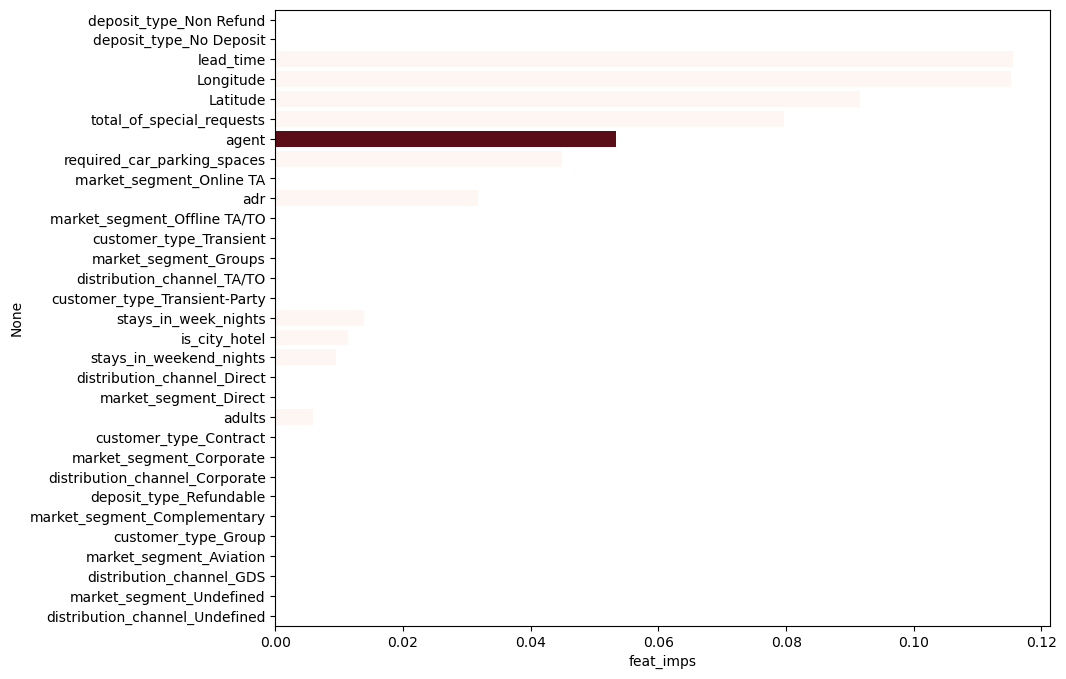

__________________________________________________

Downsampling for crossval diagnostics...

dframe
True: downsample to max_dat_size
original size 55092
max_dat_size 50000
applied shufflesplit:   (50000, 19) (50000,)
__________________________________________________

confusion matrix...
confusion matrix- CrossVal
Confusion matrix, without normalization
[[6167.2  864.2]
 [ 700.  3287. ]]


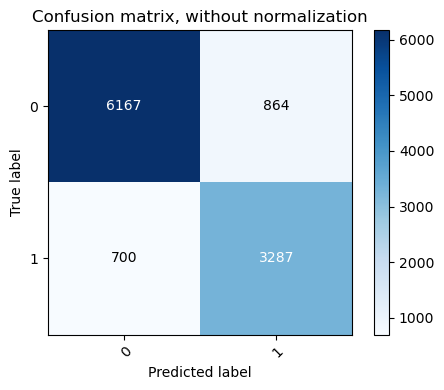

Normalized confusion matrix
[[0.87709418 0.12290582]
 [0.1755706  0.8244294 ]]


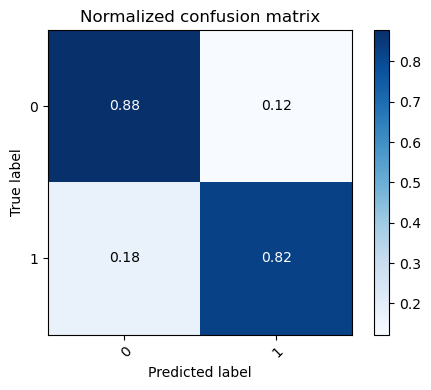

__________________________________________________

cross val scores...
__________________________________________________

learning curve...


fit_time  score_time  test_f1_score  test_fp5_scorer  test_f2_scorer  test_recall  test_precision  test_kappa  test_MMC
0     36.93        1.50           0.80             0.79            0.82         0.83            0.78        0.69      0.69
1     37.33        1.26           0.81             0.80            0.82         0.83            0.79        0.70      0.70
2     36.88        1.58           0.81             0.80            0.82         0.83            0.80        0.70      0.70
3     37.58        1.05           0.79             0.79            0.80         0.81            0.78        0.67      0.67
4     37.03        1.38           0.81             0.80            0.81         0.81            0.80        0.70      0.70

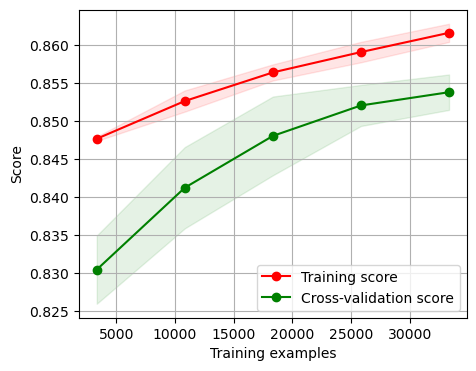

In [126]:


transformer_pipelines = make_pipeline(num_attribs_subset, bool_attribs_subset, ohot_attribs_subset, \
                                      opt_parameters['imputer_strategy_num'], \
                                      opt_parameters['imputer_strategy_bool'], \
                                      opt_parameters['imputer_strategy_ohot'], \
                                      opt_parameters['imputer_add_indicator'] \
                                     )
preprocess_pipeline = ColumnTransformer(transformer_pipelines, n_jobs=-1)

clf_opt_parameters = { x:y for x,y in opt_parameters.items() if 'imputer' not in x}

clf = RandomForestClassifier(random_state=123, class_weight=class_weights, n_jobs=-1)
clf.set_params(**clf_opt_parameters)

model_pipeline = Pipeline([
        ("preprocess_pipeline", preprocess_pipeline),
        ("clf",clf),
        ])

results_dct, feature_names = fit_model_diagnostics(LABEL, model_pipeline, transformer_pipelines, dfX_train, dfy_train, dfX_test, dfy_test, 50000,
                            null_cols, skf, results_dct, SCORER, target_labels, fit_params={})

pd.DataFrame(results_dct[LABEL])

Again the learning curve says the model is underfitting

In [127]:
pd.DataFrame(results_dct[LABEL]).mean()

fit_time          37.15
score_time         1.35
test_f1_score      0.81
test_fp5_scorer    0.80
test_f2_scorer     0.82
test_recall        0.82
test_precision     0.79
test_kappa         0.69
test_MMC           0.69
dtype: float64

## ****Light GBM
To avoid overfitting the training set needs to have at least 10k records

In [128]:

def make_pipeline(num_attribs, bool_attribs, ohot_attribs, imputer_strategy_num, imputer_strategy_bool, imputer_strategy_ohot, imputer_add_indicator):
    
    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy=imputer_strategy_num, add_indicator=imputer_add_indicator)),    
        ('robust_scaler', RobustScaler())
    ])
    bool_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy=imputer_strategy_bool, add_indicator=imputer_add_indicator)), 
        ])
    ohot_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy=imputer_strategy_ohot, add_indicator=imputer_add_indicator)),
        ('ohot_encoder', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    transformer_pipelines = [
    ('num', num_pipeline, num_attribs) if num_attribs else None,
    ('bool', bool_pipeline, bool_attribs) if bool_attribs else None,
    ('ohot', ohot_pipeline, ohot_attribs) if ohot_attribs else None,
    ]
    # Filter out None values
    transformer_pipelines = [tp for tp in transformer_pipelines if tp is not None]
    
    return transformer_pipelines

def objective_lgb(X_opt, y_opt, num_attribs, bool_attribs, ohot_attribs, trial):
    
    # Add SimpleImputer parameters
    imputer_strategy_num = trial.suggest_categorical('imputer_strategy_num', ['mean', 'median', 'constant'])
    imputer_strategy_bool = trial.suggest_categorical('imputer_strategy_bool', ['most_frequent', 'constant'])
    imputer_strategy_ohot = trial.suggest_categorical('imputer_strategy_ohot', ['most_frequent', 'constant'])
    imputer_add_indicator = trial.suggest_categorical('imputer_add_indicator', [False])

    #model parameters
    bagging_freq =  trial.suggest_int('bagging_freq',1,10),
    min_data_in_leaf =  trial.suggest_int('min_data_in_leaf',2,100),
    max_depth = trial.suggest_int('max_depth',1,20),
    learning_rate = trial.suggest_loguniform('learning_rate',0.001,0.1),
    num_leaves = trial.suggest_int('num_leaves',2,70),
    min_sum_hessian_in_leaf = trial.suggest_int('min_sum_hessian_in_leaf',1,10),
    reg_alpha = trial.suggest_loguniform('reg_alpha',0.0001,100),
    reg_lambda = trial.suggest_loguniform('reg_lambda',0.0001,100),

    # Create and fit the model pipeline
    # ...
    clf = lgb.LGBMClassifier(
                            objective='binary',
                            random_state = 123,
                            bagging_seed = 123,
                            boost_from_average = 'true',
                            boost = 'gbdt',
                            metric = 'binary_logloss',
                            class_weight=BALANCE,
                            num_threads = -1,
                            bagging_freq = bagging_freq,
                            min_data_in_leaf = min_data_in_leaf,
                            max_depth = max_depth,
                            learning_rate = learning_rate,
                            num_leaves = num_leaves,
                            min_sum_hessian_in_leaf = min_sum_hessian_in_leaf,
                            reg_alpha = reg_alpha,
                            reg_lambda = reg_lambda,
                            verbose=0
                        )

    # Create pipeline with the suggested parameters
    transformer_pipelines = make_pipeline(num_attribs, bool_attribs, ohot_attribs, \
                                          imputer_strategy_num, \
                                          imputer_strategy_bool, \
                                          imputer_strategy_ohot, \
                                          imputer_add_indicator \
                                         )
    preprocess_pipeline = ColumnTransformer(transformer_pipelines, n_jobs=-1)
    
    model_pipeline = Pipeline([
            ("preprocess_pipeline", preprocess_pipeline),
            ("clf",clf),
            ])
    
    model_pipeline.fit(X_opt, y_opt)

    # Return the cross-validation score
    # ...
    sskf = StratifiedKFold(n_splits=5,shuffle=True,random_state=123)
    #uses scorer
    scores = cross_validate(model_pipeline, X=X_opt, y=y_opt, cv=sskf, scoring=SCORER) #cross_validate provides more details like train times

    return scores['test_score'].mean()



In [129]:
# tuning
LABEL = 'lgb_tune_classweights-f1micro'
BALANCE = class_weights #class_weights, "balanced_subsample"
SCORER = make_scorer(fbeta_score, average='micro',  beta=1)

ohot_attribs = select_oHot_highCard_features(dfX_train,cat_attribs)

f = partial(objective_lgb, dfX_train, dfy_train, num_attribs, bool_attribs, ohot_attribs)
study = optuna.create_study(direction='maximize')
optuna.logging.disable_default_handler()
study.optimize(f, n_trials=10)


_______________________________________
cat_attribs count: 6
['meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type']
_______________________________________
ohot_attribs count: 6
['meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type']
[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_

In [130]:
opt_parameters = study.best_trial.params
print('Best trial: score {}, params {}'.format(study.best_trial.value, opt_parameters))

Best trial: score 0.8689284112652759, params {'imputer_strategy_num': 'mean', 'imputer_strategy_bool': 'most_frequent', 'imputer_strategy_ohot': 'constant', 'imputer_add_indicator': False, 'bagging_freq': 10, 'min_data_in_leaf': 45, 'max_depth': 16, 'learning_rate': 0.06406110837454189, 'num_leaves': 45, 'min_sum_hessian_in_leaf': 6, 'reg_alpha': 0.0016801050513418046, 'reg_lambda': 3.589972261687373}


pipe_type: fullpipe
__________________________________________________

model fit...
{}
[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.

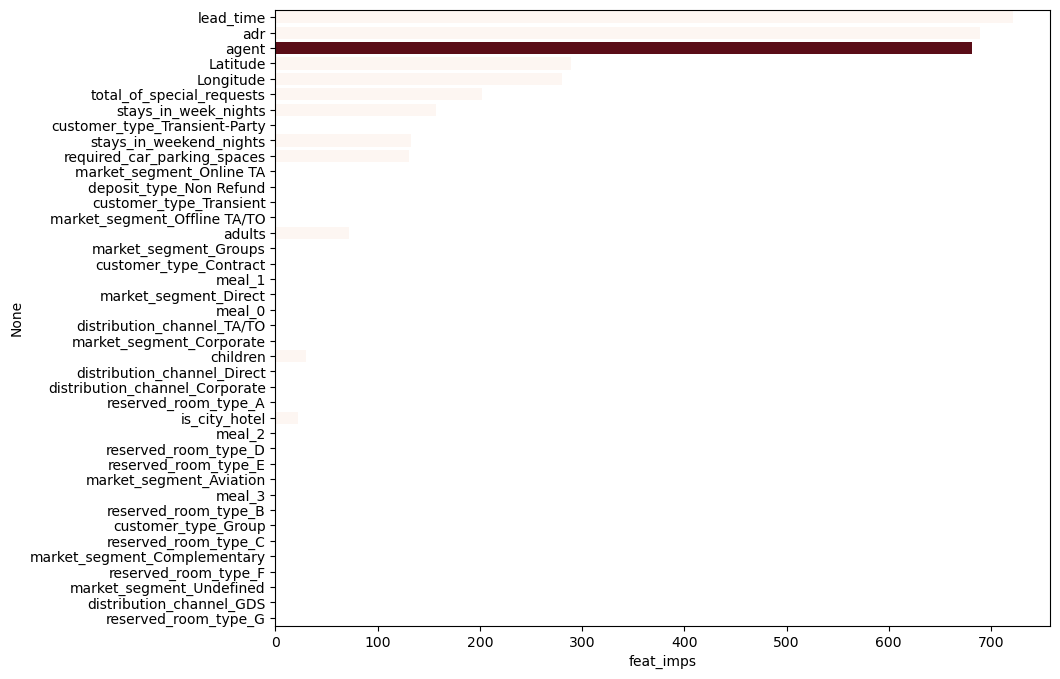

__________________________________________________

Downsampling for crossval diagnostics...

dframe
True: downsample to max_dat_size
original size 55092
max_dat_size 50000
applied shufflesplit:   (50000, 19) (50000,)
__________________________________________________

confusion matrix...
confusion matrix- CrossVal
[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored

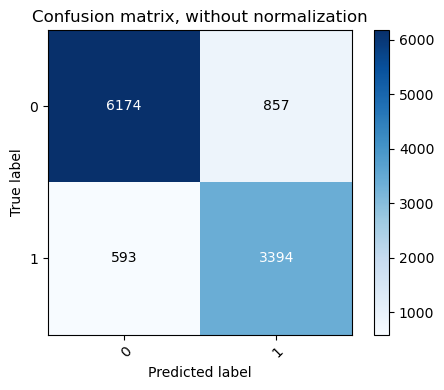

Normalized confusion matrix
[[0.87808971 0.12191029]
 [0.14868322 0.85131678]]


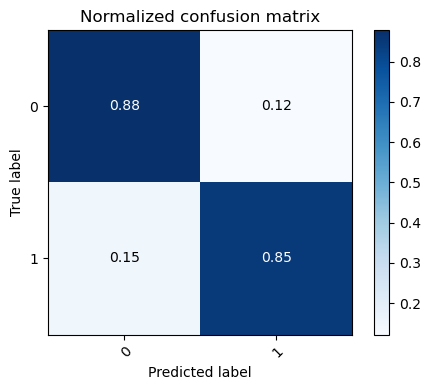

__________________________________________________

cross val scores...
__________________________________________________

learning curve...


fit_time  score_time  test_f1_score  test_fp5_scorer  test_f2_scorer  test_recall  test_precision  test_kappa  test_MMC
0      6.77        0.11           0.82             0.80            0.84         0.85            0.79        0.71      0.71
1      7.39        0.08           0.83             0.81            0.85         0.87            0.80        0.73      0.73
2      6.58        0.09           0.83             0.81            0.84         0.86            0.80        0.72      0.72
3      6.75        0.10           0.81             0.80            0.83         0.84            0.79        0.70      0.71
4      7.21        0.09           0.83             0.82            0.84         0.85            0.81        0.73      0.73

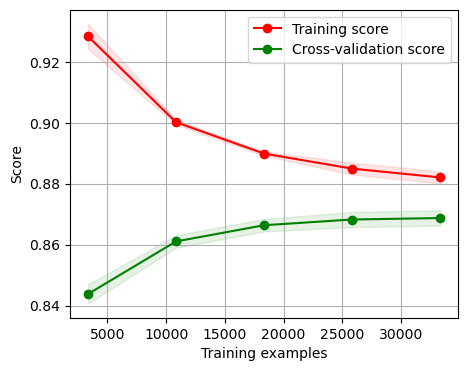

In [131]:

transformer_pipelines = make_pipeline(num_attribs, bool_attribs, ohot_attribs, \
                                      opt_parameters['imputer_strategy_num'], \
                                      opt_parameters['imputer_strategy_bool'], \
                                      opt_parameters['imputer_strategy_ohot'], \
                                      opt_parameters['imputer_add_indicator'] \
                                     )
preprocess_pipeline = ColumnTransformer(transformer_pipelines, n_jobs=-1)

clf_opt_parameters = { x:y for x,y in opt_parameters.items() if 'imputer' not in x}

clf = lgb.LGBMClassifier(
        objective='binary',
        random_state = 123,
        bagging_seed = 123,
        boost_from_average = 'true',
        boost = 'gbdt',
        metric = 'binary_logloss',
        class_weight=BALANCE,
        num_threads = -1,
                        )

clf.set_params(**clf_opt_parameters)

model_pipeline = Pipeline([
        ("preprocess_pipeline", preprocess_pipeline),
        ("clf",clf),
        ])

results_dct, feature_names = fit_model_diagnostics(LABEL, model_pipeline, transformer_pipelines, dfX_train, dfy_train, dfX_test, dfy_test, 50000,
                            null_cols, skf, results_dct, SCORER, target_labels, fit_params={})

pd.DataFrame(results_dct[LABEL])

Perfection learning curve and a good confusion matrix with the diagonal highlighted. Feature importance also makes sense

In [132]:
pd.DataFrame(results_dct[LABEL]).mean()

fit_time          6.94
score_time        0.09
test_f1_score     0.82
test_fp5_scorer   0.81
test_f2_scorer    0.84
test_recall       0.85
test_precision    0.80
test_kappa        0.72
test_MMC          0.72
dtype: float64

## subset - LGB retune - subset_full

In [124]:

subset = ['Latitude',
 'stays_in_weekend_nights',
 'required_car_parking_spaces',
 'Longitude',
 'adults',
 'stays_in_week_nights',
 'lead_time',
 'adr',
 'agent',
 'is_city_hotel',
 'total_of_special_requests',
 'deposit_type',
 'market_segment',
 'distribution_channel',
 'customer_type']

display(subset)
print(len(subset))

#parse out subset into separated attribute subsets
num_attribs_subset = list(set(num_attribs).intersection(set(subset)))
bool_attribs_subset = list(set(bool_attribs).intersection(set(subset)))
ohot_attribs_subset = list(set(ohot_attribs).intersection(set(subset)))


print('\n NOTE: EMPTY LISTS BELOW SHOULD HAVE THE CORRESPONDING PIPELINE COMMENTED OUT IN TRANSFORMER_PIPELINES IN THE CELL BELOW')
print('\n num-pipeline \n',num_attribs_subset)
print('\n bool-pipeline \n',bool_attribs_subset)
print('\n ohot-pipeline \n',ohot_attribs_subset)

['total_of_special_requests',
 'adr',
 'stays_in_week_nights',
 'required_car_parking_spaces',
 'lead_time',
 'is_city_hotel',
 'adults',
 'Latitude',
 'booking_changes',
 'stays_in_weekend_nights',
 'Longitude',
 'agent',
 'deposit_type',
 'market_segment',
 'distribution_channel',
 'customer_type']

16

 NOTE: EMPTY LISTS BELOW SHOULD HAVE THE CORRESPONDING PIPELINE COMMENTED OUT IN TRANSFORMER_PIPELINES IN THE CELL BELOW

 num-pipeline 
 ['total_of_special_requests', 'stays_in_week_nights', 'adr', 'required_car_parking_spaces', 'lead_time', 'adults', 'Latitude', 'booking_changes', 'stays_in_weekend_nights', 'Longitude', 'agent']

 bool-pipeline 
 ['is_city_hotel']

 ohot-pipeline 
 ['distribution_channel', 'deposit_type', 'market_segment', 'customer_type']


In [125]:
#tuning
LABEL = 'rfe-lgb-f1micro-subset_full'
BALANCE = class_weights #class_weights, "balanced_subsample"
SCORER = make_scorer(fbeta_score, average='micro',  beta=1)

ohot_attribs = select_oHot_highCard_features(dfX_train,cat_attribs)

f = partial(objective_lgb, dfX_train, dfy_train, num_attribs_subset, bool_attribs_subset,  ohot_attribs_subset)
study = optuna.create_study(direction='maximize')
optuna.logging.disable_default_handler()
study.optimize(f, n_trials=10)

_______________________________________
cat_attribs count: 6
['meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type']
_______________________________________
ohot_attribs count: 6
['meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type']
[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_ch

In [126]:
# best parms
opt_parameters = study.best_trial.params
print('Best trial: score {}, params {}'.format(study.best_trial.value, opt_parameters))

Best trial: score 0.8621579689966362, params {'imputer_strategy_num': 'mean', 'imputer_strategy_bool': 'most_frequent', 'imputer_strategy_ohot': 'constant', 'imputer_add_indicator': False, 'bagging_freq': 10, 'min_data_in_leaf': 55, 'max_depth': 9, 'learning_rate': 0.04562981525659386, 'num_leaves': 38, 'min_sum_hessian_in_leaf': 7, 'reg_alpha': 0.005353347483937696, 'reg_lambda': 0.2588097376255871}


pipe_type: fullpipe
__________________________________________________

model fit...
{}
[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.

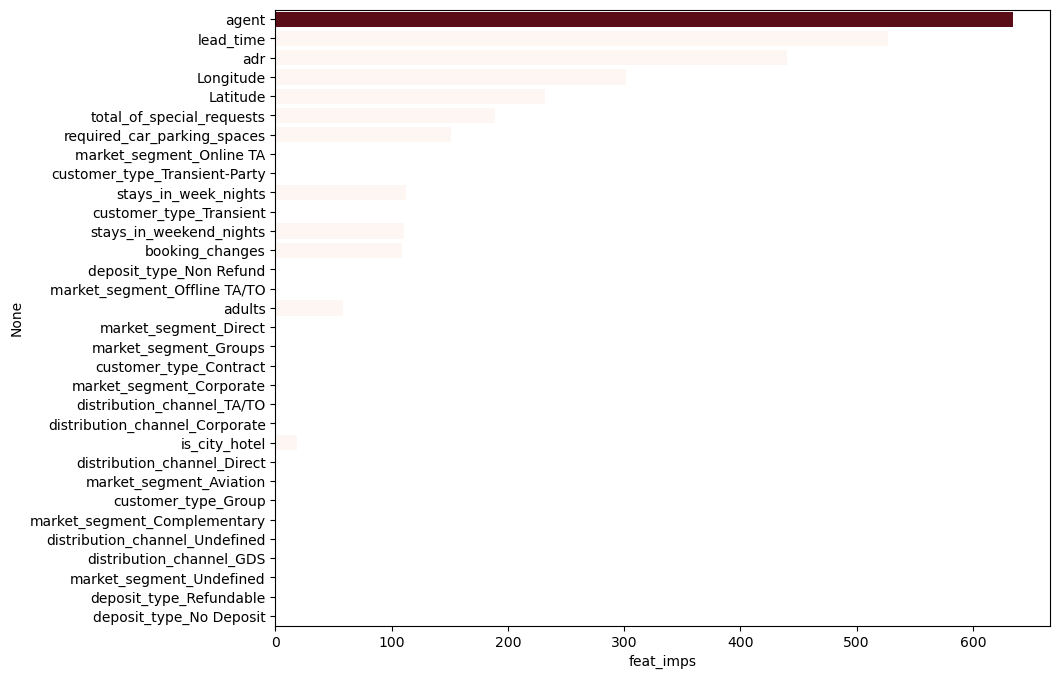

__________________________________________________

Downsampling for crossval diagnostics...

dframe
True: downsample to max_dat_size
original size 55092
max_dat_size 50000
applied shufflesplit:   (50000, 20) (50000,)
__________________________________________________

confusion matrix...
confusion matrix- CrossVal
[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored

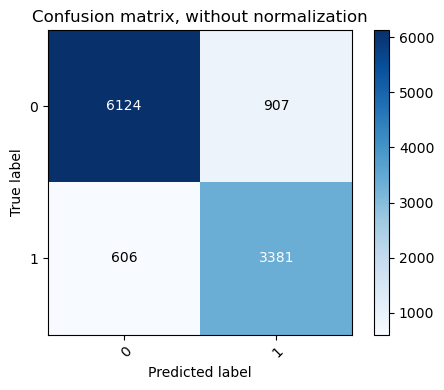

Normalized confusion matrix
[[0.87095031 0.12904969]
 [0.15189365 0.84810635]]


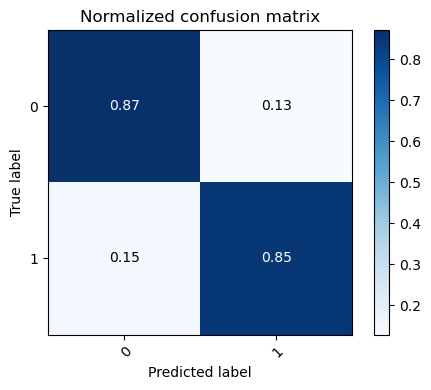

__________________________________________________

cross val scores...
__________________________________________________

learning curve...


fit_time  score_time  test_f1_score  test_fp5_scorer  test_f2_scorer  test_recall  test_precision  test_kappa  test_MMC
0      5.39        0.06           0.81             0.79            0.83         0.85            0.78        0.70      0.70
1      5.60        0.05           0.82             0.80            0.84         0.86            0.79        0.71      0.71
2      5.10        0.07           0.82             0.80            0.84         0.85            0.79        0.72      0.72
3      5.32        0.06           0.80             0.78            0.82         0.83            0.77        0.68      0.68
4      5.07        0.07           0.82             0.81            0.84         0.84            0.80        0.72      0.72

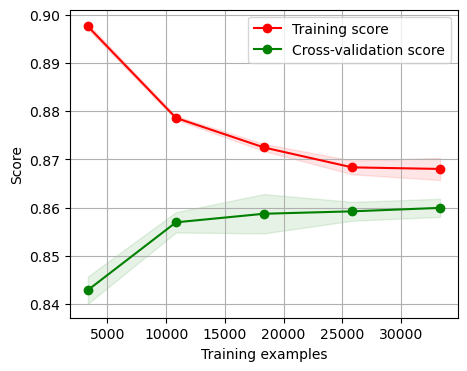

In [127]:

transformer_pipelines = make_pipeline(num_attribs_subset, bool_attribs_subset, ohot_attribs_subset, \
                                      opt_parameters['imputer_strategy_num'], \
                                      opt_parameters['imputer_strategy_bool'], \
                                      opt_parameters['imputer_strategy_ohot'], \
                                      opt_parameters['imputer_add_indicator'] \
                                     )
preprocess_pipeline = ColumnTransformer(transformer_pipelines, n_jobs=-1)

clf_opt_parameters = { x:y for x,y in opt_parameters.items() if 'imputer' not in x}

clf = lgb.LGBMClassifier(
        objective='binary',
        random_state = 123,
        bagging_seed = 123,
        boost_from_average = 'true',
        boost = 'gbdt',
        metric = 'binary_logloss',
        class_weight=BALANCE,
        num_threads = -1,
                        )


clf.set_params(**clf_opt_parameters)

model_pipeline = Pipeline([
        ("preprocess_pipeline", preprocess_pipeline),
        ("clf",clf),
        ])

results_dct, feature_names = fit_model_diagnostics(LABEL, model_pipeline, transformer_pipelines, dfX_train, dfy_train, dfX_test, dfy_test, 50000,
                            null_cols, skf, results_dct, SCORER, target_labels, fit_params={})

pd.DataFrame(results_dct[LABEL])

Again a perfect learning curve with good confusion matrix results. Iffy on the feature importance with agent being the highest important feature

# 7. Model Build
This process consits of choosing the top 2 models out of the 4 trained models above. We will go with the 2 LightGBM models

In [133]:
def create_plot_conf_matrix_build(y_test, yp_test, target_labels):
    """ This function calls plot_confusion_matrix twice, once for raw and another for normalize
        to regularly display the two plots in a standardized way.
    Args: 
        y_true : array of actual labels to compare to
        y_pred : array of predicted labels for comparison
        classes : actual list of classes available in y_true. Must be set ordinally
    returns: no return, automatically displays when run
    """
    
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 5
    fig_size[1] = 4
    plt.rcParams["figure.figsize"] = fig_size
    # np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plot_confusion_matrix(y_test, yp_test, classes=target_labels,
                          title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plot_confusion_matrix(y_test, yp_test, classes=target_labels, normalize=True,
                          title='Normalized confusion matrix')
    plt.show()


def validate_model_diagnostics(model_obj, transformer_pipelines, X_test, y_test, target_labels):
    """
    A lighter weight version of fit_model_diagnostics function to run testing against a test or validation set.

    This function takes in the validation sets, model, and pipelines that have been previously already fit.
    What isn't in this function that the fit_model_diagnostics has is there is no fitting, subsampling, crossval scores 
    or learning curves. The function takes in a model and data, makes predictions, and creates classification report, 
    confusion matrics, and feature importances (same as before).
    
    Args:
        model_obj: takes 1 of 2 options which dictate where in the pipeline the feature info is
            1) model_pipeline - this is the full model pipeline that is already prefitted on dfX_test 
            2) (model, preprocess_pipeline) - a tuple of the separate model and preprocessing components. This for 
            when you run the preprocess separately to output a numpy array (dfX_test -> X_test) and then use those to 
            for prediction with the prefitted model. 
        transformer_pipelines: the combined pipeline for the different types of columns (numeric, cat, etc.) that are
            fed into the preprocessing pipeline.
        X_test: Test data. Depending on model_obj, if model_obj is the full model_pipeline, then this must be 
            a pandas dataframe (usually as dfX_train.  otherwise its a numpy array (usualy as X_train)
        y_test: the target column for training and type follows same logic as above
        target_labels: This is the ordinal list or target classes, in order, to properly display the confusion matrix.

    Returns:
        feature_importance: sorted as pandas series for copying if need be. 
        name from the get_pipeline_features function. see the function get_pipeline_features for example.
    """
    
    # check if model_pipeline is full model_pipeline or separated (as a tuple) and manage:
    if type(model_obj) is tuple:
        pipe_type = 'tuple'
        #assign each components
#         preprocess_pipeline = model_obj[1] #not need for validation?
        model = model_obj[0]
    else:
        pipe_type = 'fullpipe'
        # or pass on
        model = model_obj
    print('pipe_type:', pipe_type)


    print('__________________________________________________\n')
    print('model predict...')

    yp_test = model.predict(X_test)

    #shrink for diagnostic runtime

    
    print('__________________________________________________\n')
    print('classification report...')
    
    print('Test Set:')
    print(classification_report(y_test, yp_test))
    

    print('__________________________________________________\n')
    print('feature importance...')

    #get just resulting feature names after fit from tuples from model fit
    features_inout_tupls = get_pipeline_features(model_obj,transformer_pipelines)
    feature_names = [i[1] for i in features_inout_tupls] 

    if pipe_type == 'tuple':
        feature_importances = model.feature_importances_

    if pipe_type == 'fullpipe':
        feature_importances = model.named_steps['clf'].feature_importances_

    #sort and plot the full list of feature importance
    sorted_importances = pd.Series(feature_importances, index=feature_names).sort_values()
    sorted_importances.plot(kind='barh', color='lightgreen', title = 'Features by importance', figsize = [12,10])
    
        
    print('__________________________________________________\n')
    print('confusion matrix...')

    create_plot_conf_matrix_build(y_test, yp_test, target_labels)


    return sorted_importances.sort_values(ascending=False)

## Model 1

In [135]:
# entire list of features
subset_1 = ['lead_time',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'agent',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'Latitude',
 'Longitude',
 'is_city_hotel',
 'meal',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'deposit_type',
 'customer_type'
           ]

print(len(subset_1))

#parse out subset into separated attribute subsets
num_attribs_subset_1 = list(set(num_attribs).intersection(set(subset_1)))
bool_attribs_subset_1 = list(set(bool_attribs).intersection(set(subset_1)))
ohot_attribs_subset_1 = list(set(ohot_attribs).intersection(set(subset_1)))

print('\n num-pipeline \n',num_attribs_subset_1)
print('\n bool-pipeline \n',bool_attribs_subset_1)
print('\n ohot-pipeline \n',ohot_attribs_subset_1)
display(subset_1)

18

 num-pipeline 
 ['Latitude', 'stays_in_weekend_nights', 'required_car_parking_spaces', 'children', 'Longitude', 'adults', 'stays_in_week_nights', 'lead_time', 'adr', 'agent', 'total_of_special_requests']

 bool-pipeline 
 ['is_city_hotel']

 ohot-pipeline 
 ['customer_type', 'deposit_type', 'distribution_channel', 'reserved_room_type', 'meal', 'market_segment']


['lead_time',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'agent',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'Latitude',
 'Longitude',
 'is_city_hotel',
 'meal',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'deposit_type',
 'customer_type']

In [136]:
LABEL = 'lgb_tune_classweights-f1micro'
BALANCE = class_weights #class_weights, "balanced_subsample"
SCORER = make_scorer(fbeta_score, average='micro',  beta=1)

In [137]:
opt_parameters = {'imputer_strategy_num': 'mean', 'imputer_strategy_bool': 'most_frequent', 'imputer_strategy_ohot': 'constant',
                  'imputer_add_indicator': False, 'bagging_freq': 10, 'min_data_in_leaf': 45, 'max_depth': 16,
                  'learning_rate': 0.06406110837454189, 'num_leaves': 45, 'min_sum_hessian_in_leaf': 6,
                  'reg_alpha': 0.0016801050513418046, 'reg_lambda': 3.589972261687373}
opt_parameters

{'imputer_strategy_num': 'mean',
 'imputer_strategy_bool': 'most_frequent',
 'imputer_strategy_ohot': 'constant',
 'imputer_add_indicator': False,
 'bagging_freq': 10,
 'min_data_in_leaf': 45,
 'max_depth': 16,
 'learning_rate': 0.06406110837454189,
 'num_leaves': 45,
 'min_sum_hessian_in_leaf': 6,
 'reg_alpha': 0.0016801050513418046,
 'reg_lambda': 3.589972261687373}

In [138]:
transformer_pipelines = make_pipeline(num_attribs_subset_1, bool_attribs_subset_1, ohot_attribs_subset_1, \
                                      opt_parameters['imputer_strategy_num'], \
                                      opt_parameters['imputer_strategy_bool'], \
                                      opt_parameters['imputer_strategy_ohot'], \
                                      opt_parameters['imputer_add_indicator'] \
                                     )
preprocess_pipeline = ColumnTransformer(transformer_pipelines, n_jobs=-1)

clf_opt_parameters = { x:y for x,y in opt_parameters.items() if 'imputer' not in x}

clf = lgb.LGBMClassifier(
        objective='binary',
        random_state = 123,
        bagging_seed = 123,
        boost_from_average = 'true',
        boost = 'gbdt',
        metric = 'binary_logloss',
        class_weight=BALANCE,
        num_threads = -1,
                        )

clf.set_params(**clf_opt_parameters)

LGBMClassifier(bagging_freq=10, bagging_seed=123, boost='gbdt',
               boost_from_average='true', class_weight={0: 1.0, 1: 1.76},
               learning_rate=0.06406110837454189, max_depth=16,
               metric='binary_logloss', min_data_in_leaf=45,
               min_sum_hessian_in_leaf=6, num_leaves=45, num_threads=-1,
               objective='binary', random_state=123,
               reg_alpha=0.0016801050513418046, reg_lambda=3.589972261687373)

In [139]:

#no need to do anything here
# clf.set_params(**opt_parameters)
clf1 = deepcopy(clf) # copy from generic 'clf' to unique 'clf1'

# model1_pipeline = deepcopy(model_pipeline)
transformer_pipelines_1 = deepcopy(transformer_pipelines)
preprocess_pipeline_1 = deepcopy(preprocess_pipeline)

X1_train, y1_train = preprocess_pipeline_1.fit_transform(dfX_train[subset_1]), dfy_train.values
X1_test, y1_test = preprocess_pipeline_1.transform(dfX_test[subset_1]), dfy_test.values
X1_valid, y1_valid = preprocess_pipeline_1.transform(dfX_valid[subset_1]), dfy_valid.values

clf1.fit(X1_train, y1_train)
# model1_pipeline.fit(dfX_train, dfy_train)


[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Info] Number o

LGBMClassifier(bagging_freq=10, bagging_seed=123, boost='gbdt',
               boost_from_average='true', class_weight={0: 1.0, 1: 1.76},
               learning_rate=0.06406110837454189, max_depth=16,
               metric='binary_logloss', min_data_in_leaf=45,
               min_sum_hessian_in_leaf=6, num_leaves=45, num_threads=-1,
               objective='binary', random_state=123,
               reg_alpha=0.0016801050513418046, reg_lambda=3.589972261687373)

pipe_type: tuple
__________________________________________________

model predict...
[LightGBM] [Warning] boosting is set with boosting_type=gbdt, will be overridden by boost=gbdt. Current value: boosting=gbdt
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
__________________________________________________

classification report...
Test Set:
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      6027
           1       0.80      0.86      0.83      3418

    accuracy                           0.87      9445
   macro avg       0.86      0.87      0.86      9445
weighted avg       0.87      0.87      0.87      9445

_______

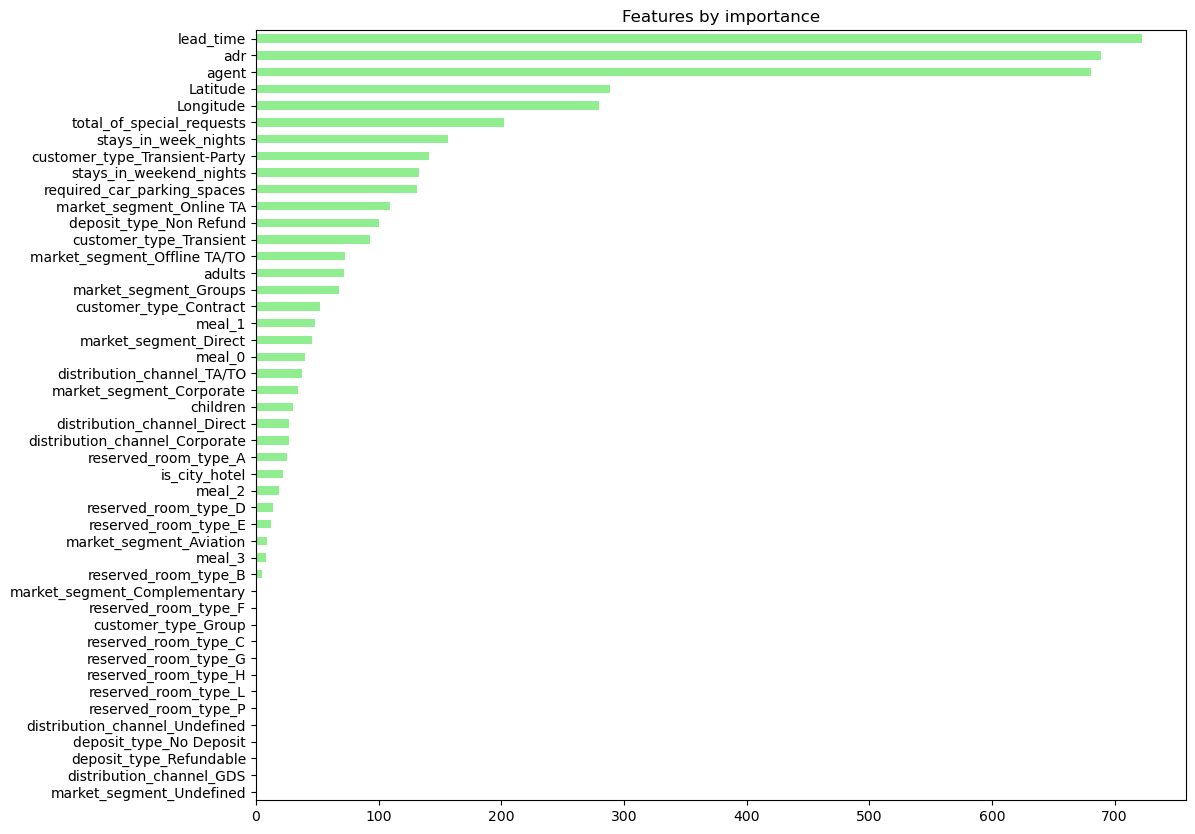

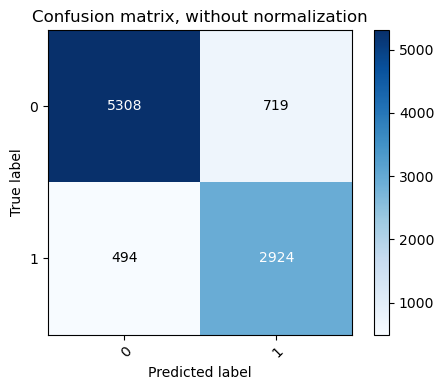

Normalized confusion matrix
[[0.8807035  0.1192965 ]
 [0.14452896 0.85547104]]


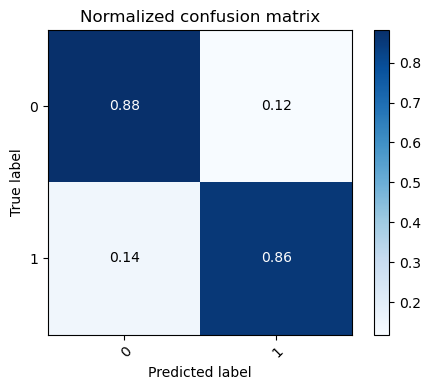

In [140]:
#With Feature update
mod1_featimps = validate_model_diagnostics((clf1,preprocess_pipeline_1), transformer_pipelines_1, X1_test, y1_test, target_labels)

In [141]:
mod1_featimps.sort_values(ascending=False).head(60)

lead_time                         722
adr                               689
agent                             681
Latitude                          289
Longitude                         280
total_of_special_requests         202
stays_in_week_nights              157
customer_type_Transient-Party     141
stays_in_weekend_nights           133
required_car_parking_spaces       131
market_segment_Online TA          109
deposit_type_Non Refund           100
customer_type_Transient            93
market_segment_Offline TA/TO       73
adults                             72
market_segment_Groups              68
customer_type_Contract             52
meal_1                             48
market_segment_Direct              46
meal_0                             40
distribution_channel_TA/TO         38
market_segment_Corporate           34
children                           30
distribution_channel_Direct        27
distribution_channel_Corporate     27
reserved_room_type_A               25
is_city_hote

In [142]:
list(mod1_featimps.sort_values(ascending=False).index)

['lead_time',
 'adr',
 'agent',
 'Latitude',
 'Longitude',
 'total_of_special_requests',
 'stays_in_week_nights',
 'customer_type_Transient-Party',
 'stays_in_weekend_nights',
 'required_car_parking_spaces',
 'market_segment_Online TA',
 'deposit_type_Non Refund',
 'customer_type_Transient',
 'market_segment_Offline TA/TO',
 'adults',
 'market_segment_Groups',
 'customer_type_Contract',
 'meal_1',
 'market_segment_Direct',
 'meal_0',
 'distribution_channel_TA/TO',
 'market_segment_Corporate',
 'children',
 'distribution_channel_Direct',
 'distribution_channel_Corporate',
 'reserved_room_type_A',
 'is_city_hotel',
 'meal_2',
 'reserved_room_type_D',
 'reserved_room_type_E',
 'market_segment_Aviation',
 'meal_3',
 'reserved_room_type_B',
 'reserved_room_type_F',
 'market_segment_Complementary',
 'reserved_room_type_C',
 'customer_type_Group',
 'reserved_room_type_P',
 'deposit_type_Refundable',
 'deposit_type_No Deposit',
 'distribution_channel_Undefined',
 'distribution_channel_GDS',
 '

## Model 2

In [143]:
#RFECV list of features
subset_2 = ['Latitude',
 'stays_in_weekend_nights',
 'required_car_parking_spaces',
 'Longitude',
 'adults',
 'stays_in_week_nights',
 'lead_time',
 'adr',
 'agent',
 'is_city_hotel',
 'total_of_special_requests',
 'deposit_type',
 'market_segment',
 'distribution_channel',
 'customer_type']

print(len(subset_2))

#parse out subset into separated attribute subsets
num_attribs_subset_2 = list(set(num_attribs).intersection(set(subset_2)))
bool_attribs_subset_2 = list(set(bool_attribs).intersection(set(subset_2)))
ohot_attribs_subset_2 = list(set(ohot_attribs).intersection(set(subset_2)))


print('\n num-pipeline \n',num_attribs_subset_2)
print('\n bool-pipeline \n',bool_attribs_subset_2)
print('\n ohot-pipeline \n',ohot_attribs_subset_2)


15

 num-pipeline 
 ['Latitude', 'stays_in_weekend_nights', 'required_car_parking_spaces', 'Longitude', 'adults', 'stays_in_week_nights', 'lead_time', 'adr', 'agent', 'total_of_special_requests']

 bool-pipeline 
 ['is_city_hotel']

 ohot-pipeline 
 ['customer_type', 'distribution_channel', 'deposit_type', 'market_segment']


In [145]:
LABEL = 'rfe-lgb-f1micro-subset_full'
BALANCE = class_weights #class_weights, "balanced_subsample"
SCORER = make_scorer(fbeta_score, average='micro',  beta=1)


In [146]:
opt_parameters = {'imputer_strategy_num': 'mean', 'imputer_strategy_bool': 'most_frequent', 'imputer_strategy_ohot': 'constant',
                  'imputer_add_indicator': False, 'bagging_freq': 10, 'min_data_in_leaf': 55, 'max_depth': 9,
                  'learning_rate': 0.04562981525659386, 'num_leaves': 38, 'min_sum_hessian_in_leaf': 7,
                  'reg_alpha': 0.005353347483937696, 'reg_lambda': 0.2588097376255871}
opt_parameters

{'imputer_strategy_num': 'mean',
 'imputer_strategy_bool': 'most_frequent',
 'imputer_strategy_ohot': 'constant',
 'imputer_add_indicator': False,
 'bagging_freq': 10,
 'min_data_in_leaf': 55,
 'max_depth': 9,
 'learning_rate': 0.04562981525659386,
 'num_leaves': 38,
 'min_sum_hessian_in_leaf': 7,
 'reg_alpha': 0.005353347483937696,
 'reg_lambda': 0.2588097376255871}

In [147]:

ohot_attribs = select_oHot_highCard_features(dfX_train, cat_attribs)

transformer_pipelines = make_pipeline(num_attribs_subset_2, bool_attribs_subset_2, ohot_attribs_subset_2, \
                                      opt_parameters['imputer_strategy_num'], \
                                      opt_parameters['imputer_strategy_bool'], \
                                      opt_parameters['imputer_strategy_ohot'], \
                                      opt_parameters['imputer_add_indicator'] \
                                     )
preprocess_pipeline = ColumnTransformer(transformer_pipelines, n_jobs=-1)

clf_opt_parameters = { x:y for x,y in opt_parameters.items() if 'imputer' not in x}

clf = lgb.LGBMClassifier(
        objective='binary',
        random_state = 123,
        bagging_seed = 123,
        boost_from_average = 'true',
        boost = 'gbdt',
        metric = 'binary_logloss',
        class_weight=BALANCE,
        num_threads = -1,
                        )
clf.set_params(**clf_opt_parameters)

_______________________________________
cat_attribs count: 6
['meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type']
_______________________________________
ohot_attribs count: 6
['meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type']


LGBMClassifier(bagging_freq=10, bagging_seed=123, boost='gbdt',
               boost_from_average='true', class_weight={0: 1.0, 1: 1.76},
               learning_rate=0.04562981525659386, max_depth=9,
               metric='binary_logloss', min_data_in_leaf=55,
               min_sum_hessian_in_leaf=7, num_leaves=38, num_threads=-1,
               objective='binary', random_state=123,
               reg_alpha=0.005353347483937696, reg_lambda=0.2588097376255871)

In [148]:

#no need to do anything here
# clf.set_params(**opt_parameters)
clf2 = deepcopy(clf) # copy from generic 'clf' to unique 'clf1'

# model1_pipeline = deepcopy(model_pipeline)
transformer_pipelines_2 = deepcopy(transformer_pipelines)
preprocess_pipeline_2 = deepcopy(preprocess_pipeline)

X2_train, y2_train = preprocess_pipeline_2.fit_transform(dfX_train[subset_2]), dfy_train.values
X2_test, y2_test = preprocess_pipeline_2.transform(dfX_test[subset_2]), dfy_test.values
X2_valid, y2_valid = preprocess_pipeline_2.transform(dfX_valid[subset_2]), dfy_valid.values

clf2.fit(X2_train, y2_train)



[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Info] Number o

LGBMClassifier(bagging_freq=10, bagging_seed=123, boost='gbdt',
               boost_from_average='true', class_weight={0: 1.0, 1: 1.76},
               learning_rate=0.04562981525659386, max_depth=9,
               metric='binary_logloss', min_data_in_leaf=55,
               min_sum_hessian_in_leaf=7, num_leaves=38, num_threads=-1,
               objective='binary', random_state=123,
               reg_alpha=0.005353347483937696, reg_lambda=0.2588097376255871)

pipe_type: tuple
__________________________________________________

model predict...
[LightGBM] [Warning] boosting is set with boosting_type=gbdt, will be overridden by boost=gbdt. Current value: boosting=gbdt
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
__________________________________________________

classification report...
Test Set:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      6027
           1       0.78      0.85      0.82      3418

    accuracy                           0.86      9445
   macro avg       0.85      0.86      0.85      9445
weighted avg       0.87      0.86      0.86      9445

_______

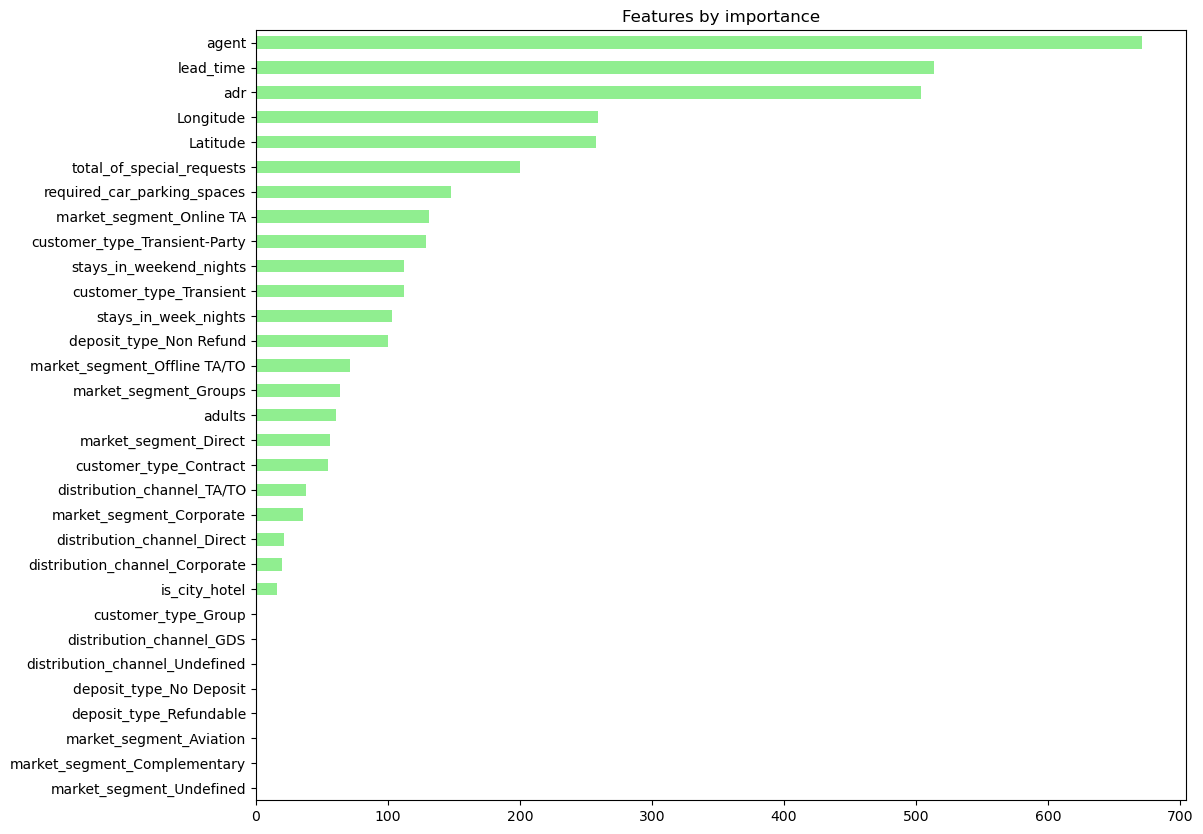

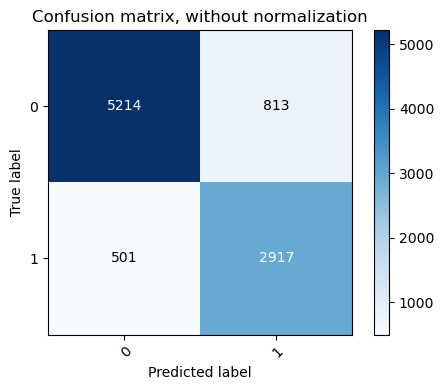

Normalized confusion matrix
[[0.86510702 0.13489298]
 [0.14657695 0.85342305]]


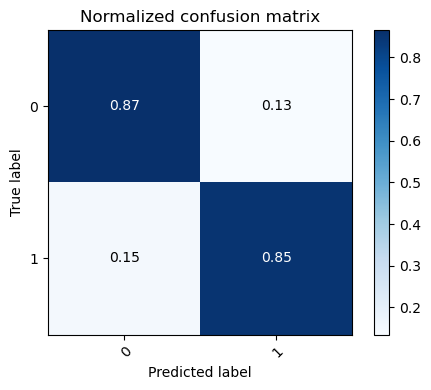

In [149]:
#With Feature update
mod2_featimps = validate_model_diagnostics((clf2,preprocess_pipeline_2), transformer_pipelines_2, X2_test, y2_test, target_labels)

In [150]:
mod2_featimps.sort_values(ascending=False).head(60)

agent                             671
lead_time                         514
adr                               504
Longitude                         259
Latitude                          258
total_of_special_requests         200
required_car_parking_spaces       148
market_segment_Online TA          131
customer_type_Transient-Party     129
stays_in_weekend_nights           112
customer_type_Transient           112
stays_in_week_nights              103
deposit_type_Non Refund           100
market_segment_Offline TA/TO       71
market_segment_Groups              64
adults                             61
market_segment_Direct              56
customer_type_Contract             55
distribution_channel_TA/TO         38
market_segment_Corporate           36
distribution_channel_Direct        21
distribution_channel_Corporate     20
is_city_hotel                      16
market_segment_Complementary        0
customer_type_Group                 0
distribution_channel_GDS            0
distribution

In [151]:
list(mod2_featimps.sort_values(ascending=False).index)

['agent',
 'lead_time',
 'adr',
 'Longitude',
 'Latitude',
 'total_of_special_requests',
 'required_car_parking_spaces',
 'market_segment_Online TA',
 'customer_type_Transient-Party',
 'stays_in_weekend_nights',
 'customer_type_Transient',
 'stays_in_week_nights',
 'deposit_type_Non Refund',
 'market_segment_Offline TA/TO',
 'market_segment_Groups',
 'adults',
 'market_segment_Direct',
 'customer_type_Contract',
 'distribution_channel_TA/TO',
 'market_segment_Corporate',
 'distribution_channel_Direct',
 'distribution_channel_Corporate',
 'is_city_hotel',
 'market_segment_Complementary',
 'customer_type_Group',
 'distribution_channel_GDS',
 'distribution_channel_Undefined',
 'deposit_type_No Deposit',
 'deposit_type_Refundable',
 'market_segment_Aviation',
 'market_segment_Undefined']

## Probability Calibration

In [152]:
CAL_KCV = 5

In [153]:
CalibratedModel_1_sig = CalibratedClassifierCV(clf1, cv=CAL_KCV, method='sigmoid')
CalibratedModel_1_sig.fit(X1_train, y1_train)

[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Info] Number o

CalibratedClassifierCV(cv=5,
                       estimator=LGBMClassifier(bagging_freq=10,
                                                bagging_seed=123, boost='gbdt',
                                                boost_from_average='true',
                                                class_weight={0: 1.0, 1: 1.76},
                                                learning_rate=0.06406110837454189,
                                                max_depth=16,
                                                metric='binary_logloss',
                                                min_data_in_leaf=45,
                                                min_sum_hessian_in_leaf=6,
                                                num_leaves=45, num_threads=-1,
                                                objective='binary',
                                                random_state=123,
                                                reg_alpha=0.0016801050513418046,
                                                reg_lambda=3.589972261687373))

In [154]:
CalibratedModel_1_iso = CalibratedClassifierCV(clf1, cv=CAL_KCV, method='isotonic')
CalibratedModel_1_iso.fit(X1_train, y1_train)

[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Info] Number o

CalibratedClassifierCV(cv=5,
                       estimator=LGBMClassifier(bagging_freq=10,
                                                bagging_seed=123, boost='gbdt',
                                                boost_from_average='true',
                                                class_weight={0: 1.0, 1: 1.76},
                                                learning_rate=0.06406110837454189,
                                                max_depth=16,
                                                metric='binary_logloss',
                                                min_data_in_leaf=45,
                                                min_sum_hessian_in_leaf=6,
                                                num_leaves=45, num_threads=-1,
                                                objective='binary',
                                                random_state=123,
                                                reg_alpha=0.0016801050513418046,
                                                reg_lambda=3.589972261687373),
                       method='isotonic')

In [155]:
CalibratedModel_2_sig = CalibratedClassifierCV(clf2, cv=CAL_KCV, method='sigmoid')
CalibratedModel_2_sig.fit(X2_train, y2_train)

[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Info] Number o

CalibratedClassifierCV(cv=5,
                       estimator=LGBMClassifier(bagging_freq=10,
                                                bagging_seed=123, boost='gbdt',
                                                boost_from_average='true',
                                                class_weight={0: 1.0, 1: 1.76},
                                                learning_rate=0.04562981525659386,
                                                max_depth=9,
                                                metric='binary_logloss',
                                                min_data_in_leaf=55,
                                                min_sum_hessian_in_leaf=7,
                                                num_leaves=38, num_threads=-1,
                                                objective='binary',
                                                random_state=123,
                                                reg_alpha=0.005353347483937696,
                                                reg_lambda=0.2588097376255871))

In [156]:
CalibratedModel_2_iso = CalibratedClassifierCV(clf2, cv=CAL_KCV, method='isotonic')
CalibratedModel_2_iso.fit(X2_train, y2_train)

[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Info] Number o

CalibratedClassifierCV(cv=5,
                       estimator=LGBMClassifier(bagging_freq=10,
                                                bagging_seed=123, boost='gbdt',
                                                boost_from_average='true',
                                                class_weight={0: 1.0, 1: 1.76},
                                                learning_rate=0.04562981525659386,
                                                max_depth=9,
                                                metric='binary_logloss',
                                                min_data_in_leaf=55,
                                                min_sum_hessian_in_leaf=7,
                                                num_leaves=38, num_threads=-1,
                                                objective='binary',
                                                random_state=123,
                                                reg_alpha=0.005353347483937696,
                                                reg_lambda=0.2588097376255871),
                       method='isotonic')

## Quantile Plots

In [157]:


def quantile_plot_by_class(model, X_test, y_test, target_labels,n_quants=10, returndata=False):
    """
    Produces quantile plots for each class from the model
    
    This function creates side by side quantile plots of predictions versus actuals.  Target classes
    with low counts should be less relied on that others.  
    Args:
        model: a fitted classifier to be used for predicting both class and probabilities
        X_test: numpy array for testing that's been preprocessed already
        y_test: associated target array for testing
        target_labels: list of available target clases in ascending order
        n_quants: the number of quantiles wanted.  This is already set to 10 for a decile plot
        returndata: a binary for the data for quantile plot to be returned if True
    Return:
        plots are displayed when this function is run
        df_bycls_forplot: summary table data used to create quantiles plots
    """

    import scipy
    
    print('X shape in: ',X_test.shape)

    #get all probs matrix
    preds_clf_final = pd.DataFrame(model.predict(X_test), columns=['Predictions'])
    probs_clf_final = pd.DataFrame(model.predict_proba(X_test))
    probs_clf_final = probs_clf_final.add_prefix('Probabilities_')

    #get actual array (code below ensures the index is reset)
    if isinstance(y_test, pd.Series):
        series_actual = pd.Series(y_test.values, name = 'Actual')
    if isinstance(y_test, np.ndarray):
        series_actual = pd.Series(y_test, name = 'Actual')

    #compile together
    predicted_df = pd.concat([series_actual, preds_clf_final, probs_clf_final], axis=1)

    #make copy to create consolidated deciles
    quantiles_df = predicted_df.copy()

    #create deciles for each class
    for t in target_labels:
        quantiles_series = pd.Series(pd.qcut(predicted_df['Probabilities_'+str(t)], n_quants, labels=False, duplicates='drop'), name = 'Quantiles_'+str(t))
        quantiles_df = pd.concat([quantiles_df,quantiles_series ],axis=1)

    #create binaries of each class for decile
    for t in target_labels:
        quantiles_df['ActualBinary_'+str(t)] = quantiles_df.Actual == t
        quantiles_df['PredsBinary_'+str(t)] = quantiles_df.Predictions == t

    #create empty dataframe for final data
    df_bycls_forplot = pd.DataFrame()

    #loop over classes for grouped deciles and format for display
    for t in target_labels:

        #groupby deciles
        score_df = quantiles_df.groupby('Quantiles_'+str(t),as_index=False).agg({'Probabilities_'+str(t): 'mean',
                                                              'ActualBinary_'+str(t): 'mean'})

        #cleanup dataframe for easy plotting
        df_forplot = pd.melt(score_df, id_vars=['Quantiles_'+str(t)], value_vars=['Probabilities_'+str(t), 'ActualBinary_'+str(t)], var_name='Model', value_name = 'Probability')
        df_forplot.rename(columns={'Quantiles_'+str(t): str(n_quants)+' Quantiles'},inplace=True)
        df_forplot['class'] = t
        df_bycls_forplot = pd.concat((df_bycls_forplot,df_forplot), axis=0)

    #setup scaffold side by side only
    fig, axs = plt.subplots(ncols=len(target_labels), figsize=(30, 5))

    #loop over each class to fill scaffold with graphs
    for t in target_labels:
        df_plot = df_bycls_forplot[df_bycls_forplot['class']==t]
        sns.lineplot(x= str(n_quants)+' Quantiles', y="Probability", hue="Model", data=df_plot, ax=axs[t])
    plt.show()

    #TODO - KS-TEST PRODUCES PVALUES FOR N=10.  SHOULD EITHER BE CORRECTED, OR LOOK AT ANDERSON TEST FOR SMALL SAMPLES
    # KS-test - print   
    df_bycls_forplot['decile_label'] = df_bycls_forplot.Model.str.split('_').str[0]
    df_kstest_pivot = pd.pivot_table(data=df_bycls_forplot,columns='decile_label', index=['class','10 Quantiles'],values='Probability')
    print(['class','ks_test','p_value'])
    for t in target_labels:
        print(t,np.round(scipy.stats.ks_2samp(df_kstest_pivot.loc[t,'ActualBinary'], df_kstest_pivot.loc[t,'Probabilities'], alternative='two-sided', mode='auto'),3))


    #optional return to get decile dataframe
    if returndata:
        print('Returned data is long form:  #quanties * #target_labeles * 2 <for actuals vs predictors>')
        return df_bycls_forplot

In [158]:
# models added to dictionary for looping
models_1_dct = {
    'clf1': clf1,
    'CalibratedModel_1_sig': CalibratedModel_1_sig,
    'CalibratedModel_1_iso': CalibratedModel_1_iso,

}

clf1
X shape in:  (9445, 46)
[LightGBM] [Warning] boosting is set with boosting_type=gbdt, will be overridden by boost=gbdt. Current value: boosting=gbdt
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] boosting is set with boosting_type=gbdt, will be overridden by boost=gbdt. Current value: boosting=gbdt
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_d

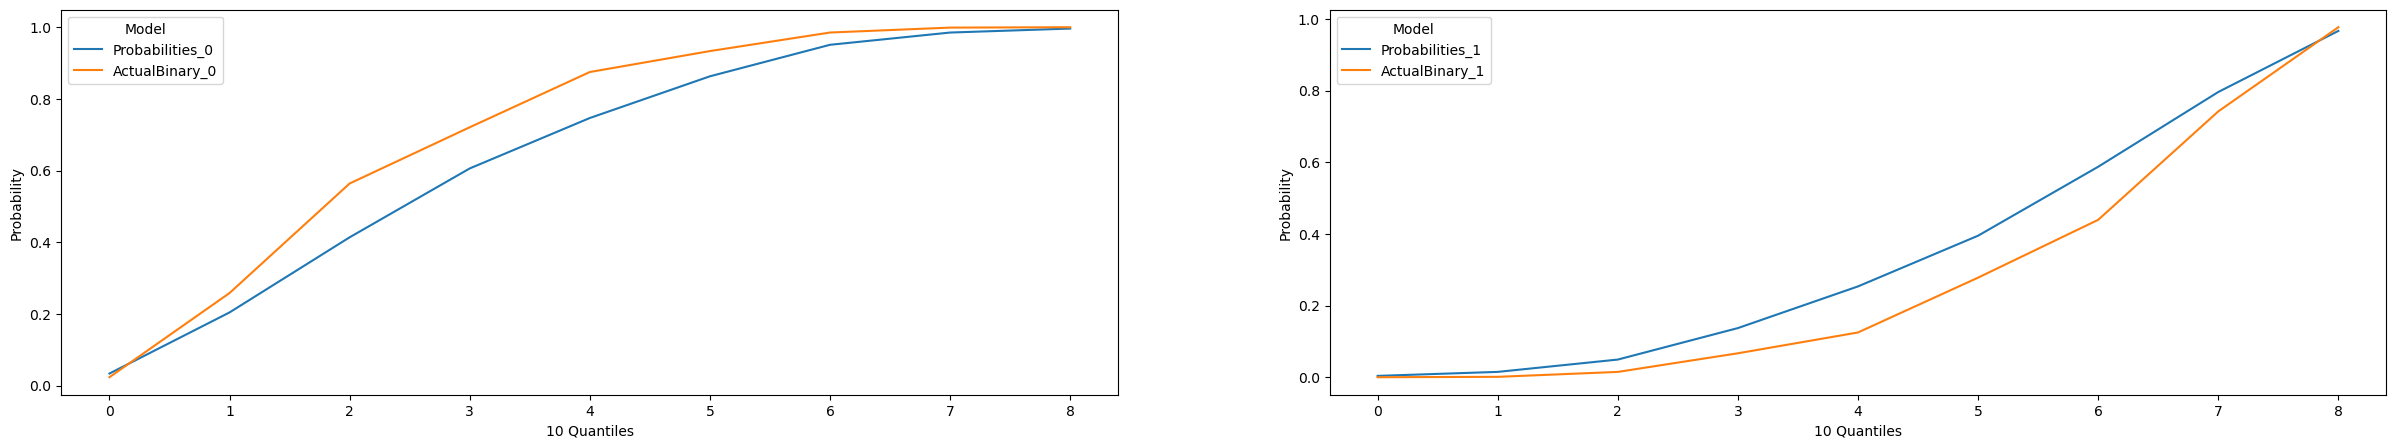

['class', 'ks_test', 'p_value']
0 [0.222 0.989]
1 [0.222 0.989]


CalibratedModel_1_sig
X shape in:  (9445, 46)
[LightGBM] [Warning] boosting is set with boosting_type=gbdt, will be overridden by boost=gbdt. Current value: boosting=gbdt
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] boosting is set with boosting_type=gbdt, will be overridden by boost=gbdt. Current value: boosting=gbdt
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min

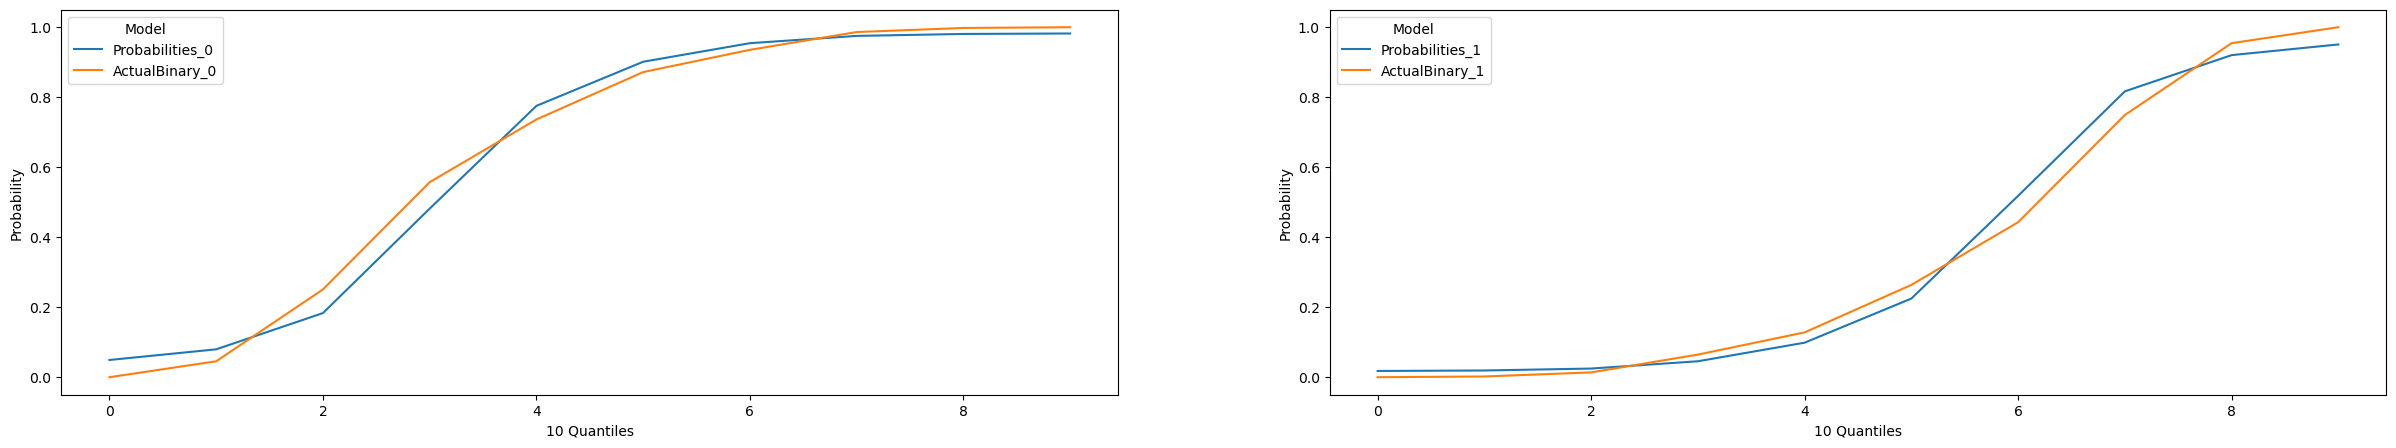

['class', 'ks_test', 'p_value']
0 [0.3   0.787]
1 [0.3   0.787]


CalibratedModel_1_iso
X shape in:  (9445, 46)
[LightGBM] [Warning] boosting is set with boosting_type=gbdt, will be overridden by boost=gbdt. Current value: boosting=gbdt
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] boosting is set with boosting_type=gbdt, will be overridden by boost=gbdt. Current value: boosting=gbdt
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min

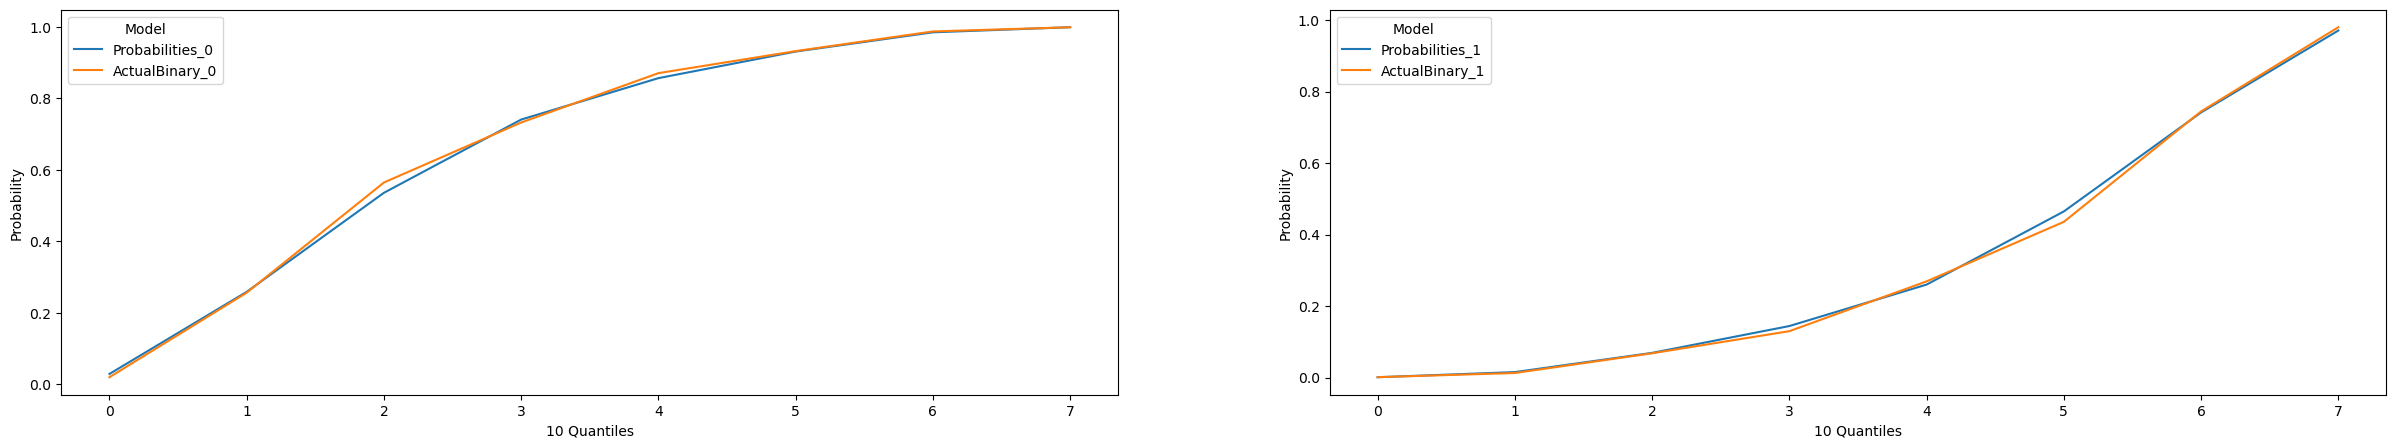

['class', 'ks_test', 'p_value']
0 [0.125 1.   ]
1 [0.125 1.   ]




In [159]:

for k,v in models_1_dct.items():
    print(60*"=")
    print(k)
    quantile_plot_by_class(v, X1_test, y1_test, target_labels, returndata=False)
    print('\n')

calibrated probabilities are close to the actuals for isotonic regression

In [160]:
models_2_dct = {
    'clf2': clf2,
    'clf2_calib_sig': CalibratedModel_2_sig,
    'clf2_calib_iso': CalibratedModel_2_iso,
}

clf2
X shape in:  (9445, 31)
[LightGBM] [Warning] boosting is set with boosting_type=gbdt, will be overridden by boost=gbdt. Current value: boosting=gbdt
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] boosting is set with boosting_type=gbdt, will be overridden by boost=gbdt. Current value: boosting=gbdt
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_d

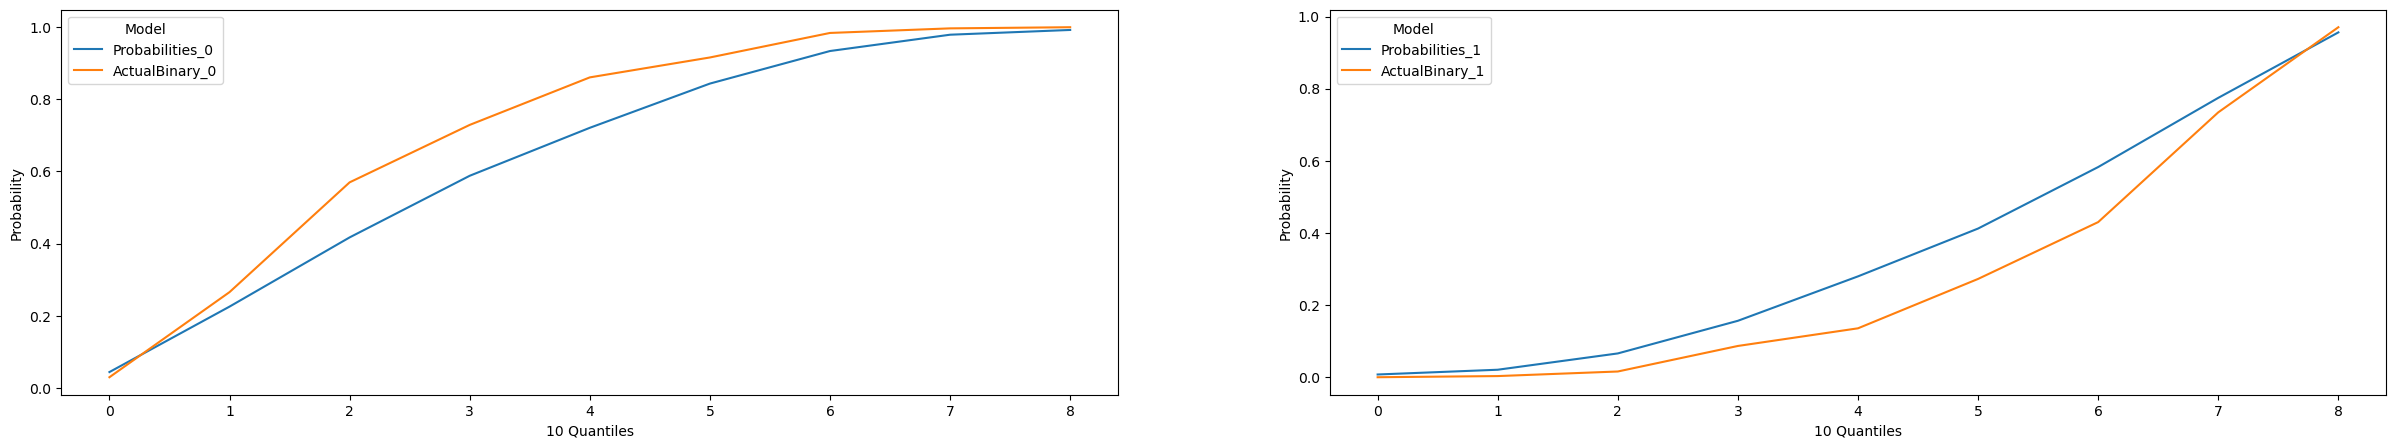

['class', 'ks_test', 'p_value']
0 [0.222 0.989]
1 [0.222 0.989]


clf2_calib_sig
X shape in:  (9445, 31)
[LightGBM] [Warning] boosting is set with boosting_type=gbdt, will be overridden by boost=gbdt. Current value: boosting=gbdt
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] boosting is set with boosting_type=gbdt, will be overridden by boost=gbdt. Current value: boosting=gbdt
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_i

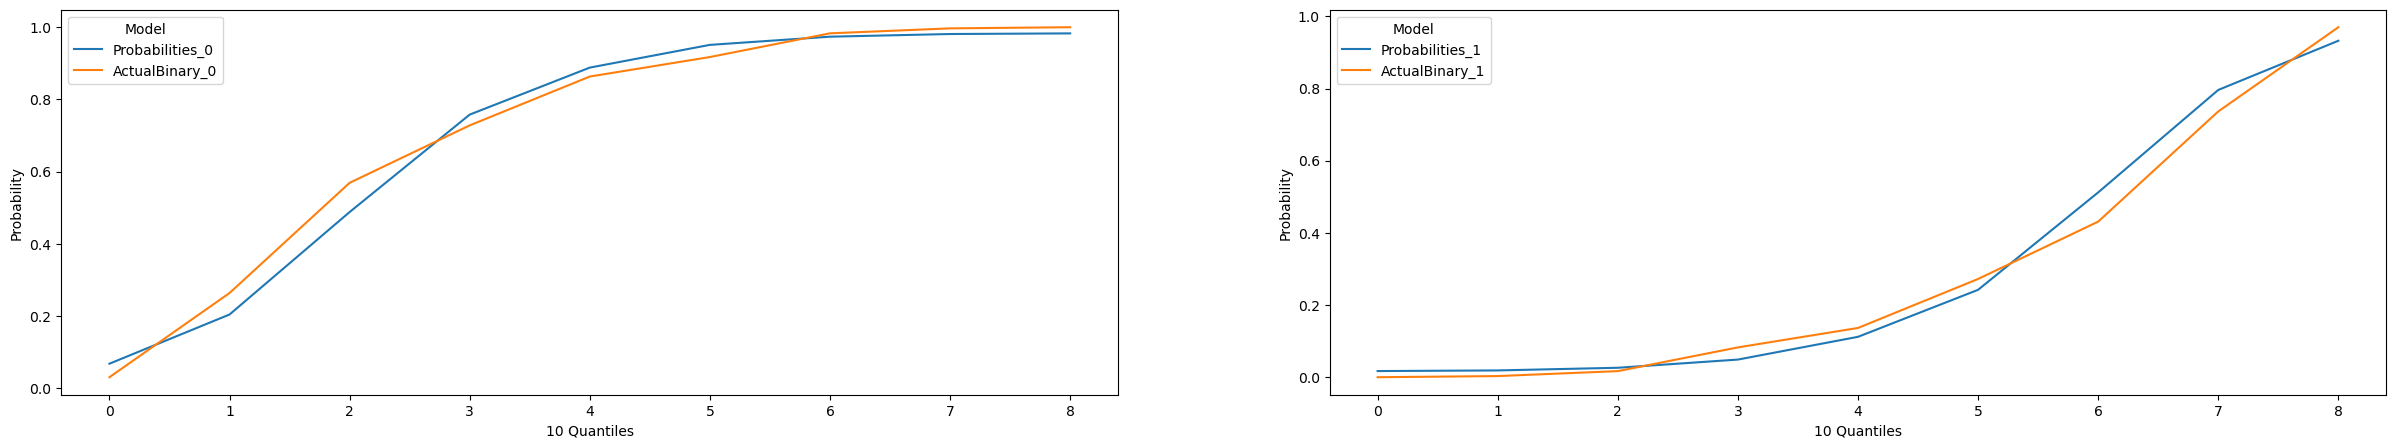

['class', 'ks_test', 'p_value']
0 [0.333 0.73 ]
1 [0.333 0.73 ]


clf2_calib_iso
X shape in:  (9445, 31)
[LightGBM] [Warning] boosting is set with boosting_type=gbdt, will be overridden by boost=gbdt. Current value: boosting=gbdt
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] boosting is set with boosting_type=gbdt, will be overridden by boost=gbdt. Current value: boosting=gbdt
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_i

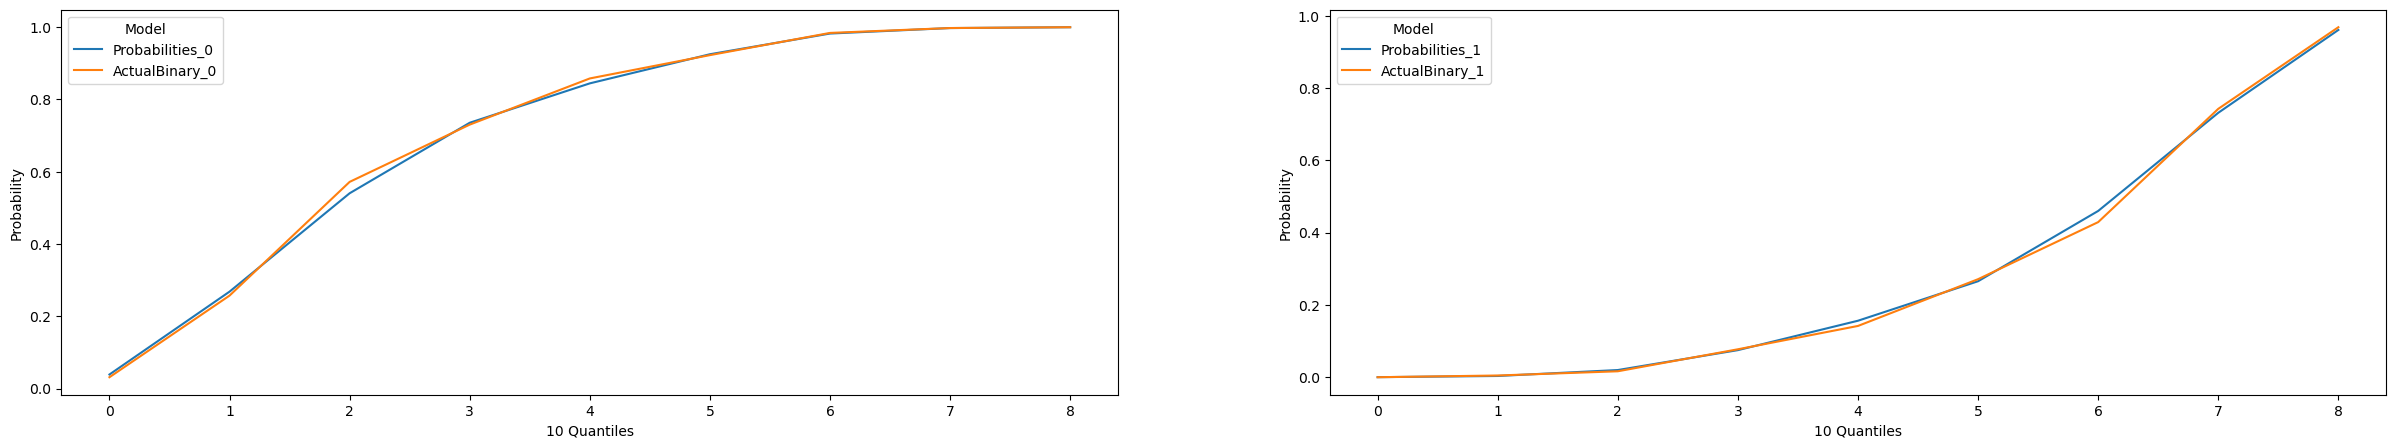

['class', 'ks_test', 'p_value']
0 [0.111 1.   ]
1 [0.111 1.   ]




In [161]:
for k,v in models_2_dct.items():
    print(60*"=")
    print(k)
    quantile_plot_by_class(v, X2_test, y2_test, target_labels, returndata=False)
    print('\n')

calibrated probabilities are closest for isotonic regression

Model 1 is better in predicting probabilities as the actuals and probabilities apeear closest to each other in the plots

## Check future year
Check the selected model (model 1) on a future year (2017) and compare it to the trained years to check for overfitting

In [162]:

def check_future_years(clf, calib_clf, prep_pipe, subset, df_in, target, SEASONYEAR, CHK_FUTURE_LS, SEGMENT_NUM, target_labels):
    """
    Run diagnostics on specific years with chosen best model
    
    The functions calculates metrics on accuracy of prob vs actual proportions, produces quantile 
    plots and confusion matrices.
    
    Args:
        clf: chosen best classifier of the two models
        calib_clf: the calibrated classifier
        prep_pipe: the preprocessing pipeline for the model
        subset: the list of subsetted features (or just list of full featurs if appropriate)
        df_in:  the full dataframe
        target: the object with the name of the target variable
        SEASONYEAR: the object with the name of the variable for season year
        CHK_FUTURE_LS: the list of seasonyears to run the function on
        SEGMENT_NUM: the numeric version of the customer segment.  for example 0=churn, 1=sgb, etc.
        target_labels: the list of classes in the target sorted in order
        
    Return: no returns, the function produces displayed output  
    """
    
    print('data in shape: ',df_in.shape)

    #create dataframe withs subset features only, the target, and only the years necessary.
    dfXy_in = df_in[df_in[SEASONYEAR].isin(CHK_FUTURE_LS)][subset+[target]].copy()
    print('raw data shape: ',dfXy_in.shape)

    #preprocess and creat numpy arrays of the data 
    X_fut, y_fut = prep_pipe.transform(dfXy_in[subset]), dfXy_in[target].values

    print('feature data shape: ',X_fut.shape)

    #create dataframe of prob and class predictions with actuals for comparison
    df_preds = pd.DataFrame(calib_clf.predict_proba(X_fut))
    df_preds['preds'] = clf.predict(X_fut)
    df_preds['actuals'] = y_fut
    df_preds['Actual_Binary'] = df_preds['actuals'] == SEGMENT_NUM 

    #comparison of segment probs and actual proportion
    print('mean segment probability:     ',np.round(df_preds[SEGMENT_NUM].mean(),3))
    print('mean % actual target segment: ',np.round(df_preds['Actual_Binary'].mean(),3),'\n')

    #display decile plots
    quantile_plot_by_class(calib_clf, X_fut, y_fut, target_labels)

    #display confusion matrix
    create_plot_conf_matrix_build(df_preds['actuals'], df_preds['preds'], target_labels)



________________________
2015 

data in shape:  (119390, 41)
raw data shape:  (21996, 19)
feature data shape:  (21996, 46)
[LightGBM] [Warning] boosting is set with boosting_type=gbdt, will be overridden by boost=gbdt. Current value: boosting=gbdt
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] boosting is set with boosting_type=gbdt, will be overridden by boost=gbdt. Current value: boosting=gbdt
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [W

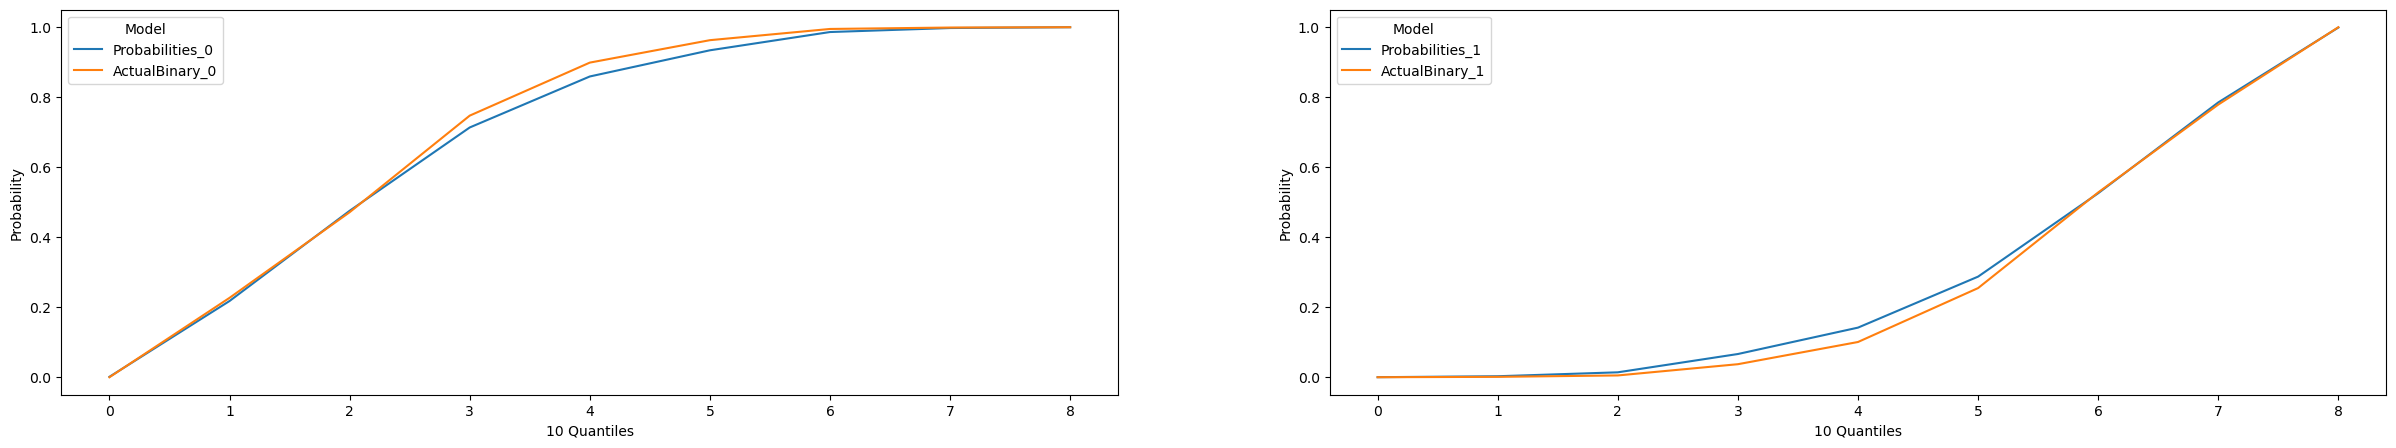

['class', 'ks_test', 'p_value']
0 [0.111 1.   ]
1 [0.111 1.   ]
Confusion matrix, without normalization
[[12175  1679]
 [  778  7364]]


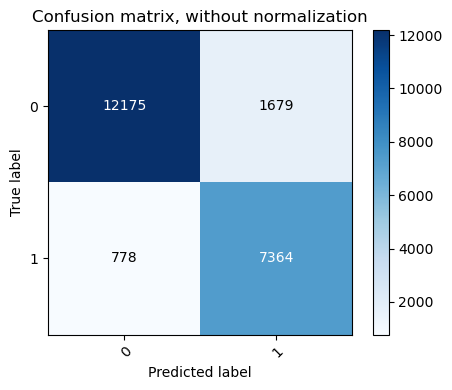

Normalized confusion matrix
[[0.87880756 0.12119244]
 [0.09555392 0.90444608]]


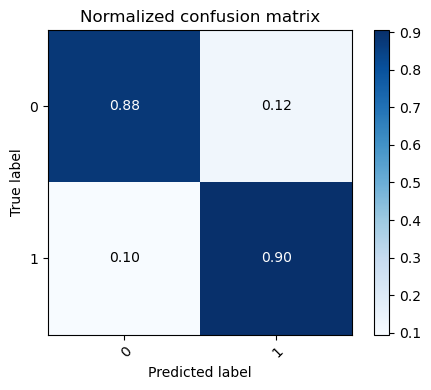

________________________
2016 

data in shape:  (119390, 41)
raw data shape:  (56707, 19)
feature data shape:  (56707, 46)
[LightGBM] [Warning] boosting is set with boosting_type=gbdt, will be overridden by boost=gbdt. Current value: boosting=gbdt
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] boosting is set with boosting_type=gbdt, will be overridden by boost=gbdt. Current value: boosting=gbdt
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [W

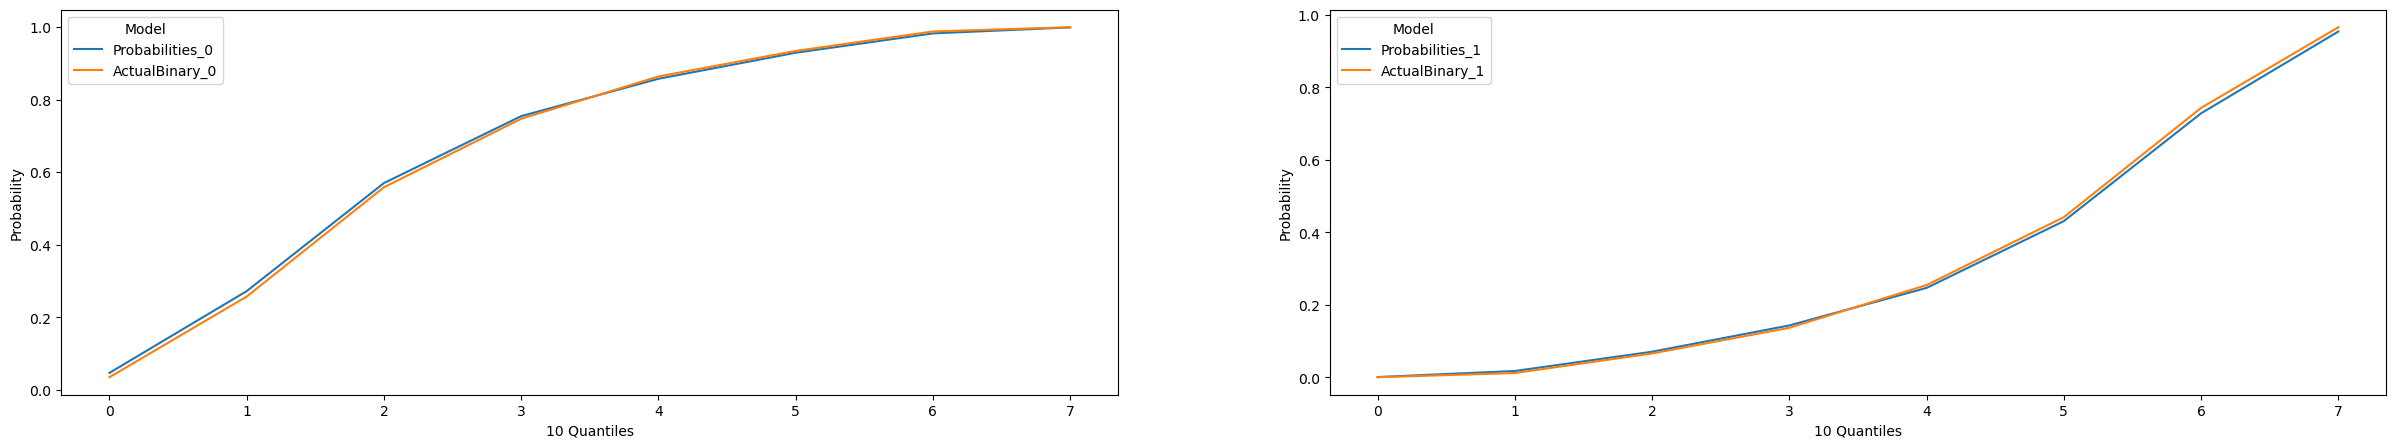

['class', 'ks_test', 'p_value']
0 [0.125 1.   ]
1 [0.125 1.   ]
Confusion matrix, without normalization
[[32276  4094]
 [ 3164 17173]]


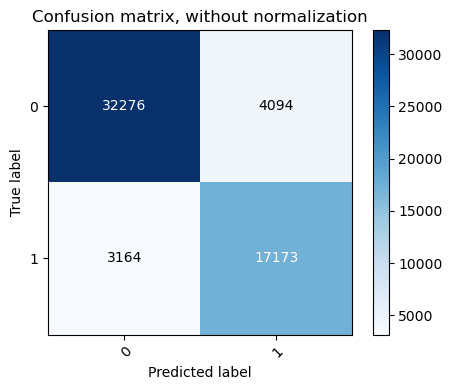

Normalized confusion matrix
[[0.8874347 0.1125653]
 [0.1555785 0.8444215]]


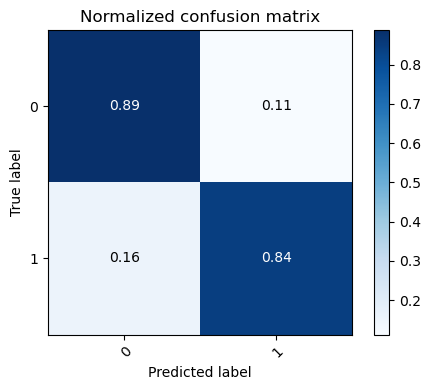

________________________
2017 

data in shape:  (119390, 41)
raw data shape:  (40687, 19)
feature data shape:  (40687, 46)
[LightGBM] [Warning] boosting is set with boosting_type=gbdt, will be overridden by boost=gbdt. Current value: boosting=gbdt
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] boosting is set with boosting_type=gbdt, will be overridden by boost=gbdt. Current value: boosting=gbdt
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [W

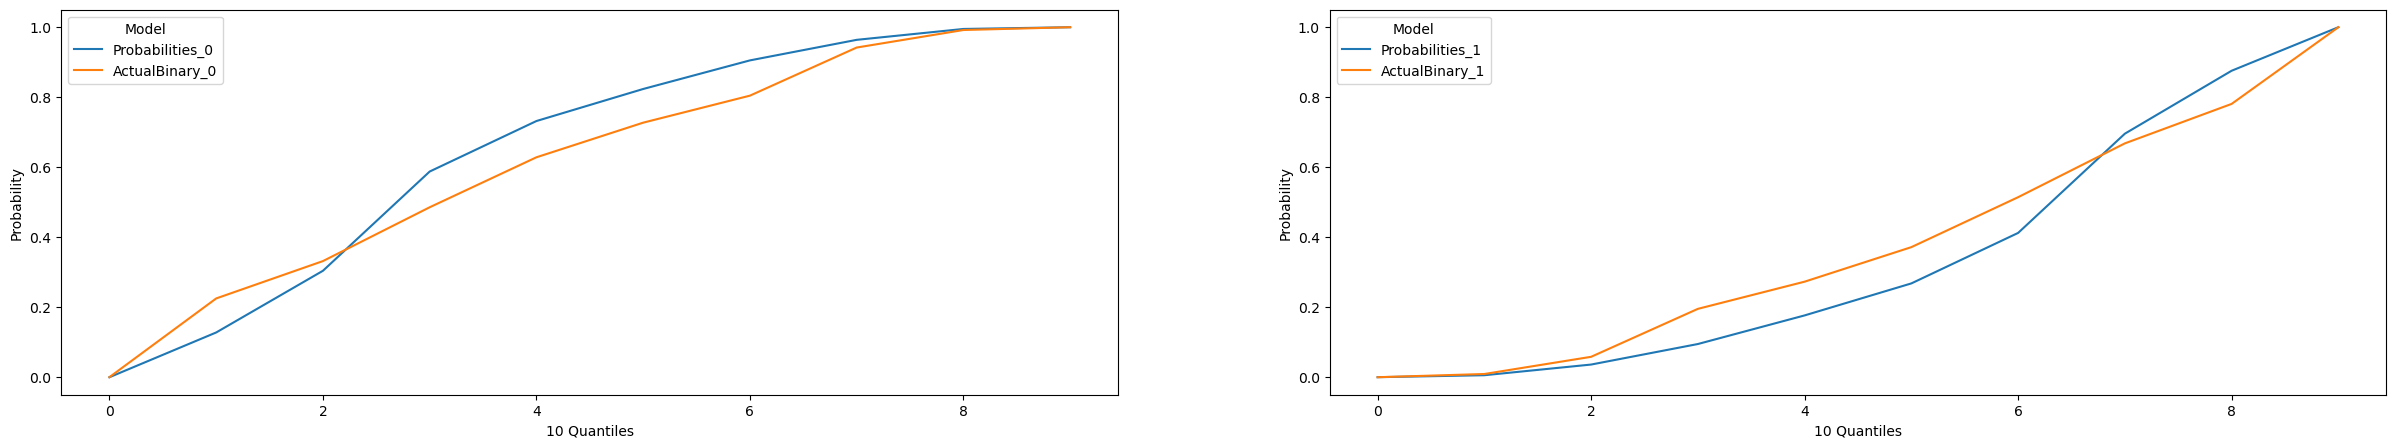

['class', 'ks_test', 'p_value']
0 [0.2   0.994]
1 [0.2   0.994]
Confusion matrix, without normalization
[[21307  3635]
 [ 4120 11625]]


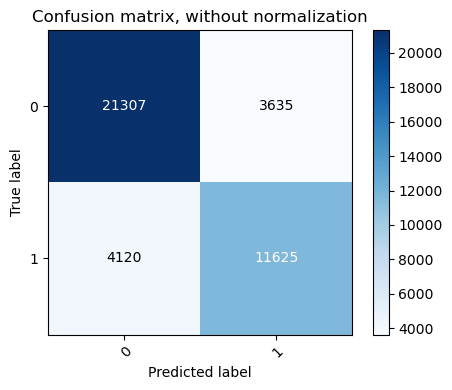

Normalized confusion matrix
[[0.85426189 0.14573811]
 [0.26167037 0.73832963]]


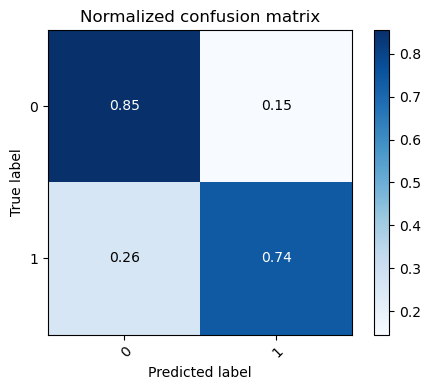

In [163]:
# SEGMENT_NUM = Segment_num_dct[SEGMENT[0]] #grab first position of a list of 1 element
SEGMENT_NUM = 1

for y in [2015,2016,2017]:
    print("________________________")
    print(y,'\n')
    check_future_years(clf1, CalibratedModel_1_iso, preprocess_pipeline_1, subset_1, df_allYear, target, SEASONYEAR, [y], SEGMENT_NUM,target_labels)
    


The model does a good job in predictingprobabilities on an unseen data. it is underpredicting for lower quantiles and a little over predicting for upper quantiles for predicting class 1

## Final Model
Final model training and validation and accuracy calculation. This model should be serialized for deployment

In [164]:
subset = subset_1
display(
    len(subset),
    subset
)

#parse out subset into separated attribute subsets
num_attribs_subset = list(set(num_attribs).intersection(set(subset)))
bool_attribs_subset = list(set(bool_attribs).intersection(set(subset)))
ohot_attribs_subset = list(set(ohot_attribs).intersection(set(subset)))

print('\n num-pipeline \n',num_attribs_subset)
print('\n bool-pipeline \n',bool_attribs_subset)
print('\n ohot-pipeline \n',ohot_attribs_subset)


18

['lead_time',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'agent',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'Latitude',
 'Longitude',
 'is_city_hotel',
 'meal',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'deposit_type',
 'customer_type']


 num-pipeline 
 ['Latitude', 'stays_in_weekend_nights', 'required_car_parking_spaces', 'children', 'Longitude', 'adults', 'stays_in_week_nights', 'lead_time', 'adr', 'agent', 'total_of_special_requests']

 bool-pipeline 
 ['is_city_hotel']

 ohot-pipeline 
 ['customer_type', 'deposit_type', 'distribution_channel', 'reserved_room_type', 'meal', 'market_segment']


In [165]:
class_weights

{1: 1.76, 0: 1.0}

In [166]:

# INSTRUCTION: ADD BEST CLASSIFIER HERE.  IF YOU USED 'CLASS_WEIGHTS', THEN ADD THE ACTUAL DICTIONARY HERE AS WELL

# INSTRUCTION: ADD OPT_PARAMETERS DICTIONARY HERE 
opt_parameters = {'bagging_freq': 10, 'min_data_in_leaf': 45, 'max_depth': 16,
                  'learning_rate': 0.06406110837454189, 'num_leaves': 45, 'min_sum_hessian_in_leaf': 6,
                  'reg_alpha': 0.0016801050513418046, 'reg_lambda': 3.589972261687373}

# clf_opt_parameters = { x:y for x,y in opt_parameters.items() if 'imputer' not in x}
# print(clf_opt_parameters)

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean', add_indicator=False)),    
    ('robust_scaler', RobustScaler())
])
ohot_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', add_indicator=False)),
        ('ohot_encoder', OneHotEncoder(handle_unknown='ignore'))
    ])
bool_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', add_indicator=False)), 
    ])

transformer_pipelines = [
('num', num_pipeline, num_attribs_subset),
('ohot', ohot_pipeline, ohot_attribs_subset),
('bool', bool_pipeline, bool_attribs_subset),
]

preprocess_pipeline = ColumnTransformer(transformer_pipelines, n_jobs=-1)

clf = lgb.LGBMClassifier(
        objective='binary',
        random_state = 123,
        bagging_seed = 123,
        boost_from_average = 'true',
        boost = 'gbdt',
        metric = 'binary_logloss',
        class_weight={1: 1.76, 0: 1.0},
        num_threads = -1,
                        )
clf.set_params(**opt_parameters)


# INSTRUCTIONS: TRANSFORMERS HERE, ENSURE SUBSET IS ADDED TO CODE 'dfX_train[subset]'
# THESE PREPROCESSED DATASETS ARE USED FOR CALIBRATION
X_train, y_train = preprocess_pipeline.fit_transform(dfX_train[subset]), dfy_train.values
X_test, y_test = preprocess_pipeline.transform(dfX_test[subset]), dfy_test.values
X_valid, y_valid = preprocess_pipeline.transform(dfX_valid[subset]), dfy_valid.values

# Keep this
clf_fit = deepcopy(clf)
clf_fit.fit(X_train, y_train)

#INSTRUCTIONS: ADD OPTIMAL PARAMETERS FOR CALIBRATEDCLASSIFIERCV HERE:
calib_clf = CalibratedClassifierCV(clf, cv=5, method='isotonic')

#IF USING 'PREFIT', THEN fit(X_valid, y_valid), IF NOT USING 'PREFIT' THEN fit(X_train, y_train)
calib_clf.fit(X_train, y_train)


[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Info] Number o

CalibratedClassifierCV(cv=5,
                       estimator=LGBMClassifier(bagging_freq=10,
                                                bagging_seed=123, boost='gbdt',
                                                boost_from_average='true',
                                                class_weight={0: 1.0, 1: 1.76},
                                                learning_rate=0.06406110837454189,
                                                max_depth=16,
                                                metric='binary_logloss',
                                                min_data_in_leaf=45,
                                                min_sum_hessian_in_leaf=6,
                                                num_leaves=45, num_threads=-1,
                                                objective='binary',
                                                random_state=123,
                                                reg_alpha=0.0016801050513418046,
                                                reg_lambda=3.589972261687373),
                       method='isotonic')

In [167]:
#BOTH THE CLF AND THE CALIBRATED CLF ARE USED FOR DIAGNOSTIC PURPOSES, THOUGH THE FINAL SERIALIZED MODEL IS THE CALIBRATED VERSION
modelclf_pipeline = Pipeline([
        ("preprocess_pipeline", preprocess_pipeline),
        ("clf", clf),
        ])

modelcalib_pipeline = Pipeline([
        ("preprocess_pipeline", preprocess_pipeline),
        ("calib_clf", calib_clf),
        ])

modelclf_pipeline.fit(dfX_train, dfy_train)

[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Info] Number o

Pipeline(steps=[('preprocess_pipeline',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('robust_scaler',
                                                                   RobustScaler())]),
                                                  ['Latitude',
                                                   'stays_in_weekend_nights',
                                                   'required_car_parking_spaces',
                                                   'children', 'Longitude',
                                                   'adults',
                                                   'stays_in_week_nights',
                                                   'lead_time', 'adr', 'agent',
                                                   'total_of_special_requests']),
                                                 ('oh...
                 LGBMClassifier(bagging_freq=10, bagging_seed=123, boost='gbdt',
                                boost_from_average='true',
                                class_weight={0: 1.0, 1: 1.76},
                                learning_rate=0.06406110837454189, max_depth=16,
                                metric='binary_logloss', min_data_in_leaf=45,
                                min_sum_hessian_in_leaf=6, num_leaves=45,
                                num_threads=-1, objective='binary',
                                random_state=123,
                                reg_alpha=0.0016801050513418046,
                                reg_lambda=3.589972261687373))])

pipe_type: fullpipe
__________________________________________________

model predict...
[LightGBM] [Warning] boosting is set with boosting_type=gbdt, will be overridden by boost=gbdt. Current value: boosting=gbdt
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
__________________________________________________

classification report...
Test Set:
              precision    recall  f1-score   support

           0       0.92      0.89      0.90     35157
           1       0.81      0.86      0.84     19935

    accuracy                           0.88     55092
   macro avg       0.87      0.87      0.87     55092
weighted avg       0.88      0.88      0.88     55092

____

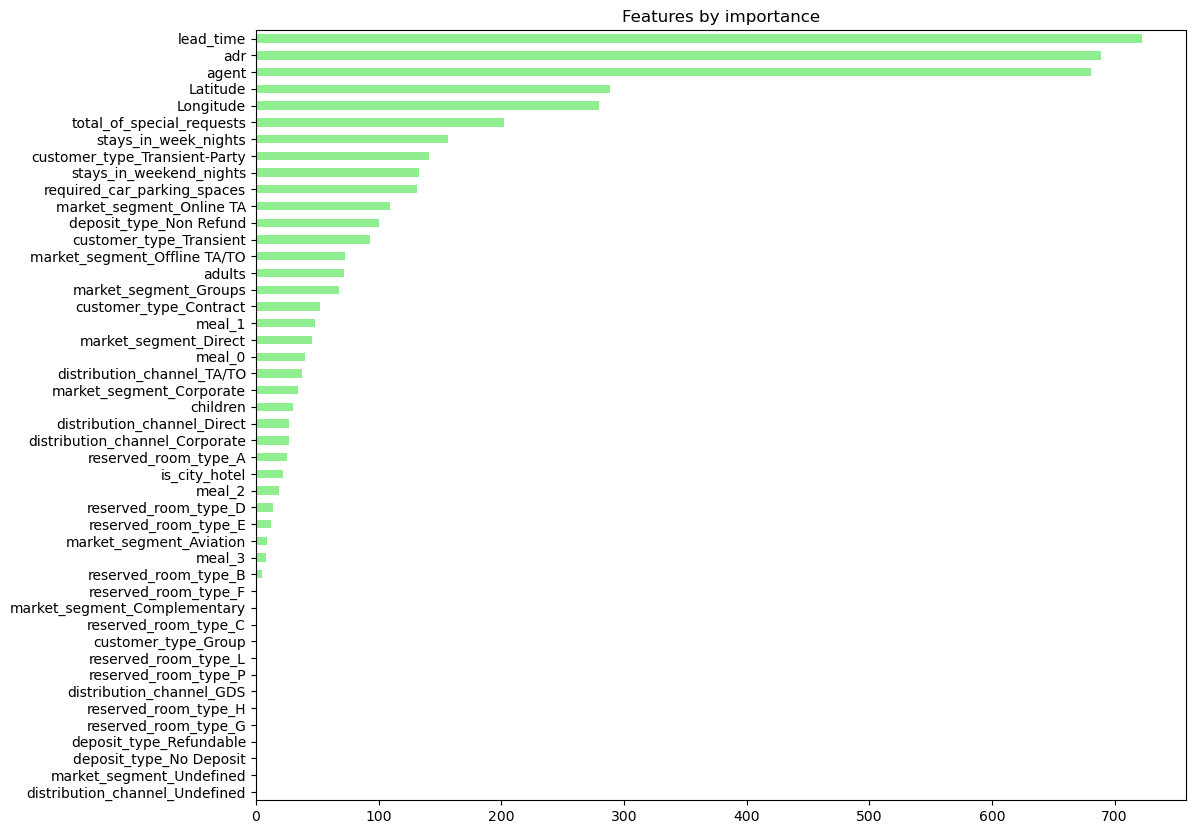

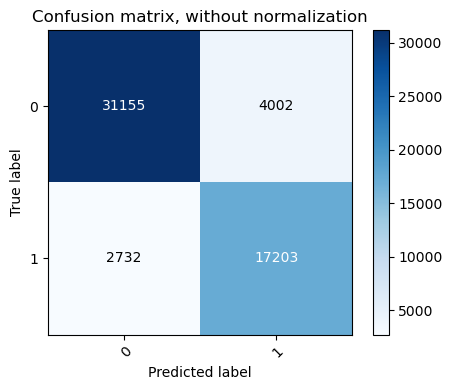

Normalized confusion matrix
[[0.88616776 0.11383224]
 [0.1370454  0.8629546 ]]


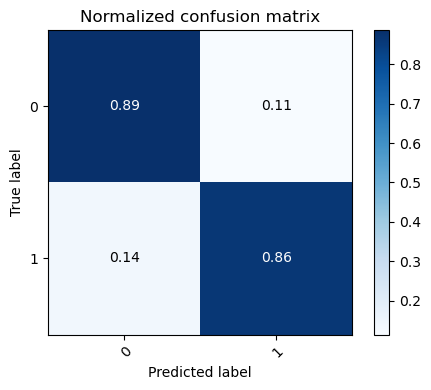

In [168]:
train_feat_imps = validate_model_diagnostics(modelclf_pipeline, transformer_pipelines, dfX_train, dfy_train, target_labels)


In [169]:
display(modelclf_pipeline.fit(dfX_train[subset],dfy_train))
display(modelcalib_pipeline.fit(dfX_train[subset],dfy_train))

[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Info] Number o

Pipeline(steps=[('preprocess_pipeline',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('robust_scaler',
                                                                   RobustScaler())]),
                                                  ['Latitude',
                                                   'stays_in_weekend_nights',
                                                   'required_car_parking_spaces',
                                                   'children', 'Longitude',
                                                   'adults',
                                                   'stays_in_week_nights',
                                                   'lead_time', 'adr', 'agent',
                                                   'total_of_special_requests']),
                                                 ('oh...
                 LGBMClassifier(bagging_freq=10, bagging_seed=123, boost='gbdt',
                                boost_from_average='true',
                                class_weight={0: 1.0, 1: 1.76},
                                learning_rate=0.06406110837454189, max_depth=16,
                                metric='binary_logloss', min_data_in_leaf=45,
                                min_sum_hessian_in_leaf=6, num_leaves=45,
                                num_threads=-1, objective='binary',
                                random_state=123,
                                reg_alpha=0.0016801050513418046,
                                reg_lambda=3.589972261687373))])

[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Info] Number o

Pipeline(steps=[('preprocess_pipeline',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('robust_scaler',
                                                                   RobustScaler())]),
                                                  ['Latitude',
                                                   'stays_in_weekend_nights',
                                                   'required_car_parking_spaces',
                                                   'children', 'Longitude',
                                                   'adults',
                                                   'stays_in_week_nights',
                                                   'lead_time', 'adr', 'agent',
                                                   'total_of_special_requests']),
                                                 ('oh...
                                        estimator=LGBMClassifier(bagging_freq=10,
                                                                 bagging_seed=123,
                                                                 boost='gbdt',
                                                                 boost_from_average='true',
                                                                 class_weight={0: 1.0,
                                                                               1: 1.76},
                                                                 learning_rate=0.06406110837454189,
                                                                 max_depth=16,
                                                                 metric='binary_logloss',
                                                                 min_data_in_leaf=45,
                                                                 min_sum_hessian_in_leaf=6,
                                                                 num_leaves=45,
                                                                 num_threads=-1,
                                                                 objective='binary',
                                                                 random_state=123,
                                                                 reg_alpha=0.0016801050513418046,
                                                                 reg_lambda=3.589972261687373),
                                        method='isotonic'))])

[LightGBM] [Warning] boosting is set with boosting_type=gbdt, will be overridden by boost=gbdt. Current value: boosting=gbdt
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] boosting is set with boosting_type=gbdt, will be overridden by boost=gbdt. Current value: boosting=gbdt
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Wa

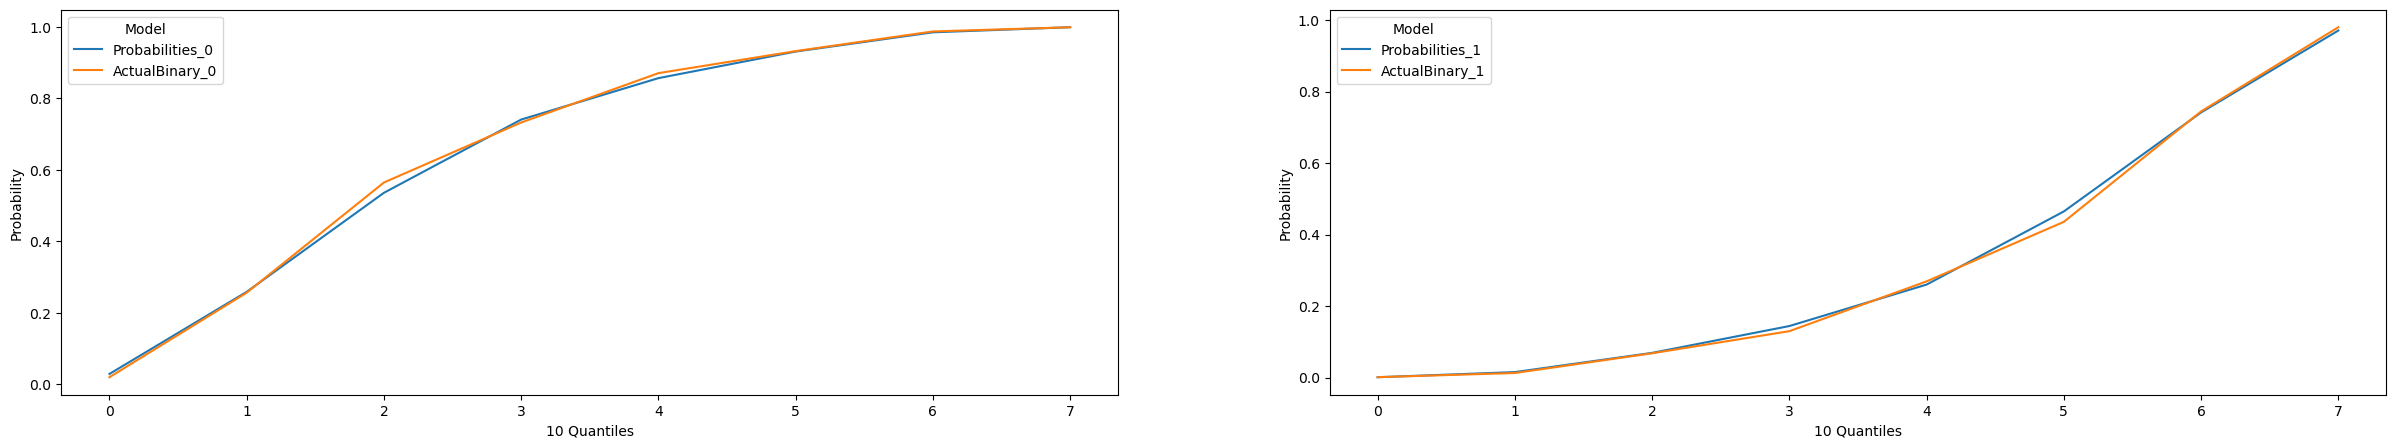

['class', 'ks_test', 'p_value']
0 [0.125 1.   ]
1 [0.125 1.   ]
Confusion matrix, without normalization
[[5308  719]
 [ 494 2924]]


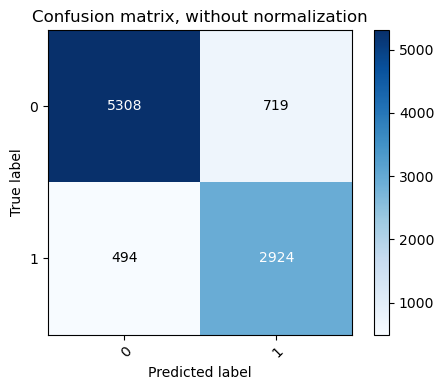

Normalized confusion matrix
[[0.8807035  0.1192965 ]
 [0.14452896 0.85547104]]


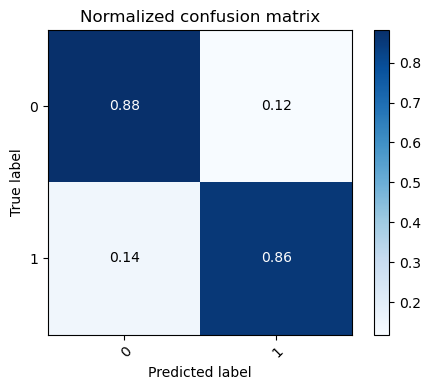

In [170]:
yprob_test, y_test = modelcalib_pipeline.predict_proba(dfX_test[subset]), dfy_test.values

df_preds = pd.DataFrame(yprob_test)
df_preds['preds'] = modelclf_pipeline.predict(dfX_test[subset])
df_preds['actuals'] = y_test

print('mean segment probability:     ',np.round(df_preds.mean(),3))
print('mean % actual target segment: ',np.round(df_preds['actuals'].mean(),3),'\n')

quantile_plot_by_class(modelcalib_pipeline, dfX_test[subset], y_test, target_labels)

create_plot_conf_matrix_build(df_preds['actuals'], df_preds['preds'], target_labels)


In [171]:
# modelcalib_pipeline
train_score = modelcalib_pipeline.score(dfX_train[subset], dfy_train)
valid_score = modelcalib_pipeline.score(dfX_valid[subset], dfy_valid)
test_score = modelcalib_pipeline.score(dfX_test[subset], dfy_test)
print('train acc: ', train_score)
print('valid acc: ', valid_score)
print('test acc: ', test_score)

[LightGBM] [Warning] boosting is set with boosting_type=gbdt, will be overridden by boost=gbdt. Current value: boosting=gbdt
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] boosting is set with boosting_type=gbdt, will be overridden by boost=gbdt. Current value: boosting=gbdt
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Wa

All the three accuracies are equal depicting no overfitting in the model

In [172]:
df_preds

0    1  preds  actuals
0    0.07 0.93      1        1
1    0.00 1.00      1        1
2    0.25 0.75      1        0
3    1.00 0.00      0        0
4    1.00 0.00      0        0
...   ...  ...    ...      ...
9440 0.99 0.01      0        0
9441 0.99 0.01      0        0
9442 0.26 0.74      1        1
9443 1.00 0.00      0        0
9444 0.99 0.01      0        0

[9445 rows x 4 columns]

## Charts to check probabilities vs Feature
Calculate the probabilities for 2017 and compare those to the top performing features in the dataset to check how the features affect the likelihood of cancellations

In [173]:
#create dataframe withs subset features only, the target, and only the years necessary.
dfXy_in = df_allYear[df_allYear[timevar] == 2017][subset+[target]].copy()
print('raw data shape: ',dfXy_in.shape)

#preprocess and creat numpy arrays of the data 
X_fut, y_fut = preprocess_pipeline_1.transform(dfXy_in[subset]), dfXy_in[target].values

print('feature data shape: ',X_fut.shape)

#create dataframe of prob and class predictions with actuals for comparison
df_preds = pd.DataFrame(CalibratedModel_1_iso.predict_proba(X_fut))
df_preds = df_preds.rename(columns = {0: 'Prob_0', 1: 'Prob_1'})
df_preds['Predicted_class'] = clf1.predict(X_fut)
df_preds

raw data shape:  (40687, 19)
feature data shape:  (40687, 46)
[LightGBM] [Warning] boosting is set with boosting_type=gbdt, will be overridden by boost=gbdt. Current value: boosting=gbdt
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] boosting is set with boosting_type=gbdt, will be overridden by boost=gbdt. Current value: boosting=gbdt
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will

Prob_0  Prob_1  Predicted_class
0        0.63    0.37                1
1        0.89    0.11                0
2        0.95    0.05                0
3        0.24    0.76                1
4        0.30    0.70                1
...       ...     ...              ...
40682    0.94    0.06                0
40683    0.69    0.31                0
40684    0.34    0.66                1
40685    0.72    0.28                0
40686    1.00    0.00                0

[40687 rows x 3 columns]

In [174]:
dfXy_in.reset_index(drop=True, inplace=True)
df_preds.reset_index(drop=True, inplace=True)

df_final_2017 = pd.concat([dfXy_in, df_preds], axis = 1)

## Lead Time

In [175]:
df_final_2017.lead_time.describe()

count   40687.00
mean      109.26
std       107.94
min         0.00
25%        23.00
50%        80.00
75%       164.50
max       629.00
Name: lead_time, dtype: float64

<Figure size 1000x600 with 0 Axes>

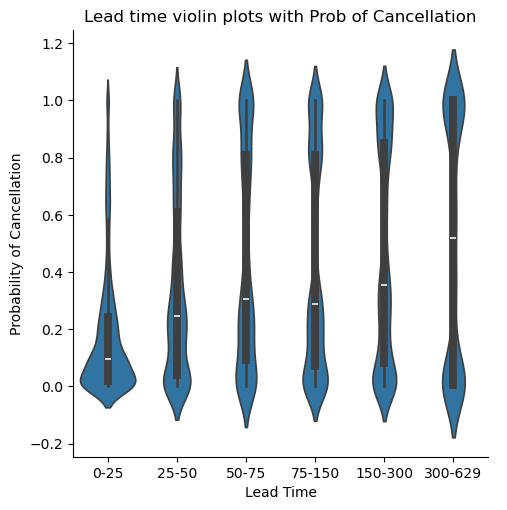

In [181]:
#show figure:
# Define bins for 'x_continuous'
bins = [0, 25, 50, 75, 150, 300, 629]  # Customize your bin edges
df_final_2017['lead_time_binned'] = pd.cut(df_final_2017['lead_time'], bins=bins, labels=[f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)])

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.catplot(x='lead_time_binned', y='Prob_1', data=df_final_2017, kind = 'violin')

plt.xlabel('Lead Time')
plt.ylabel('Probability of Cancellation')
plt.title('Lead time violin plots with Prob of Cancellation')
plt.show()

Maximum reservations have a lower lead time. But the ones having a higher lead time have a higher probability of cancellation which is opposite of what we saw in the box plot for lead time. This discrepancy is because of high volumn of reservations having a lower lead time

## Deposit Type

<Figure size 1000x600 with 0 Axes>

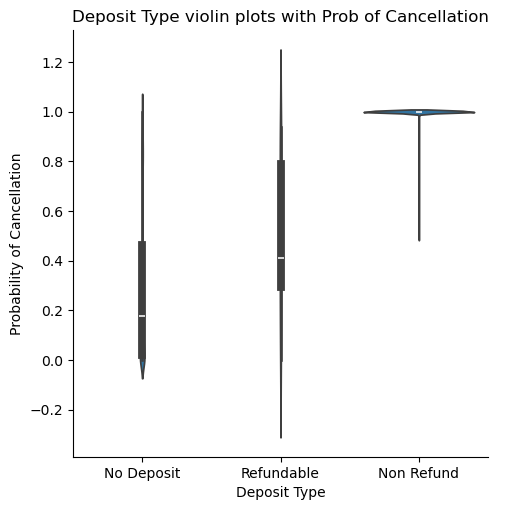

In [177]:
#show figure:

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.catplot(x='deposit_type', y='Prob_1', data=df_final_2017, kind = 'violin')

plt.xlabel('Deposit Type')
plt.ylabel('Probability of Cancellation')
plt.title('Deposit Type violin plots with Prob of Cancellation')
plt.show()

Deposit type non refundable has highest chance of cancellation. This raises the question of when is the deposit debited and is it non refundable immediately or before a certain time period of the arrival? 

## ADR

In [178]:
df_final_2017.adr.describe()

count   40687.00
mean      114.64
std        52.26
min        -6.38
25%        80.00
50%       107.10
75%       140.00
max       510.00
Name: adr, dtype: float64

<Figure size 1000x600 with 0 Axes>

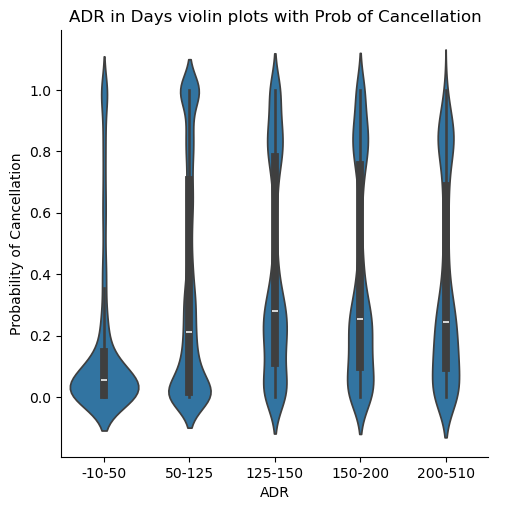

In [179]:
#show figure:
# Define bins for 'x_continuous'
bins = [-10, 50, 125, 150, 200, 510]  # Customize your bin edges
df_final_2017['adr_binned'] = pd.cut(df_final_2017['adr'],
                                                    bins=bins, labels=[f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)])

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.catplot(x='adr_binned', y='Prob_1', data=df_final_2017, kind = 'violin')

plt.xlabel('ADR')
plt.ylabel('Probability of Cancellation')
plt.title('ADR in Days violin plots with Prob of Cancellation')
plt.show()

High ADR has a higher chance of cancellation until a certain amount after which it becomes stagnant. The hotel can increase the ADR up until this amount to have the maximum benefit

## No. of Special Requests

<Figure size 1000x600 with 0 Axes>

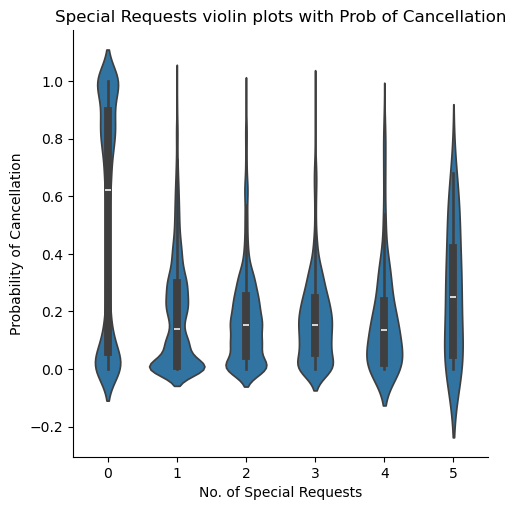

In [182]:
#show figure:

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.catplot(x='total_of_special_requests', y='Prob_1', data=df_final_2017, kind = 'violin')

plt.xlabel('No. of Special Requests')
plt.ylabel('Probability of Cancellation')
plt.title('Special Requests violin plots with Prob of Cancellation')
plt.show()

No special requests have a higher chance of cancellation. This means that people like special requests. Future work can be to study what special requests are more common and provide this as a complementory benefits to reservations that are highly likely to cancel